In [1]:
import os
import sys
sys.path.append("/home/dux/")
sys.path.append("/home/dux/surface_sampling/sgmc_surf")

import numpy as np

from ase.calculators.lammpsrun import LAMMPS
from ase.io import read

import catkit
from catkit.gen.adsorption import get_adsorption_sites

from mcmc import mcmc_run, get_adsorption_coords

from htvs.djangochem.pgmols.utils import surfaces

In [2]:
from time import perf_counter

start = perf_counter()
num_sweeps = 100

# use LAMMPS
parameters = {
    'pair_style': 'eam',
    'pair_coeff': ['* * Au_u3.eam']
}

potential_file = os.path.join(os.environ["LAMMPS_POTENTIALS"], 'Au_u3.eam')
lammps_calc = LAMMPS(files=[potential_file], keep_tmp_files=False, keep_alive=True, tmp_dir="/home/dux/surface_sampling/tmp_files")
lammps_calc.set(**parameters)

# Au from standard cell
atoms = read('Au_mp-81_conventional_standard.cif')
slab, surface_atoms = surfaces.surface_from_bulk(atoms, [1,1,0], size=[4,4])
slab.write("Au_110_pristine_slab.cif")

coords, connectivity, sym_idx = get_adsorption_sites(slab, symmetry_reduced=False)

element = 'Au'
metal = catkit.gratoms.Gratoms(element)

ads_coords = get_adsorption_coords(slab, metal, connectivity)

/home/dux/miniconda3/envs/mlenv/lib/python3.8/site-packages/catkit/gen/surface.py:334: UserWarning: Your slab has no bulk atoms and may be too thin to identify surface atoms correctly. This may cause surface adsorption site identification to fail.
  warnings.warn(
/home/dux/miniconda3/envs/mlenv/lib/python3.8/site-packages/catkit/gen/adsorption.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.r1_topology = np.array(self.r1_topology)
/home/dux/miniconda3/envs/mlenv/lib/python3.8/site-packages/catkit/gen/adsorption.py:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when

In [3]:
all_adsorbed = read("Au_110_all_adsorbed_slab.cif")
assert len(all_adsorbed) == len(slab) + len(ads_coords)

Manually removed some atoms

In [4]:
proper_adsorbed = read("Au_110_proper_adsorbed_slab.cif")
ads_positions = proper_adsorbed.get_positions()[len(slab):]

In [5]:
ads_positions.shape

(32, 3)

In [6]:
len(ads_positions)

32

In [7]:
slab, surface_atoms = surfaces.surface_from_bulk(atoms, [1,1,0], size=[4,4])

element = 'Au'
num_ads_atoms = 16 + 8 # for canonical runs
alpha = 0.99
num_sweeps = 300

history, energy_hist, frac_accept_hist, adsorption_count_hist = mcmc_run(num_sweeps=num_sweeps, temp=1, pot=0, alpha=alpha, slab=slab, calc=lammps_calc, element=element, canonical=True, num_ads_atoms=num_ads_atoms, ads_coords=ads_positions)

INFO:Running with num_sweeps = 300, temp = 1, pot = 0, alpha = 0.99
INFO:there are 64 atoms 
INFO:using slab calc <ase.calculators.lammpsrun.LAMMPS object at 0x7f93e9f670a0>
INFO:In pristine slab, there are a total of 32 sites
/home/dux/miniconda3/envs/mlenv/lib/python3.8/site-packages/ase/calculators/lammpsrun.py:379: UserWarning: semi-periodic ASE cell detected - translation to proper LAMMPS input cell might fail
  warnings.warn(
INFO:running for 32 iterations per run over a total of 300 runs
INFO:adsorbate is Au
INFO:In sweep 1 out of 300
INFO:optim structure has Energy = -309.1777503183357
INFO:In sweep 2 out of 300
INFO:optim structure has Energy = -312.0840191803314
INFO:In sweep 3 out of 300
INFO:optim structure has Energy = -313.1214885828766
INFO:In sweep 4 out of 300
INFO:optim structure has Energy = -312.4724252547844
INFO:In sweep 5 out of 300
INFO:optim structure has Energy = -312.1326020205119
INFO:In sweep 6 out of 300
INFO:optim structure has Energy = -311.5646517744524

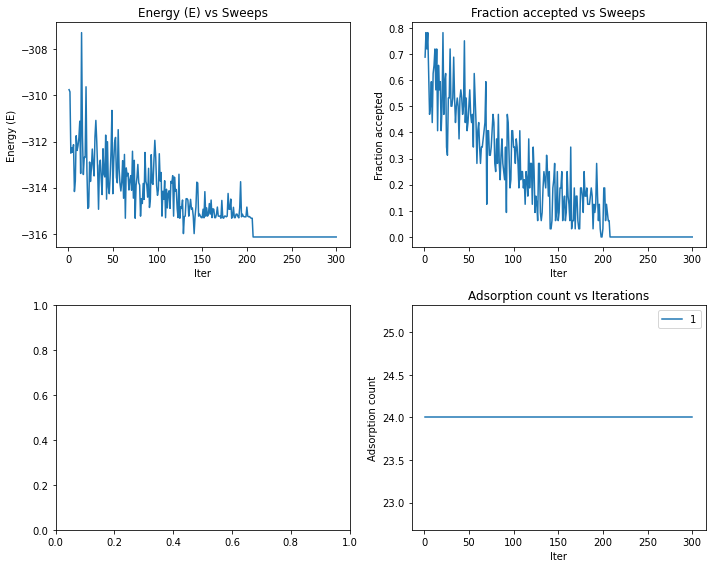

In [8]:
import matplotlib.pyplot as plt
runs = range(1, num_sweeps+1)
# do the plots
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
ax[0, 0].plot(runs, energy_hist)
ax[0, 0].set_xlabel("Iter")
ax[0, 0].set_ylabel("Energy (E)")
ax[0, 0].set_title("Energy (E) vs Sweeps")

ax[0, 1].plot(runs, frac_accept_hist)
ax[0, 1].set_xlabel("Iter")
ax[0, 1].set_ylabel("Fraction accepted")
ax[0, 1].set_title("Fraction accepted vs Sweeps")

ax[1, 1].plot(runs, np.array(list(adsorption_count_hist.values())).T)
ax[1, 1].set_xlabel("Iter")
ax[1, 1].set_ylabel("Adsorption count")
ax[1, 1].legend(adsorption_count_hist.keys())
ax[1, 1].set_title("Adsorption count vs Iterations")

fig.show()
fig.tight_layout()

In [9]:
from mcmc import mcmc_run, slab_energy

# calculated energy of desorbed rows (2 adjacent rows removed)
aligned_sites = read("Au_canonical_aligned_sites_300_iter.cif")
aligned_sites.calc = lammps_calc
print(f"aligned sites slab energy is {slab_energy(aligned_sites)}")

# non aligned sites (a lot more possibilites)
nonaligned_sites = read("Au_canonical_nonaligned_sites_300_iter.cif")
nonaligned_sites.calc = lammps_calc
print(f"nonaligned sites slab energy is {slab_energy(nonaligned_sites)}")


aligned sites slab energy is -316.1376632572531
nonaligned sites slab energy is -316.0347337124226


Try with relaxation

In [10]:
slab, surface_atoms = surfaces.surface_from_bulk(atoms, [1,1,0], size=[4,4])

element = 'Au'
num_ads_atoms = 16 + 8 # for canonical runs
alpha = 0.99
num_runs = 300

history, energy_hist, frac_accept_hist, adsorption_count_hist = mcmc_run(num_runs=num_runs, temp=1, pot=0, alpha=alpha, slab=slab, calc=lammps_calc, element=element, canonical=True, num_ads_atoms=num_ads_atoms, ads_coords=ads_positions, relax=True)

/home/dux/miniconda3/envs/mlenv/lib/python3.8/site-packages/catkit/gen/surface.py:334: UserWarning: Your slab has no bulk atoms and may be too thin to identify surface atoms correctly. This may cause surface adsorption site identification to fail.
  warnings.warn(
INFO:Running with num_runs = 300, temp = 1, pot = 0, alpha = 0.99
INFO:there are 64 atoms 
INFO:using slab calc <ase.calculators.lammpsrun.LAMMPS object at 0x7fd9f13ac6d0>
/home/dux/miniconda3/envs/mlenv/lib/python3.8/site-packages/catkit/gen/adsorption.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.r1_topology = np.array(self.r1_topology)
/home/dux/miniconda3/envs/mlenv/lib/python3.8/site-packages/catkit/gen/adsorption.py:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested seque

      Step     Time          Energy         fmax
BFGS:    0 19:31:16     -221.309054        1.5348
BFGS:    1 19:31:16     -221.342624        1.5269
BFGS:    2 19:31:16     -221.634743        1.3691
BFGS:    3 19:31:16     -221.883212        1.1110
BFGS:    4 19:31:16     -222.078981        0.8197
BFGS:    5 19:31:16     -222.108465        1.1213
BFGS:    6 19:31:16     -222.131607        0.4011
BFGS:    7 19:31:16     -222.140457        0.1669
      Step     Time          Energy         fmax
BFGS:    0 19:31:16     -225.769298        1.7388
BFGS:    1 19:31:16     -225.823092        1.7079
BFGS:    2 19:31:16     -226.190057        1.2595
BFGS:    3 19:31:16     -226.372190        0.3864


/home/dux/miniconda3/envs/mlenv/lib/python3.8/site-packages/ase/calculators/lammpsrun.py:379: UserWarning: semi-periodic ASE cell detected - translation to proper LAMMPS input cell might fail
  warnings.warn(


BFGS:    4 19:31:16     -226.380215        0.5461
BFGS:    5 19:31:16     -226.385536        0.5263
BFGS:    6 19:31:16     -226.453323        0.1968
      Step     Time          Energy         fmax
BFGS:    0 19:31:16     -229.646037        1.7388
BFGS:    1 19:31:16     -229.722241        1.7079
BFGS:    2 19:31:16     -230.215122        1.2594
BFGS:    3 19:31:16     -230.424547        0.3866
BFGS:    4 19:31:16     -230.429956        0.4205
BFGS:    5 19:31:16     -230.443878        0.4844
BFGS:    6 19:31:16     -230.471727        0.5305
BFGS:    7 19:31:16     -230.492959        0.3901
BFGS:    8 19:31:16     -230.504223        0.2267
BFGS:    9 19:31:16     -230.506660        0.2136
BFGS:   10 19:31:16     -230.511358        0.1997
      Step     Time          Energy         fmax
BFGS:    0 19:31:16     -231.307085        1.7388
BFGS:    1 19:31:16     -231.416509        1.7079
BFGS:    2 19:31:16     -232.169643        1.3877
BFGS:    3 19:31:16     -232.612194        1.1521
BF

INFO:running for 32 iterations per run over a total of 300 runs
INFO:adsorbate is Au
INFO:In sweep 1 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:31:24     -307.956699        1.5043
BFGS:    1 19:31:24     -308.277207        1.4486
BFGS:    2 19:31:24     -310.264096        0.7477
BFGS:    3 19:31:24     -310.461772        0.4691
BFGS:    4 19:31:24     -310.494905        0.4755
BFGS:    5 19:31:24     -310.518398        0.4571
BFGS:    6 19:31:24     -310.599767        0.2898
BFGS:    7 19:31:24     -310.638439        0.2976
BFGS:    8 19:31:24     -310.656260        0.2958
BFGS:    9 19:31:24     -310.670433        0.3102
BFGS:   10 19:31:24     -310.687444        0.2671
BFGS:   11 19:31:24     -310.709417        0.2187
BFGS:   12 19:31:24     -310.723917        0.1708
      Step     Time          Energy         fmax
BFGS:    0 19:31:24     -309.739161        1.4701
BFGS:    1 19:31:24     -310.027025        1.4003
BFGS:    2 19:31:24     -311.768202        0.7341
BFGS:    3 19:31:24     -311.885284        0.5032
BFGS:    4 19:31:24     -311.906942        0.5164
BF

INFO:optim structure has Energy = -313.9736967496121
INFO:In sweep 2 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:31:29     -310.464526        1.4235
BFGS:    1 19:31:29     -310.743714        1.3548
BFGS:    2 19:31:29     -312.456385        0.4878
BFGS:    3 19:31:29     -312.543720        0.3687
BFGS:    4 19:31:29     -312.562137        0.3138
BFGS:    5 19:31:29     -312.616937        0.2518
BFGS:    6 19:31:29     -312.675137        0.3039
BFGS:    7 19:31:29     -312.709068        0.2799
BFGS:    8 19:31:29     -312.722648        0.2200
BFGS:    9 19:31:29     -312.733670        0.2085
BFGS:   10 19:31:29     -312.748533        0.2058
BFGS:   11 19:31:29     -312.764905        0.1625
      Step     Time          Energy         fmax
BFGS:    0 19:31:29     -310.407882        1.4233
BFGS:    1 19:31:29     -310.699458        1.3622
BFGS:    2 19:31:30     -312.500006        0.6739
BFGS:    3 19:31:30     -312.605106        0.3949
BFGS:    4 19:31:30     -312.625991        0.3777
BFGS:    5 19:31:30     -312.673097        0.3812
BF

INFO:optim structure has Energy = -314.6504626633355
INFO:In sweep 3 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:31:34     -311.678541        1.5111
BFGS:    1 19:31:34     -311.953139        1.4463
BFGS:    2 19:31:34     -313.545464        0.6045
BFGS:    3 19:31:34     -313.644020        0.4133
BFGS:    4 19:31:34     -313.658790        0.3319
BFGS:    5 19:31:34     -313.679109        0.2434
BFGS:    6 19:31:34     -313.721516        0.3163
BFGS:    7 19:31:34     -313.755082        0.3205
BFGS:    8 19:31:34     -313.772559        0.2553
BFGS:    9 19:31:34     -313.781786        0.2228
BFGS:   10 19:31:34     -313.792172        0.2397
BFGS:   11 19:31:34     -313.805101        0.2112
BFGS:   12 19:31:34     -313.816447        0.1538
      Step     Time          Energy         fmax
BFGS:    0 19:31:34     -313.465179        1.5097
BFGS:    1 19:31:34     -313.715086        1.4379
BFGS:    2 19:31:34     -315.077727        0.4571
BFGS:    3 19:31:34     -315.120184        0.2868
BFGS:    4 19:31:34     -315.128397        0.2458
BF

INFO:optim structure has Energy = -315.1219028462921
INFO:In sweep 4 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:31:37     -313.699780        1.4697
BFGS:    1 19:31:37     -313.933199        1.3935
BFGS:    2 19:31:37     -315.245419        0.3406
BFGS:    3 19:31:37     -315.286403        0.3424
BFGS:    4 19:31:37     -315.292662        0.2925
BFGS:    5 19:31:37     -315.309245        0.1822
      Step     Time          Energy         fmax
BFGS:    0 19:31:37     -312.556983        1.4715
BFGS:    1 19:31:37     -312.805794        1.3959
BFGS:    2 19:31:37     -314.228527        0.4306
BFGS:    3 19:31:37     -314.286040        0.3410
BFGS:    4 19:31:37     -314.294732        0.2846
BFGS:    5 19:31:37     -314.314759        0.2198
BFGS:    6 19:31:37     -314.336532        0.2472
BFGS:    7 19:31:37     -314.349002        0.2442
BFGS:    8 19:31:37     -314.354557        0.1969
      Step     Time          Energy         fmax
BFGS:    0 19:31:37     -312.543438        1.4919
BFGS:    1 19:31:37     -312.791070        1.4158
BFG

INFO:optim structure has Energy = -313.0150776004069
INFO:In sweep 5 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:31:41     -311.464699        1.4793
BFGS:    1 19:31:41     -311.710479        1.4147
BFGS:    2 19:31:41     -313.206281        0.7550
BFGS:    3 19:31:41     -313.326729        0.4597
BFGS:    4 19:31:41     -313.342375        0.4105
BFGS:    5 19:31:41     -313.354527        0.4134
BFGS:    6 19:31:41     -313.390474        0.3576
BFGS:    7 19:31:41     -313.412146        0.2918
BFGS:    8 19:31:41     -313.421865        0.2803
BFGS:    9 19:31:41     -313.426911        0.2864
BFGS:   10 19:31:42     -313.435482        0.2931
BFGS:   11 19:31:42     -313.449847        0.2932
BFGS:   12 19:31:42     -313.471018        0.4314
BFGS:   13 19:31:42     -313.490384        0.4972
BFGS:   14 19:31:42     -313.506218        0.4550
BFGS:   15 19:31:42     -313.523407        0.3616
BFGS:   16 19:31:42     -313.561412        0.4759
BFGS:   17 19:31:42     -313.605245        0.6454
BFGS:   18 19:31:42     -313.652628        0.7966
B

INFO:optim structure has Energy = -310.8072529829384
INFO:In sweep 6 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:31:47     -308.540917        1.4666
BFGS:    1 19:31:47     -308.828554        1.4051
BFGS:    2 19:31:47     -310.655149        0.7168
BFGS:    3 19:31:47     -310.810665        0.4212
BFGS:    4 19:31:47     -310.835557        0.4698
BFGS:    5 19:31:47     -310.851086        0.4488
BFGS:    6 19:31:47     -310.905414        0.2606
BFGS:    7 19:31:47     -310.926648        0.2657
BFGS:    8 19:31:47     -310.934496        0.2312
BFGS:    9 19:31:47     -310.940556        0.2105
BFGS:   10 19:31:47     -310.948890        0.1739
      Step     Time          Energy         fmax
BFGS:    0 19:31:47     -308.590195        1.4685
BFGS:    1 19:31:47     -308.868631        1.4071
BFGS:    2 19:31:47     -310.652543        0.7189
BFGS:    3 19:31:47     -310.831874        0.4179
BFGS:    4 19:31:47     -310.859334        0.4654
BFGS:    5 19:31:47     -310.873397        0.4436
BFGS:    6 19:31:47     -310.925119        0.2438
BF

INFO:optim structure has Energy = -314.9406194527452
INFO:In sweep 7 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:31:52     -313.164126        1.3037
BFGS:    1 19:31:52     -313.385919        1.2456
BFGS:    2 19:31:52     -314.682167        0.3419
BFGS:    3 19:31:52     -314.698507        0.2347
BFGS:    4 19:31:52     -314.703993        0.2222
BFGS:    5 19:31:52     -314.750371        0.1574
      Step     Time          Energy         fmax
BFGS:    0 19:31:52     -314.030475        1.5040
BFGS:    1 19:31:52     -314.240084        1.4378
BFGS:    2 19:31:52     -315.431501        0.5746
BFGS:    3 19:31:52     -315.495416        0.1869
      Step     Time          Energy         fmax
BFGS:    0 19:31:52     -313.823732        1.4183
BFGS:    1 19:31:52     -314.034617        1.3420
BFGS:    2 19:31:52     -315.243803        0.2694
BFGS:    3 19:31:52     -315.275301        0.1572
      Step     Time          Energy         fmax
BFGS:    0 19:31:52     -312.646510        1.4683
BFGS:    1 19:31:52     -312.874930        1.4067
BFGS

INFO:optim structure has Energy = -315.031643593873
INFO:In sweep 8 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:31:56     -311.054091        1.6693
BFGS:    1 19:31:56     -311.324583        1.6217
BFGS:    2 19:31:56     -312.878608        1.0376
BFGS:    3 19:31:56     -313.127670        0.4326
BFGS:    4 19:31:56     -313.156201        0.5202
BFGS:    5 19:31:56     -313.172670        0.5120
BFGS:    6 19:31:56     -313.242612        0.3502
BFGS:    7 19:31:56     -313.270412        0.3342
BFGS:    8 19:31:56     -313.287003        0.4204
BFGS:    9 19:31:56     -313.302686        0.4890
BFGS:   10 19:31:56     -313.329805        0.5211
BFGS:   11 19:31:56     -313.363631        0.4648
BFGS:   12 19:31:56     -313.391065        0.3965
BFGS:   13 19:31:56     -313.411054        0.4126
BFGS:   14 19:31:56     -313.427810        0.4527
BFGS:   15 19:31:56     -313.455183        0.4940
BFGS:   16 19:31:56     -313.500112        0.4860
BFGS:   17 19:31:56     -313.541196        0.3876
BFGS:   18 19:31:56     -313.566863        0.2674
B

INFO:optim structure has Energy = -315.1626214818264
INFO:In sweep 9 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:32:00     -312.246983        1.4704
BFGS:    1 19:32:00     -312.509094        1.3965
BFGS:    2 19:32:00     -313.981707        0.5253
BFGS:    3 19:32:00     -314.025047        0.3763
BFGS:    4 19:32:00     -314.036262        0.3301
BFGS:    5 19:32:00     -314.075306        0.2295
BFGS:    6 19:32:00     -314.098841        0.2271
BFGS:    7 19:32:00     -314.108315        0.1882
      Step     Time          Energy         fmax
BFGS:    0 19:32:00     -313.887027        1.3704
BFGS:    1 19:32:00     -314.105957        1.2949
BFGS:    2 19:32:00     -315.330258        0.2322
BFGS:    3 19:32:00     -315.344549        0.2389
BFGS:    4 19:32:00     -315.349285        0.2184
BFGS:    5 19:32:00     -315.376176        0.1009
      Step     Time          Energy         fmax
BFGS:    0 19:32:00     -313.888558        1.3698
BFGS:    1 19:32:00     -314.107471        1.2941
BFGS:    2 19:32:00     -315.327124        0.2228
BFG

INFO:optim structure has Energy = -314.9114850949653
INFO:In sweep 10 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:32:05     -313.418091        1.4958
BFGS:    1 19:32:05     -313.662512        1.4323
BFGS:    2 19:32:05     -315.019146        0.5866
BFGS:    3 19:32:05     -315.076063        0.3019
BFGS:    4 19:32:05     -315.086343        0.2586
BFGS:    5 19:32:05     -315.112952        0.2676
BFGS:    6 19:32:05     -315.145828        0.2813
BFGS:    7 19:32:05     -315.169422        0.2347
BFGS:    8 19:32:05     -315.179991        0.2520
BFGS:    9 19:32:05     -315.186942        0.2823
BFGS:   10 19:32:05     -315.196176        0.2577
BFGS:   11 19:32:05     -315.206693        0.1774
      Step     Time          Energy         fmax
BFGS:    0 19:32:05     -313.146177        1.4576
BFGS:    1 19:32:05     -313.393729        1.3842
BFGS:    2 19:32:05     -314.780448        0.3992
BFGS:    3 19:32:05     -314.819673        0.3807
BFGS:    4 19:32:05     -314.829142        0.3351
BFGS:    5 19:32:05     -314.878653        0.2415
BF

INFO:optim structure has Energy = -314.8531217434765
INFO:In sweep 11 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:32:09     -313.435101        1.4703
BFGS:    1 19:32:09     -313.651906        1.4058
BFGS:    2 19:32:09     -314.913932        0.5386
BFGS:    3 19:32:09     -314.979957        0.3170
BFGS:    4 19:32:09     -314.988804        0.2619
BFGS:    5 19:32:09     -315.001991        0.2096
BFGS:    6 19:32:09     -315.022375        0.1948
      Step     Time          Energy         fmax
BFGS:    0 19:32:09     -312.189749        1.6447
BFGS:    1 19:32:09     -312.436580        1.5911
BFGS:    2 19:32:09     -313.832170        0.8275
BFGS:    3 19:32:09     -313.997524        0.3860
BFGS:    4 19:32:09     -314.017349        0.2747
BFGS:    5 19:32:09     -314.028026        0.2756
BFGS:    6 19:32:09     -314.079640        0.2323
BFGS:    7 19:32:09     -314.091688        0.1903
      Step     Time          Energy         fmax
BFGS:    0 19:32:09     -312.697890        1.5116
BFGS:    1 19:32:09     -312.944235        1.4371
BFG

INFO:optim structure has Energy = -313.4827949758233
INFO:In sweep 12 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:32:13     -312.472850        1.4722
BFGS:    1 19:32:13     -312.740018        1.3997
BFGS:    2 19:32:13     -314.243056        0.4149
BFGS:    3 19:32:13     -314.295012        0.3197
BFGS:    4 19:32:13     -314.304245        0.2766
BFGS:    5 19:32:13     -314.338939        0.2669
BFGS:    6 19:32:13     -314.373260        0.3027
BFGS:    7 19:32:13     -314.395377        0.2645
BFGS:    8 19:32:13     -314.404126        0.1990
      Step     Time          Energy         fmax
BFGS:    0 19:32:13     -312.171007        1.4722
BFGS:    1 19:32:13     -312.430753        1.3994
BFGS:    2 19:32:13     -313.919538        0.4707
BFGS:    3 19:32:13     -313.980698        0.2754
BFGS:    4 19:32:13     -313.990251        0.2377
BFGS:    5 19:32:13     -314.015361        0.2408
BFGS:    6 19:32:13     -314.047154        0.2682
BFGS:    7 19:32:13     -314.069447        0.2324
BFGS:    8 19:32:13     -314.079068        0.2099
BF

INFO:optim structure has Energy = -315.0329599092079
INFO:In sweep 13 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:32:16     -313.146244        1.4317
BFGS:    1 19:32:16     -313.393276        1.3585
BFGS:    2 19:32:16     -314.785722        0.3799
BFGS:    3 19:32:16     -314.819017        0.3130
BFGS:    4 19:32:16     -314.827751        0.2880
BFGS:    5 19:32:16     -314.882184        0.1929
      Step     Time          Energy         fmax
BFGS:    0 19:32:16     -311.741869        1.6896
BFGS:    1 19:32:16     -312.020484        1.6200
BFGS:    2 19:32:16     -313.534852        0.6831
BFGS:    3 19:32:16     -313.683520        0.4547
BFGS:    4 19:32:16     -313.705578        0.3368
BFGS:    5 19:32:16     -313.722940        0.2635
BFGS:    6 19:32:16     -313.779268        0.3527
BFGS:    7 19:32:16     -313.807357        0.3513
BFGS:    8 19:32:16     -313.820336        0.2719
BFGS:    9 19:32:16     -313.827232        0.1975
      Step     Time          Energy         fmax
BFGS:    0 19:32:16     -311.687244        1.4308
BFG

INFO:optim structure has Energy = -314.5009908215619
INFO:In sweep 14 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:32:21     -312.095192        1.5452
BFGS:    1 19:32:21     -312.384547        1.4688
BFGS:    2 19:32:21     -313.976767        0.4737
BFGS:    3 19:32:21     -314.042124        0.5377
BFGS:    4 19:32:21     -314.056255        0.4476
BFGS:    5 19:32:21     -314.090573        0.2692
BFGS:    6 19:32:21     -314.132487        0.2976
BFGS:    7 19:32:21     -314.157841        0.2877
BFGS:    8 19:32:21     -314.168261        0.2149
BFGS:    9 19:32:21     -314.175349        0.2260
BFGS:   10 19:32:21     -314.184333        0.1989
      Step     Time          Energy         fmax
BFGS:    0 19:32:21     -311.462676        1.5453
BFGS:    1 19:32:21     -311.751155        1.4695
BFGS:    2 19:32:21     -313.367793        0.4850
BFGS:    3 19:32:21     -313.448423        0.5766
BFGS:    4 19:32:21     -313.462787        0.4711
BFGS:    5 19:32:21     -313.485548        0.3080
BFGS:    6 19:32:21     -313.517766        0.2604
BF

INFO:optim structure has Energy = -314.4569912016487
INFO:In sweep 15 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:32:25     -311.321823        1.6723
BFGS:    1 19:32:25     -311.606527        1.6327
BFGS:    2 19:32:25     -313.186616        1.0887
BFGS:    3 19:32:25     -313.399411        0.5005
BFGS:    4 19:32:25     -313.429077        0.6159
BFGS:    5 19:32:25     -313.447984        0.6066
BFGS:    6 19:32:25     -313.540559        0.3813
BFGS:    7 19:32:25     -313.570831        0.2676
BFGS:    8 19:32:25     -313.585641        0.3198
BFGS:    9 19:32:25     -313.597588        0.3329
BFGS:   10 19:32:25     -313.616006        0.3073
BFGS:   11 19:32:25     -313.636031        0.2472
BFGS:   12 19:32:25     -313.650430        0.2702
BFGS:   13 19:32:25     -313.659180        0.3307
BFGS:   14 19:32:25     -313.667000        0.3335
BFGS:   15 19:32:25     -313.682330        0.2880
BFGS:   16 19:32:25     -313.704952        0.2204
BFGS:   17 19:32:25     -313.726931        0.2614
BFGS:   18 19:32:25     -313.737937        0.2842
B

INFO:optim structure has Energy = -313.8046452049812
INFO:In sweep 16 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:32:30     -311.732382        1.4524
BFGS:    1 19:32:30     -311.993880        1.3820
BFGS:    2 19:32:30     -313.520224        0.4400
BFGS:    3 19:32:30     -313.587635        0.3599
BFGS:    4 19:32:30     -313.596275        0.3044
BFGS:    5 19:32:30     -313.614406        0.2321
BFGS:    6 19:32:30     -313.640914        0.2965
BFGS:    7 19:32:30     -313.660423        0.3041
BFGS:    8 19:32:30     -313.669353        0.2603
BFGS:    9 19:32:30     -313.675015        0.2081
BFGS:   10 19:32:30     -313.682508        0.1867
      Step     Time          Energy         fmax
BFGS:    0 19:32:30     -311.732766        1.4438
BFGS:    1 19:32:30     -311.994610        1.3747
BFGS:    2 19:32:30     -313.530985        0.4381
BFGS:    3 19:32:30     -313.599162        0.2736
BFGS:    4 19:32:30     -313.607738        0.2333
BFGS:    5 19:32:30     -313.626338        0.2347
BFGS:    6 19:32:30     -313.652551        0.2762
BF

INFO:optim structure has Energy = -313.3554184868414
INFO:In sweep 17 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:32:34     -309.606923        1.7295
BFGS:    1 19:32:34     -309.904711        1.6596
BFGS:    2 19:32:34     -311.573624        0.6728
BFGS:    3 19:32:34     -311.775702        0.6745
BFGS:    4 19:32:34     -311.814907        0.4386
BFGS:    5 19:32:34     -311.826958        0.3695
BFGS:    6 19:32:34     -311.883176        0.2637
BFGS:    7 19:32:34     -311.888054        0.2465
BFGS:    8 19:32:34     -311.899043        0.1697
      Step     Time          Energy         fmax
BFGS:    0 19:32:34     -311.334860        1.4551
BFGS:    1 19:32:34     -311.579278        1.3916
BFGS:    2 19:32:34     -313.045600        0.5454
BFGS:    3 19:32:34     -313.125498        0.2376
BFGS:    4 19:32:34     -313.136036        0.1866
      Step     Time          Energy         fmax
BFGS:    0 19:32:34     -311.628198        1.4551
BFGS:    1 19:32:34     -311.883382        1.3916
BFGS:    2 19:32:34     -313.373262        0.5449
BFG

INFO:optim structure has Energy = -312.6059024183434
INFO:In sweep 18 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:32:39     -309.702303        1.4177
BFGS:    1 19:32:39     -309.985087        1.3444
BFGS:    2 19:32:39     -311.733482        0.7068
BFGS:    3 19:32:39     -311.844497        0.4498
BFGS:    4 19:32:39     -311.863784        0.4595
BFGS:    5 19:32:39     -311.909084        0.4033
BFGS:    6 19:32:39     -311.956799        0.3237
BFGS:    7 19:32:39     -311.981336        0.3005
BFGS:    8 19:32:39     -311.991621        0.3168
BFGS:    9 19:32:39     -312.005861        0.3415
BFGS:   10 19:32:39     -312.024109        0.3529
BFGS:   11 19:32:39     -312.050899        0.3320
BFGS:   12 19:32:39     -312.071612        0.2931
BFGS:   13 19:32:39     -312.084070        0.2751
BFGS:   14 19:32:39     -312.094358        0.2821
BFGS:   15 19:32:39     -312.113985        0.3227
BFGS:   16 19:32:39     -312.146499        0.4054
BFGS:   17 19:32:39     -312.189780        0.5420
BFGS:   18 19:32:39     -312.232170        0.6778
B

INFO:optim structure has Energy = -314.8615623199881
INFO:In sweep 19 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:32:43     -311.763656        1.4380
BFGS:    1 19:32:43     -312.032014        1.3754
BFGS:    2 19:32:43     -313.599729        0.7145
BFGS:    3 19:32:43     -313.664952        0.4490
BFGS:    4 19:32:43     -313.679144        0.4622
BFGS:    5 19:32:43     -313.729295        0.3857
BFGS:    6 19:32:44     -313.768465        0.2944
BFGS:    7 19:32:44     -313.789632        0.2867
BFGS:    8 19:32:44     -313.798713        0.3077
BFGS:    9 19:32:44     -313.809521        0.3196
BFGS:   10 19:32:44     -313.824479        0.2846
BFGS:   11 19:32:44     -313.841269        0.2168
BFGS:   12 19:32:44     -313.852038        0.2204
BFGS:   13 19:32:44     -313.857404        0.2050
BFGS:   14 19:32:44     -313.862378        0.2118
BFGS:   15 19:32:44     -313.871756        0.1977
      Step     Time          Energy         fmax
BFGS:    0 19:32:44     -312.404512        1.4803
BFGS:    1 19:32:44     -312.668157        1.4104
BF

INFO:optim structure has Energy = -313.3644606195764
INFO:In sweep 20 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:32:48     -310.466574        1.5244
BFGS:    1 19:32:48     -310.723567        1.4654
BFGS:    2 19:32:48     -312.251853        0.7458
BFGS:    3 19:32:48     -312.392910        0.6275
BFGS:    4 19:32:48     -312.416771        0.5078
BFGS:    5 19:32:48     -312.447366        0.4733
BFGS:    6 19:32:48     -312.507687        0.3302
BFGS:    7 19:32:48     -312.537979        0.3296
BFGS:    8 19:32:48     -312.547912        0.2529
BFGS:    9 19:32:48     -312.554843        0.2309
BFGS:   10 19:32:48     -312.561230        0.1952
      Step     Time          Energy         fmax
BFGS:    0 19:32:48     -309.383239        1.4436
BFGS:    1 19:32:48     -309.660167        1.3979
BFGS:    2 19:32:48     -311.411643        0.7861
BFGS:    3 19:32:48     -311.585538        0.3941
BFGS:    4 19:32:48     -311.611160        0.4389
BFGS:    5 19:32:48     -311.640757        0.4359
BFGS:    6 19:32:48     -311.703764        0.3578
BF

INFO:optim structure has Energy = -312.6723231865266
INFO:In sweep 21 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:32:53     -310.671156        1.3389
BFGS:    1 19:32:53     -310.930772        1.2634
BFGS:    2 19:32:53     -312.552176        0.3942
BFGS:    3 19:32:53     -312.599291        0.3000
BFGS:    4 19:32:53     -312.609181        0.2628
BFGS:    5 19:32:53     -312.650074        0.2067
BFGS:    6 19:32:53     -312.675578        0.1937
      Step     Time          Energy         fmax
BFGS:    0 19:32:53     -311.128545        1.4740
BFGS:    1 19:32:53     -311.394177        1.4096
BFGS:    2 19:32:53     -312.973973        0.5525
BFGS:    3 19:32:53     -313.072746        0.3949
BFGS:    4 19:32:53     -313.086050        0.3138
BFGS:    5 19:32:53     -313.102126        0.2176
BFGS:    6 19:32:53     -313.135302        0.2712
BFGS:    7 19:32:53     -313.157759        0.2952
BFGS:    8 19:32:53     -313.169111        0.2498
BFGS:    9 19:32:53     -313.176022        0.1914
      Step     Time          Energy         fmax
BFG

INFO:optim structure has Energy = -313.8265727738803
INFO:In sweep 22 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:32:57     -311.874380        1.6669
BFGS:    1 19:32:57     -312.128690        1.6149
BFGS:    2 19:32:57     -313.557485        0.8819
BFGS:    3 19:32:57     -313.732790        0.3148
BFGS:    4 19:32:57     -313.752299        0.3096
BFGS:    5 19:32:57     -313.759030        0.3051
BFGS:    6 19:32:57     -313.813730        0.1465
      Step     Time          Energy         fmax
BFGS:    0 19:32:57     -311.805928        1.6464
BFGS:    1 19:32:57     -312.096183        1.5932
BFGS:    2 19:32:57     -313.685759        0.8266
BFGS:    3 19:32:57     -313.830175        0.4842
BFGS:    4 19:32:57     -313.854266        0.3625
BFGS:    5 19:32:57     -313.871783        0.3464
BFGS:    6 19:32:57     -313.944854        0.3670
BFGS:    7 19:32:57     -313.984365        0.3041
BFGS:    8 19:32:57     -314.004952        0.2785
BFGS:    9 19:32:57     -314.014823        0.3283
BFGS:   10 19:32:57     -314.026270        0.3175
BF

INFO:optim structure has Energy = -313.9433962138519
INFO:In sweep 23 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:33:00     -312.088837        1.4815
BFGS:    1 19:33:00     -312.345556        1.4154
BFGS:    2 19:33:00     -313.842001        0.5554
BFGS:    3 19:33:00     -313.914214        0.3666
BFGS:    4 19:33:00     -313.927021        0.2986
BFGS:    5 19:33:00     -313.943109        0.2306
BFGS:    6 19:33:00     -313.974474        0.2887
BFGS:    7 19:33:00     -313.996885        0.2899
BFGS:    8 19:33:00     -314.007605        0.2396
BFGS:    9 19:33:00     -314.013207        0.1944
      Step     Time          Energy         fmax
BFGS:    0 19:33:00     -310.656094        1.6765
BFGS:    1 19:33:00     -310.942232        1.6120
BFGS:    2 19:33:00     -312.563709        0.8153
BFGS:    3 19:33:00     -312.758793        0.4109
BFGS:    4 19:33:00     -312.790288        0.2924
BFGS:    5 19:33:00     -312.803661        0.2977
BFGS:    6 19:33:00     -312.879631        0.3784
BFGS:    7 19:33:00     -312.906681        0.3282
BF

INFO:optim structure has Energy = -313.111336367667
INFO:In sweep 24 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:33:06     -311.502710        1.3909
BFGS:    1 19:33:06     -311.762443        1.3216
BFGS:    2 19:33:06     -313.341424        0.4210
BFGS:    3 19:33:06     -313.401634        0.2361
BFGS:    4 19:33:06     -313.411150        0.2309
BFGS:    5 19:33:06     -313.439449        0.2320
BFGS:    6 19:33:06     -313.470706        0.2152
BFGS:    7 19:33:06     -313.490867        0.1845
      Step     Time          Energy         fmax
BFGS:    0 19:33:06     -311.805030        1.3947
BFGS:    1 19:33:06     -312.070028        1.3344
BFGS:    2 19:33:06     -313.640543        0.7062
BFGS:    3 19:33:06     -313.702713        0.4883
BFGS:    4 19:33:06     -313.713854        0.4906
BFGS:    5 19:33:06     -313.764549        0.4027
BFGS:    6 19:33:06     -313.799769        0.3382
BFGS:    7 19:33:06     -313.820970        0.3962
BFGS:    8 19:33:06     -313.831611        0.4421
BFGS:    9 19:33:06     -313.848486        0.4671
BF

INFO:optim structure has Energy = -312.8861041729203
INFO:In sweep 25 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:33:10     -310.520007        1.4940
BFGS:    1 19:33:10     -310.792148        1.4500
BFGS:    2 19:33:10     -312.450067        0.8551
BFGS:    3 19:33:10     -312.615943        0.4020
BFGS:    4 19:33:10     -312.637319        0.4541
BFGS:    5 19:33:10     -312.656917        0.4344
BFGS:    6 19:33:10     -312.707919        0.2988
BFGS:    7 19:33:10     -312.734342        0.2716
BFGS:    8 19:33:10     -312.744269        0.2228
BFGS:    9 19:33:10     -312.750917        0.2247
BFGS:   10 19:33:11     -312.759423        0.2316
BFGS:   11 19:33:11     -312.772336        0.1942
      Step     Time          Energy         fmax
BFGS:    0 19:33:11     -309.923282        1.4938
BFGS:    1 19:33:11     -310.208772        1.4498
BFGS:    2 19:33:11     -311.940737        0.8543
BFGS:    3 19:33:11     -312.105444        0.4081
BFGS:    4 19:33:11     -312.127162        0.4600
BFGS:    5 19:33:11     -312.153635        0.4342
BF

INFO:optim structure has Energy = -314.8412769988684
INFO:In sweep 26 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:33:15     -312.522954        1.4714
BFGS:    1 19:33:15     -312.767766        1.4065
BFGS:    2 19:33:15     -314.148964        0.5358
BFGS:    3 19:33:15     -314.202654        0.2443
BFGS:    4 19:33:15     -314.211393        0.2221
BFGS:    5 19:33:15     -314.228208        0.2352
BFGS:    6 19:33:15     -314.253812        0.1933
      Step     Time          Energy         fmax
BFGS:    0 19:33:15     -311.786290        1.4538
BFGS:    1 19:33:15     -312.048550        1.3904
BFGS:    2 19:33:15     -313.596154        0.5355
BFGS:    3 19:33:15     -313.674331        0.2993
BFGS:    4 19:33:15     -313.687299        0.2457
BFGS:    5 19:33:15     -313.711413        0.2284
BFGS:    6 19:33:15     -313.752024        0.2708
BFGS:    7 19:33:15     -313.784149        0.2713
BFGS:    8 19:33:15     -313.799551        0.2374
BFGS:    9 19:33:15     -313.807053        0.2409
BFGS:   10 19:33:15     -313.815683        0.2444
BF

INFO:optim structure has Energy = -313.0216971419721
INFO:In sweep 27 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:33:20     -310.094166        1.4414
BFGS:    1 19:33:20     -310.400229        1.3761
BFGS:    2 19:33:20     -312.286057        0.5417
BFGS:    3 19:33:20     -312.402289        0.3606
BFGS:    4 19:33:20     -312.420401        0.2857
BFGS:    5 19:33:20     -312.442793        0.2206
BFGS:    6 19:33:20     -312.491677        0.2818
BFGS:    7 19:33:20     -312.530423        0.2970
BFGS:    8 19:33:20     -312.550726        0.2538
BFGS:    9 19:33:20     -312.560442        0.2032
BFGS:   10 19:33:20     -312.571626        0.2209
BFGS:   11 19:33:20     -312.586954        0.2007
BFGS:   12 19:33:20     -312.601618        0.1743
      Step     Time          Energy         fmax
BFGS:    0 19:33:20     -310.507784        1.4900
BFGS:    1 19:33:20     -310.799721        1.4284
BFGS:    2 19:33:20     -312.556251        0.6236
BFGS:    3 19:33:20     -312.678142        0.3581
BFGS:    4 19:33:20     -312.696024        0.2769
BF

INFO:optim structure has Energy = -314.9119982761187
INFO:In sweep 28 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:33:24     -311.704560        1.4087
BFGS:    1 19:33:24     -311.961033        1.3382
BFGS:    2 19:33:24     -313.502017        0.7194
BFGS:    3 19:33:24     -313.576146        0.4957
BFGS:    4 19:33:24     -313.594132        0.4835
BFGS:    5 19:33:24     -313.691728        0.2079
BFGS:    6 19:33:24     -313.708763        0.1810
      Step     Time          Energy         fmax
BFGS:    0 19:33:24     -313.296080        1.3509
BFGS:    1 19:33:24     -313.514582        1.2765
BFGS:    2 19:33:24     -314.784048        0.3102
BFGS:    3 19:33:24     -314.798910        0.2978
BFGS:    4 19:33:24     -314.806554        0.2808
BFGS:    5 19:33:24     -314.852307        0.1656
      Step     Time          Energy         fmax
BFGS:    0 19:33:24     -311.925228        1.4936
BFGS:    1 19:33:24     -312.167055        1.4301
BFGS:    2 19:33:24     -313.573831        0.5866
BFGS:    3 19:33:24     -313.655880        0.3651
BFG

INFO:optim structure has Energy = -313.9933595604293
INFO:In sweep 29 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:33:28     -309.965732        1.6563
BFGS:    1 19:33:28     -310.256986        1.5960
BFGS:    2 19:33:28     -311.965968        0.8260
BFGS:    3 19:33:28     -312.208836        0.7359
BFGS:    4 19:33:28     -312.256568        0.4901
BFGS:    5 19:33:28     -312.278843        0.4482
BFGS:    6 19:33:28     -312.387109        0.3593
BFGS:    7 19:33:28     -312.407189        0.3143
BFGS:    8 19:33:28     -312.420792        0.3447
BFGS:    9 19:33:28     -312.433927        0.3654
BFGS:   10 19:33:28     -312.456931        0.3245
BFGS:   11 19:33:28     -312.477061        0.2934
BFGS:   12 19:33:28     -312.489193        0.2468
BFGS:   13 19:33:28     -312.494930        0.2024
BFGS:   14 19:33:28     -312.501471        0.1612
      Step     Time          Energy         fmax
BFGS:    0 19:33:28     -311.646351        1.6263
BFGS:    1 19:33:28     -311.930885        1.5610
BFGS:    2 19:33:28     -313.545628        0.6684
BF

INFO:optim structure has Energy = -314.5443407755138
INFO:In sweep 30 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:33:33     -311.191221        1.4658
BFGS:    1 19:33:33     -311.445276        1.3914
BFGS:    2 19:33:33     -312.962002        0.5342
BFGS:    3 19:33:33     -313.033029        0.5434
BFGS:    4 19:33:33     -313.048487        0.4257
BFGS:    5 19:33:33     -313.067569        0.2837
BFGS:    6 19:33:33     -313.093299        0.1667
      Step     Time          Energy         fmax
BFGS:    0 19:33:33     -312.834971        1.3988
BFGS:    1 19:33:33     -313.057855        1.3509
BFGS:    2 19:33:33     -314.373492        0.6962
BFGS:    3 19:33:33     -314.431888        0.4440
BFGS:    4 19:33:33     -314.442089        0.4503
BFGS:    5 19:33:33     -314.481264        0.3587
BFGS:    6 19:33:33     -314.505623        0.2815
BFGS:    7 19:33:33     -314.518575        0.3081
BFGS:    8 19:33:33     -314.525383        0.3441
BFGS:    9 19:33:33     -314.536771        0.3709
BFGS:   10 19:33:33     -314.553488        0.3500
BF

INFO:optim structure has Energy = -315.4180908892845
INFO:In sweep 31 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:33:37     -312.626007        1.4676
BFGS:    1 19:33:37     -312.890676        1.3989
BFGS:    2 19:33:37     -314.406711        0.5420
BFGS:    3 19:33:37     -314.475455        0.3030
BFGS:    4 19:33:37     -314.485442        0.2597
BFGS:    5 19:33:37     -314.509595        0.2663
BFGS:    6 19:33:37     -314.539696        0.2810
BFGS:    7 19:33:37     -314.561318        0.2332
BFGS:    8 19:33:37     -314.570947        0.2336
BFGS:    9 19:33:37     -314.578141        0.2688
BFGS:   10 19:33:37     -314.587468        0.2488
BFGS:   11 19:33:37     -314.599191        0.1568
      Step     Time          Energy         fmax
BFGS:    0 19:33:37     -311.059633        1.4676
BFGS:    1 19:33:37     -311.351730        1.3996
BFGS:    2 19:33:37     -313.056012        0.7423
BFGS:    3 19:33:37     -313.152366        0.4834
BFGS:    4 19:33:37     -313.167574        0.4963
BFGS:    5 19:33:37     -313.210998        0.4399
BF

INFO:optim structure has Energy = -314.1068332465595
INFO:In sweep 32 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:33:41     -310.001450        1.4508
BFGS:    1 19:33:41     -310.295599        1.3866
BFGS:    2 19:33:41     -312.087522        0.7437
BFGS:    3 19:33:41     -312.213457        0.4341
BFGS:    4 19:33:41     -312.236555        0.4662
BFGS:    5 19:33:41     -312.280529        0.4451
BFGS:    6 19:33:41     -312.346283        0.3634
BFGS:    7 19:33:41     -312.393127        0.3470
BFGS:    8 19:33:41     -312.416861        0.4108
BFGS:    9 19:33:41     -312.434474        0.4452
BFGS:   10 19:33:41     -312.462927        0.4436
BFGS:   11 19:33:41     -312.503731        0.3783
BFGS:   12 19:33:41     -312.547333        0.3376
BFGS:   13 19:33:41     -312.577063        0.3484
BFGS:   14 19:33:41     -312.596003        0.3375
BFGS:   15 19:33:41     -312.619042        0.3580
BFGS:   16 19:33:41     -312.677868        0.4705
BFGS:   17 19:33:41     -312.762512        0.6583
BFGS:   18 19:33:41     -312.842286        0.8266
B

INFO:optim structure has Energy = -315.6281154382632
INFO:In sweep 33 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:33:45     -312.941099        1.5463
BFGS:    1 19:33:45     -313.198225        1.4779
BFGS:    2 19:33:45     -314.625506        0.5840
BFGS:    3 19:33:45     -314.692946        0.5639
BFGS:    4 19:33:45     -314.705890        0.4478
BFGS:    5 19:33:45     -314.722684        0.2855
BFGS:    6 19:33:45     -314.747594        0.2077
BFGS:    7 19:33:45     -314.760684        0.2355
BFGS:    8 19:33:45     -314.767296        0.1911
      Step     Time          Energy         fmax
BFGS:    0 19:33:46     -313.761501        1.4873
BFGS:    1 19:33:46     -314.002189        1.4165
BFGS:    2 19:33:46     -315.321040        0.4588
BFGS:    3 19:33:46     -315.362324        0.2782
BFGS:    4 19:33:46     -315.370145        0.2408
BFGS:    5 19:33:46     -315.404189        0.2742
BFGS:    6 19:33:46     -315.432317        0.2446
BFGS:    7 19:33:46     -315.448661        0.1947
      Step     Time          Energy         fmax
BFG

INFO:optim structure has Energy = -313.7432558001708
INFO:In sweep 34 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:33:50     -312.310458        1.5413
BFGS:    1 19:33:50     -312.558974        1.4770
BFGS:    2 19:33:50     -313.988093        0.6485
BFGS:    3 19:33:50     -314.090125        0.3569
BFGS:    4 19:33:50     -314.102922        0.2743
BFGS:    5 19:33:50     -314.111191        0.2380
BFGS:    6 19:33:50     -314.139643        0.2162
BFGS:    7 19:33:50     -314.156839        0.1904
      Step     Time          Energy         fmax
BFGS:    0 19:33:50     -311.531270        1.6750
BFGS:    1 19:33:50     -311.807430        1.6200
BFGS:    2 19:33:50     -313.328357        0.8245
BFGS:    3 19:33:50     -313.499225        0.4649
BFGS:    4 19:33:50     -313.521511        0.3330
BFGS:    5 19:33:50     -313.532085        0.2911
BFGS:    6 19:33:50     -313.602308        0.2970
BFGS:    7 19:33:50     -313.619545        0.2651
BFGS:    8 19:33:50     -313.627968        0.2061
BFGS:    9 19:33:50     -313.635308        0.2014
BF

INFO:optim structure has Energy = -314.5451044975938
INFO:In sweep 35 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:33:54     -311.834772        1.6341
BFGS:    1 19:33:54     -312.123386        1.5697
BFGS:    2 19:33:54     -313.733634        0.6514
BFGS:    3 19:33:54     -313.870197        0.6565
BFGS:    4 19:33:54     -313.892461        0.5028
BFGS:    5 19:33:54     -313.913100        0.3929
BFGS:    6 19:33:54     -313.977337        0.3880
BFGS:    7 19:33:54     -314.018137        0.4076
BFGS:    8 19:33:54     -314.038084        0.3257
BFGS:    9 19:33:54     -314.046422        0.2438
BFGS:   10 19:33:54     -314.054907        0.2068
BFGS:   11 19:33:54     -314.066253        0.1858
      Step     Time          Energy         fmax
BFGS:    0 19:33:54     -312.010171        1.4275
BFGS:    1 19:33:54     -312.276689        1.3579
BFGS:    2 19:33:54     -313.858154        0.4195
BFGS:    3 19:33:54     -313.919498        0.3343
BFGS:    4 19:33:54     -313.932652        0.2904
BFGS:    5 19:33:54     -313.988885        0.2609
BF

INFO:optim structure has Energy = -313.2588178003908
INFO:In sweep 36 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:34:00     -310.434162        1.6712
BFGS:    1 19:34:00     -310.733915        1.6176
BFGS:    2 19:34:00     -312.420115        0.8399
BFGS:    3 19:34:00     -312.615607        0.4772
BFGS:    4 19:34:00     -312.645554        0.3160
BFGS:    5 19:34:00     -312.657189        0.2818
BFGS:    6 19:34:00     -312.744484        0.3045
BFGS:    7 19:34:00     -312.760371        0.2455
BFGS:    8 19:34:00     -312.768568        0.2205
BFGS:    9 19:34:00     -312.778125        0.2223
BFGS:   10 19:34:00     -312.793809        0.2511
BFGS:   11 19:34:00     -312.811055        0.2660
BFGS:   12 19:34:00     -312.823379        0.2351
BFGS:   13 19:34:00     -312.831232        0.2520
BFGS:   14 19:34:00     -312.839412        0.2618
BFGS:   15 19:34:00     -312.853156        0.2057
BFGS:   16 19:34:00     -312.867249        0.1721
      Step     Time          Energy         fmax
BFGS:    0 19:34:00     -313.232445        1.4860
BF

INFO:optim structure has Energy = -315.0136984826829
INFO:In sweep 37 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:34:05     -313.810155        1.4401
BFGS:    1 19:34:05     -314.027531        1.3690
BFGS:    2 19:34:05     -315.269789        0.5123
BFGS:    3 19:34:05     -315.306284        0.3198
BFGS:    4 19:34:05     -315.314037        0.2800
BFGS:    5 19:34:05     -315.340144        0.2616
BFGS:    6 19:34:05     -315.361453        0.2793
BFGS:    7 19:34:05     -315.373811        0.2412
BFGS:    8 19:34:05     -315.379271        0.2098
BFGS:    9 19:34:05     -315.385258        0.2353
BFGS:   10 19:34:05     -315.393690        0.2147
BFGS:   11 19:34:05     -315.402926        0.1452
      Step     Time          Energy         fmax
BFGS:    0 19:34:05     -313.861353        1.3479
BFGS:    1 19:34:05     -314.069812        1.2863
BFGS:    2 19:34:05     -315.271381        0.3101
BFGS:    3 19:34:05     -315.287505        0.2539
BFGS:    4 19:34:05     -315.292243        0.2368
BFGS:    5 19:34:05     -315.326509        0.1729
  

INFO:optim structure has Energy = -311.6412401104773
INFO:In sweep 38 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:34:09     -309.910680        1.4496
BFGS:    1 19:34:09     -310.185588        1.3867
BFGS:    2 19:34:09     -311.879397        0.7139
BFGS:    3 19:34:09     -311.996078        0.4246
BFGS:    4 19:34:09     -312.017046        0.4638
BFGS:    5 19:34:09     -312.038217        0.4415
BFGS:    6 19:34:09     -312.080192        0.3025
BFGS:    7 19:34:09     -312.102468        0.2619
BFGS:    8 19:34:09     -312.110755        0.2509
BFGS:    9 19:34:09     -312.117218        0.2509
BFGS:   10 19:34:09     -312.125316        0.2113
BFGS:   11 19:34:09     -312.136142        0.1527
      Step     Time          Energy         fmax
BFGS:    0 19:34:09     -309.067461        1.6137
BFGS:    1 19:34:09     -309.351965        1.5607
BFGS:    2 19:34:09     -311.058387        0.8066
BFGS:    3 19:34:09     -311.304796        0.4329
BFGS:    4 19:34:09     -311.344922        0.4573
BFGS:    5 19:34:09     -311.358677        0.4368
BF

INFO:optim structure has Energy = -313.2407354240293
INFO:In sweep 39 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:34:13     -310.895095        1.6282
BFGS:    1 19:34:13     -311.209733        1.5643
BFGS:    2 19:34:13     -312.970301        0.7774
BFGS:    3 19:34:13     -313.135879        0.3679
BFGS:    4 19:34:13     -313.155926        0.2997
BFGS:    5 19:34:13     -313.170243        0.3174
BFGS:    6 19:34:13     -313.218702        0.3018
BFGS:    7 19:34:13     -313.245958        0.2718
BFGS:    8 19:34:13     -313.261023        0.2314
BFGS:    9 19:34:13     -313.271305        0.2430
BFGS:   10 19:34:13     -313.285346        0.2074
BFGS:   11 19:34:13     -313.299532        0.1392
      Step     Time          Energy         fmax
BFGS:    0 19:34:13     -309.271764        1.6959
BFGS:    1 19:34:13     -309.612330        1.6502
BFGS:    2 19:34:13     -311.534609        1.0547
BFGS:    3 19:34:13     -311.840910        0.4415
BFGS:    4 19:34:13     -311.877640        0.4909
BFGS:    5 19:34:13     -311.897656        0.4954
BF

INFO:optim structure has Energy = -314.0206198073885
INFO:In sweep 40 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:34:18     -310.122518        1.5047
BFGS:    1 19:34:18     -310.400956        1.4409
BFGS:    2 19:34:18     -312.086191        0.5921
BFGS:    3 19:34:18     -312.210496        0.5213
BFGS:    4 19:34:18     -312.232392        0.3967
BFGS:    5 19:34:18     -312.250583        0.2979
BFGS:    6 19:34:18     -312.294810        0.2491
BFGS:    7 19:34:18     -312.316268        0.3110
BFGS:    8 19:34:18     -312.325462        0.2782
BFGS:    9 19:34:18     -312.331991        0.2170
BFGS:   10 19:34:18     -312.342259        0.1545
      Step     Time          Energy         fmax
BFGS:    0 19:34:18     -312.496791        1.5071
BFGS:    1 19:34:18     -312.737450        1.4432
BFGS:    2 19:34:18     -314.102232        0.5983
BFGS:    3 19:34:18     -314.176636        0.3106
BFGS:    4 19:34:18     -314.186291        0.2453
BFGS:    5 19:34:18     -314.198030        0.2320
BFGS:    6 19:34:18     -314.219176        0.1930
  

INFO:optim structure has Energy = -314.1533815432988
INFO:In sweep 41 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:34:21     -312.030994        1.5133
BFGS:    1 19:34:21     -312.288123        1.4484
BFGS:    2 19:34:21     -313.784959        0.5720
BFGS:    3 19:34:21     -313.878511        0.2895
BFGS:    4 19:34:21     -313.892279        0.2222
BFGS:    5 19:34:21     -313.903880        0.2144
BFGS:    6 19:34:21     -313.936922        0.2598
BFGS:    7 19:34:21     -313.960112        0.2456
BFGS:    8 19:34:21     -313.972555        0.1910
      Step     Time          Energy         fmax
BFGS:    0 19:34:21     -312.071262        1.4518
BFGS:    1 19:34:21     -312.338055        1.3878
BFGS:    2 19:34:21     -313.896241        0.5181
BFGS:    3 19:34:21     -313.965957        0.3437
BFGS:    4 19:34:21     -313.978446        0.2835
BFGS:    5 19:34:21     -314.007523        0.2484
BFGS:    6 19:34:21     -314.049032        0.2915
BFGS:    7 19:34:21     -314.081111        0.2869
BFGS:    8 19:34:21     -314.095332        0.2279
BF

INFO:optim structure has Energy = -313.7071194283065
INFO:In sweep 42 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:34:27     -311.072540        1.6646
BFGS:    1 19:34:27     -311.346260        1.6005
BFGS:    2 19:34:27     -312.892001        0.8162
BFGS:    3 19:34:27     -313.088173        0.3801
BFGS:    4 19:34:27     -313.113472        0.3004
BFGS:    5 19:34:27     -313.126115        0.2891
BFGS:    6 19:34:27     -313.185654        0.3745
BFGS:    7 19:34:27     -313.212568        0.3420
BFGS:    8 19:34:27     -313.225845        0.2635
BFGS:    9 19:34:27     -313.234410        0.2740
BFGS:   10 19:34:27     -313.247810        0.2581
BFGS:   11 19:34:27     -313.263369        0.1890
      Step     Time          Energy         fmax
BFGS:    0 19:34:27     -310.841647        1.6690
BFGS:    1 19:34:27     -311.157920        1.6049
BFGS:    2 19:34:27     -312.918763        0.8222
BFGS:    3 19:34:27     -313.114220        0.4889
BFGS:    4 19:34:27     -313.139976        0.3727
BFGS:    5 19:34:27     -313.157004        0.3234
BF

INFO:optim structure has Energy = -315.2170373355582
INFO:In sweep 43 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:34:31     -311.786306        1.4277
BFGS:    1 19:34:31     -312.053422        1.3522
BFGS:    2 19:34:31     -313.626951        0.7190
BFGS:    3 19:34:31     -313.691595        0.5030
BFGS:    4 19:34:31     -313.704666        0.5031
BFGS:    5 19:34:31     -313.761124        0.3994
BFGS:    6 19:34:31     -313.794329        0.3496
BFGS:    7 19:34:31     -313.812477        0.4086
BFGS:    8 19:34:31     -313.823745        0.4524
BFGS:    9 19:34:31     -313.844117        0.4774
BFGS:   10 19:34:31     -313.870065        0.4363
BFGS:   11 19:34:31     -313.896356        0.3430
BFGS:   12 19:34:31     -313.914001        0.3020
BFGS:   13 19:34:31     -313.925693        0.3139
BFGS:   14 19:34:31     -313.941120        0.3480
BFGS:   15 19:34:31     -313.974755        0.4399
BFGS:   16 19:34:31     -314.021667        0.5985
BFGS:   17 19:34:31     -314.069370        0.7820
BFGS:   18 19:34:31     -314.119221        0.9728
B

INFO:optim structure has Energy = -315.6000832184191
INFO:In sweep 44 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:34:34     -312.693641        1.4652
BFGS:    1 19:34:34     -312.935652        1.4001
BFGS:    2 19:34:34     -314.337681        0.5116
BFGS:    3 19:34:34     -314.398895        0.2584
BFGS:    4 19:34:34     -314.408181        0.2417
BFGS:    5 19:34:34     -314.423677        0.2404
BFGS:    6 19:34:34     -314.446089        0.1854
      Step     Time          Energy         fmax
BFGS:    0 19:34:34     -313.008855        1.5038
BFGS:    1 19:34:34     -313.266128        1.4380
BFGS:    2 19:34:34     -314.700356        0.5680
BFGS:    3 19:34:35     -314.760301        0.3130
BFGS:    4 19:34:35     -314.771171        0.2666
BFGS:    5 19:34:35     -314.794418        0.2819
BFGS:    6 19:34:35     -314.825139        0.2924
BFGS:    7 19:34:35     -314.845860        0.2451
BFGS:    8 19:34:35     -314.854176        0.1983
      Step     Time          Energy         fmax
BFGS:    0 19:34:35     -312.502656        1.5083
BFG

INFO:optim structure has Energy = -313.2994568439418
INFO:In sweep 45 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:34:38     -310.420276        1.4428
BFGS:    1 19:34:38     -310.715052        1.3685
BFGS:    2 19:34:38     -312.495472        0.4648
BFGS:    3 19:34:38     -312.580060        0.3168
BFGS:    4 19:34:38     -312.594894        0.2552
BFGS:    5 19:34:38     -312.625502        0.2382
BFGS:    6 19:34:38     -312.669979        0.2644
BFGS:    7 19:34:38     -312.701172        0.3194
BFGS:    8 19:34:38     -312.715525        0.2683
BFGS:    9 19:34:38     -312.725163        0.2546
BFGS:   10 19:34:38     -312.737645        0.2306
BFGS:   11 19:34:38     -312.751376        0.1756
      Step     Time          Energy         fmax
BFGS:    0 19:34:38     -309.440542        1.4047
BFGS:    1 19:34:38     -309.734657        1.3496
BFGS:    2 19:34:38     -311.584972        0.7179
BFGS:    3 19:34:38     -311.712348        0.4125
BFGS:    4 19:34:38     -311.733264        0.4439
BFGS:    5 19:34:38     -311.767432        0.4423
BF

INFO:optim structure has Energy = -313.5010678248171
INFO:In sweep 46 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:34:42     -309.532763        1.5727
BFGS:    1 19:34:42     -309.855367        1.5150
BFGS:    2 19:34:42     -311.747689        0.7058
BFGS:    3 19:34:42     -311.917623        0.7128
BFGS:    4 19:34:42     -311.952658        0.5213
BFGS:    5 19:34:42     -311.971108        0.4377
BFGS:    6 19:34:42     -312.053994        0.4164
BFGS:    7 19:34:42     -312.095796        0.4262
BFGS:    8 19:34:42     -312.117720        0.3531
BFGS:    9 19:34:42     -312.131390        0.2745
BFGS:   10 19:34:42     -312.150953        0.2572
BFGS:   11 19:34:42     -312.174870        0.2314
BFGS:   12 19:34:42     -312.194852        0.2564
BFGS:   13 19:34:42     -312.203532        0.2237
BFGS:   14 19:34:42     -312.208285        0.1745
      Step     Time          Energy         fmax
BFGS:    0 19:34:42     -309.318440        1.5519
BFGS:    1 19:34:42     -309.651679        1.4961
BFGS:    2 19:34:42     -311.605987        0.7039
BF

INFO:optim structure has Energy = -314.2128100127275
INFO:In sweep 47 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:34:46     -312.045676        1.3965
BFGS:    1 19:34:46     -312.297130        1.3277
BFGS:    2 19:34:46     -313.799898        0.6954
BFGS:    3 19:34:46     -313.857159        0.4912
BFGS:    4 19:34:46     -313.870787        0.4781
BFGS:    5 19:34:46     -313.942542        0.2319
BFGS:    6 19:34:46     -313.961436        0.2057
BFGS:    7 19:34:46     -313.968567        0.2647
BFGS:    8 19:34:46     -313.975410        0.2986
BFGS:    9 19:34:46     -313.987675        0.3033
BFGS:   10 19:34:46     -314.002288        0.2398
BFGS:   11 19:34:46     -314.013843        0.1832
      Step     Time          Energy         fmax
BFGS:    0 19:34:46     -312.820414        1.3961
BFGS:    1 19:34:46     -313.042696        1.3269
BFGS:    2 19:34:46     -314.369655        0.6959
BFGS:    3 19:34:46     -314.419747        0.4930
BFGS:    4 19:34:46     -314.432208        0.4785
BFGS:    5 19:34:46     -314.497592        0.2216
BF

INFO:optim structure has Energy = -314.9445525412567
INFO:In sweep 48 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:34:49     -311.787506        1.5154
BFGS:    1 19:34:49     -312.054102        1.4394
BFGS:    2 19:34:49     -313.597901        0.4565
BFGS:    3 19:34:49     -313.675868        0.4267
BFGS:    4 19:34:49     -313.688583        0.3440
BFGS:    5 19:34:49     -313.705698        0.2368
BFGS:    6 19:34:49     -313.732082        0.2073
BFGS:    7 19:34:49     -313.744847        0.2238
BFGS:    8 19:34:49     -313.749709        0.1763
      Step     Time          Energy         fmax
BFGS:    0 19:34:49     -310.380912        1.4574
BFGS:    1 19:34:49     -310.661144        1.3872
BFGS:    2 19:34:49     -312.398457        0.6948
BFGS:    3 19:34:49     -312.515324        0.4065
BFGS:    4 19:34:49     -312.534912        0.3559
BFGS:    5 19:34:49     -312.552545        0.3658
BFGS:    6 19:34:49     -312.599837        0.3169
BFGS:    7 19:34:49     -312.629191        0.3153
BFGS:    8 19:34:49     -312.643230        0.2680
BF

INFO:optim structure has Energy = -314.4535611533353
INFO:In sweep 49 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:34:52     -310.657003        1.7112
BFGS:    1 19:34:52     -310.960686        1.6552
BFGS:    2 19:34:52     -312.659014        0.9225
BFGS:    3 19:34:52     -312.924681        0.4275
BFGS:    4 19:34:52     -312.956499        0.5159
BFGS:    5 19:34:52     -312.974795        0.4976
BFGS:    6 19:34:52     -313.077494        0.3107
BFGS:    7 19:34:52     -313.107490        0.3354
BFGS:    8 19:34:52     -313.123835        0.4032
BFGS:    9 19:34:52     -313.138255        0.4302
BFGS:   10 19:34:52     -313.160998        0.3969
BFGS:   11 19:34:52     -313.184914        0.2806
BFGS:   12 19:34:52     -313.199637        0.2191
BFGS:   13 19:34:52     -313.205547        0.1663
      Step     Time          Energy         fmax
BFGS:    0 19:34:52     -311.373100        1.5902
BFGS:    1 19:34:52     -311.669496        1.5272
BFGS:    2 19:34:52     -313.351649        0.7397
BFGS:    3 19:34:52     -313.491533        0.5303
BF

INFO:optim structure has Energy = -314.9502670230615
INFO:In sweep 50 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:34:56     -311.585749        1.4912
BFGS:    1 19:34:56     -311.851039        1.4219
BFGS:    2 19:34:56     -313.395248        0.4766
BFGS:    3 19:34:56     -313.472332        0.2895
BFGS:    4 19:34:56     -313.485864        0.2376
BFGS:    5 19:34:56     -313.512176        0.2536
BFGS:    6 19:34:56     -313.557150        0.2930
BFGS:    7 19:34:56     -313.590969        0.2576
BFGS:    8 19:34:56     -313.606589        0.2062
BFGS:    9 19:34:56     -313.613962        0.2250
BFGS:   10 19:34:56     -313.621947        0.2136
BFGS:   11 19:34:56     -313.633010        0.1597
      Step     Time          Energy         fmax
BFGS:    0 19:34:56     -313.164546        1.4576
BFGS:    1 19:34:56     -313.408827        1.3842
BFGS:    2 19:34:56     -314.778195        0.4482
BFGS:    3 19:34:56     -314.811362        0.3647
BFGS:    4 19:34:56     -314.820175        0.3216
BFGS:    5 19:34:56     -314.864565        0.2321
BF

INFO:optim structure has Energy = -315.6203080556548
INFO:In sweep 51 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:34:59     -312.928698        1.4868
BFGS:    1 19:34:59     -313.172868        1.4242
BFGS:    2 19:34:59     -314.582815        0.5978
BFGS:    3 19:34:59     -314.657714        0.2541
BFGS:    4 19:34:59     -314.668230        0.2291
BFGS:    5 19:34:59     -314.679786        0.2427
BFGS:    6 19:34:59     -314.706776        0.2186
BFGS:    7 19:34:59     -314.728546        0.1967
      Step     Time          Energy         fmax
BFGS:    0 19:34:59     -314.477747        1.3695
BFGS:    1 19:34:59     -314.686589        1.2943
BFGS:    2 19:34:59     -315.864147        0.2221
BFGS:    3 19:34:59     -315.879211        0.1795
      Step     Time          Energy         fmax
BFGS:    0 19:34:59     -313.050287        1.4854
BFGS:    1 19:34:59     -313.281366        1.4230
BFGS:    2 19:34:59     -314.620041        0.6012
BFGS:    3 19:35:00     -314.697035        0.2527
BFGS:    4 19:35:00     -314.706113        0.2203
BFG

INFO:optim structure has Energy = -314.0681760234876
INFO:In sweep 52 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:35:03     -310.298745        1.4756
BFGS:    1 19:35:03     -310.583409        1.4099
BFGS:    2 19:35:03     -312.266412        0.5137
BFGS:    3 19:35:03     -312.362132        0.4824
BFGS:    4 19:35:03     -312.375285        0.3941
BFGS:    5 19:35:03     -312.388442        0.3095
BFGS:    6 19:35:03     -312.420493        0.2764
BFGS:    7 19:35:03     -312.442077        0.3011
BFGS:    8 19:35:03     -312.453242        0.2612
BFGS:    9 19:35:03     -312.459574        0.2085
BFGS:   10 19:35:03     -312.467952        0.1511
      Step     Time          Energy         fmax
BFGS:    0 19:35:03     -312.237029        1.5139
BFGS:    1 19:35:03     -312.473422        1.4400
BFGS:    2 19:35:03     -313.831291        0.4406
BFGS:    3 19:35:03     -313.913902        0.3787
BFGS:    4 19:35:03     -313.922388        0.3013
BFGS:    5 19:35:03     -313.933156        0.2157
BFGS:    6 19:35:03     -313.953374        0.2840
BF

INFO:optim structure has Energy = -312.9531947817896
INFO:In sweep 53 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:35:06     -309.875765        1.5381
BFGS:    1 19:35:06     -310.162823        1.4746
BFGS:    2 19:35:06     -311.904576        0.8618
BFGS:    3 19:35:06     -312.097363        0.4424
BFGS:    4 19:35:06     -312.122513        0.5023
BFGS:    5 19:35:06     -312.139533        0.5005
BFGS:    6 19:35:06     -312.204313        0.4140
BFGS:    7 19:35:06     -312.244408        0.3347
BFGS:    8 19:35:06     -312.266273        0.3440
BFGS:    9 19:35:06     -312.278313        0.3686
BFGS:   10 19:35:07     -312.298958        0.3781
BFGS:   11 19:35:07     -312.329598        0.3546
BFGS:   12 19:35:07     -312.371391        0.3416
BFGS:   13 19:35:07     -312.403603        0.3991
BFGS:   14 19:35:07     -312.425530        0.4402
BFGS:   15 19:35:07     -312.448071        0.4336
BFGS:   16 19:35:07     -312.494563        0.4922
BFGS:   17 19:35:07     -312.564176        0.6313
BFGS:   18 19:35:07     -312.636752        0.7687
B

INFO:optim structure has Energy = -314.0284165482773
INFO:In sweep 54 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:35:11     -311.735581        1.4774
BFGS:    1 19:35:11     -311.986736        1.4124
BFGS:    2 19:35:11     -313.476772        0.5236
BFGS:    3 19:35:11     -313.559234        0.3864
BFGS:    4 19:35:11     -313.571582        0.3023
BFGS:    5 19:35:11     -313.581093        0.2472
BFGS:    6 19:35:11     -313.609748        0.2113
BFGS:    7 19:35:11     -313.629407        0.1846
      Step     Time          Energy         fmax
BFGS:    0 19:35:11     -311.169001        1.5325
BFGS:    1 19:35:11     -311.441704        1.4661
BFGS:    2 19:35:11     -313.052488        0.6034
BFGS:    3 19:35:11     -313.166668        0.4483
BFGS:    4 19:35:11     -313.185380        0.3330
BFGS:    5 19:35:11     -313.195575        0.2794
BFGS:    6 19:35:11     -313.232768        0.2399
BFGS:    7 19:35:12     -313.251631        0.2221
BFGS:    8 19:35:12     -313.259691        0.1818
      Step     Time          Energy         fmax
BFG

INFO:optim structure has Energy = -314.9039594697754
INFO:In sweep 55 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:35:15     -313.410142        1.3891
BFGS:    1 19:35:15     -313.639880        1.3120
BFGS:    2 19:35:15     -314.969241        0.3444
BFGS:    3 19:35:15     -314.997380        0.3472
BFGS:    4 19:35:15     -315.004705        0.3194
BFGS:    5 19:35:15     -315.064528        0.1705
      Step     Time          Energy         fmax
BFGS:    0 19:35:15     -312.941088        1.5256
BFGS:    1 19:35:15     -313.171237        1.4589
BFGS:    2 19:35:15     -314.491679        0.5883
BFGS:    3 19:35:15     -314.581920        0.3469
BFGS:    4 19:35:15     -314.592231        0.2806
BFGS:    5 19:35:15     -314.604658        0.2042
BFGS:    6 19:35:15     -314.629753        0.2070
BFGS:    7 19:35:15     -314.646095        0.1784
      Step     Time          Energy         fmax
BFGS:    0 19:35:15     -313.538441        1.5245
BFGS:    1 19:35:15     -313.749923        1.4566
BFGS:    2 19:35:15     -314.986771        0.5732
BFG

INFO:optim structure has Energy = -313.6022885705837
INFO:In sweep 56 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:35:19     -310.356211        1.4399
BFGS:    1 19:35:19     -310.641012        1.3727
BFGS:    2 19:35:19     -312.378234        0.5323
BFGS:    3 19:35:19     -312.463978        0.3323
BFGS:    4 19:35:19     -312.477887        0.2690
BFGS:    5 19:35:19     -312.493149        0.2152
BFGS:    6 19:35:19     -312.527439        0.2125
BFGS:    7 19:35:19     -312.550250        0.2464
BFGS:    8 19:35:19     -312.561821        0.2054
BFGS:    9 19:35:19     -312.567994        0.1993
      Step     Time          Energy         fmax
BFGS:    0 19:35:19     -311.248332        1.4742
BFGS:    1 19:35:19     -311.532918        1.4094
BFGS:    2 19:35:19     -313.206995        0.5574
BFGS:    3 19:35:19     -313.292461        0.3876
BFGS:    4 19:35:19     -313.307092        0.3161
BFGS:    5 19:35:19     -313.326838        0.2319
BFGS:    6 19:35:19     -313.363471        0.2786
BFGS:    7 19:35:19     -313.389590        0.2777
BF

INFO:optim structure has Energy = -313.6951677567475
INFO:In sweep 57 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:35:22     -310.759177        1.4558
BFGS:    1 19:35:22     -311.029553        1.3851
BFGS:    2 19:35:22     -312.675148        0.7301
BFGS:    3 19:35:22     -312.785040        0.4697
BFGS:    4 19:35:22     -312.807434        0.4781
BFGS:    5 19:35:22     -312.866846        0.3868
BFGS:    6 19:35:22     -312.919189        0.2738
BFGS:    7 19:35:22     -312.940098        0.2421
BFGS:    8 19:35:22     -312.948874        0.2114
BFGS:    9 19:35:22     -312.956329        0.2230
BFGS:   10 19:35:22     -312.969370        0.2048
BFGS:   11 19:35:22     -312.982674        0.1527
      Step     Time          Energy         fmax
BFGS:    0 19:35:22     -311.852934        1.4683
BFGS:    1 19:35:22     -312.084454        1.3963
BFGS:    2 19:35:22     -313.482255        0.7302
BFGS:    3 19:35:22     -313.581023        0.4658
BFGS:    4 19:35:22     -313.600118        0.4726
BFGS:    5 19:35:22     -313.653659        0.3703
BF

INFO:optim structure has Energy = -312.234133357761
INFO:In sweep 58 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:35:28     -309.184229        1.5976
BFGS:    1 19:35:28     -309.467143        1.5705
BFGS:    2 19:35:28     -311.171122        1.1668
BFGS:    3 19:35:28     -311.461261        0.6019
BFGS:    4 19:35:28     -311.499164        0.7072
BFGS:    5 19:35:28     -311.515686        0.6737
BFGS:    6 19:35:28     -311.594689        0.2634
BFGS:    7 19:35:28     -311.610587        0.3695
BFGS:    8 19:35:28     -311.617352        0.3821
BFGS:    9 19:35:28     -311.626247        0.3301
BFGS:   10 19:35:28     -311.639352        0.2283
BFGS:   11 19:35:28     -311.653725        0.2535
BFGS:   12 19:35:28     -311.662503        0.2302
BFGS:   13 19:35:28     -311.667295        0.2119
BFGS:   14 19:35:28     -311.672512        0.2198
BFGS:   15 19:35:28     -311.684070        0.2120
BFGS:   16 19:35:28     -311.703710        0.3320
BFGS:   17 19:35:28     -311.726457        0.4493
BFGS:   18 19:35:28     -311.744972        0.4494
B

INFO:optim structure has Energy = -313.345946002109
INFO:In sweep 59 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:35:34     -311.790951        1.4965
BFGS:    1 19:35:34     -312.060969        1.4241
BFGS:    2 19:35:34     -313.621624        0.4763
BFGS:    3 19:35:34     -313.708932        0.3134
BFGS:    4 19:35:34     -313.720093        0.2610
BFGS:    5 19:35:34     -313.741169        0.2552
BFGS:    6 19:35:34     -313.775626        0.3126
BFGS:    7 19:35:34     -313.801567        0.3000
BFGS:    8 19:35:34     -313.814657        0.2365
BFGS:    9 19:35:34     -313.823148        0.2032
BFGS:   10 19:35:34     -313.832870        0.2011
BFGS:   11 19:35:34     -313.845270        0.1522
      Step     Time          Energy         fmax
BFGS:    0 19:35:34     -311.070825        1.5689
BFGS:    1 19:35:34     -311.340438        1.5085
BFGS:    2 19:35:34     -312.866280        0.6863
BFGS:    3 19:35:34     -312.993977        0.4904
BFGS:    4 19:35:34     -313.007506        0.3863
BFGS:    5 19:35:34     -313.017779        0.3152
BF

INFO:optim structure has Energy = -314.5291766445645
INFO:In sweep 60 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:35:39     -311.666156        1.6253
BFGS:    1 19:35:39     -311.927619        1.5648
BFGS:    2 19:35:39     -313.401189        0.7699
BFGS:    3 19:35:39     -313.549350        0.4964
BFGS:    4 19:35:39     -313.568676        0.3764
BFGS:    5 19:35:39     -313.582492        0.3216
BFGS:    6 19:35:39     -313.634789        0.3770
BFGS:    7 19:35:39     -313.664615        0.3357
BFGS:    8 19:35:39     -313.679466        0.2395
BFGS:    9 19:35:39     -313.686848        0.2406
BFGS:   10 19:35:39     -313.696222        0.2510
BFGS:   11 19:35:39     -313.708783        0.2267
BFGS:   12 19:35:39     -313.720833        0.1648
      Step     Time          Energy         fmax
BFGS:    0 19:35:39     -308.972681        1.6233
BFGS:    1 19:35:39     -309.281881        1.5712
BFGS:    2 19:35:39     -311.104905        0.8334
BFGS:    3 19:35:39     -311.338825        0.5334
BFGS:    4 19:35:39     -311.377942        0.3618
BF

INFO:optim structure has Energy = -314.5639151574501
INFO:In sweep 61 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:35:44     -312.601162        1.4949
BFGS:    1 19:35:44     -312.862887        1.4312
BFGS:    2 19:35:44     -314.356791        0.5784
BFGS:    3 19:35:44     -314.427110        0.2899
BFGS:    4 19:35:44     -314.437329        0.2463
BFGS:    5 19:35:44     -314.451732        0.2453
BFGS:    6 19:35:44     -314.478091        0.2479
BFGS:    7 19:35:44     -314.496934        0.1999
      Step     Time          Energy         fmax
BFGS:    0 19:35:44     -311.944952        1.4710
BFGS:    1 19:35:44     -312.230313        1.4094
BFGS:    2 19:35:44     -313.886486        0.6003
BFGS:    3 19:35:44     -313.964184        0.4238
BFGS:    4 19:35:44     -313.977464        0.3519
BFGS:    5 19:35:44     -314.001734        0.2526
BFGS:    6 19:35:44     -314.040738        0.2725
BFGS:    7 19:35:44     -314.069774        0.2992
BFGS:    8 19:35:44     -314.084053        0.2571
BFGS:    9 19:35:45     -314.093170        0.2988
BF

INFO:optim structure has Energy = -315.8796810915524
INFO:In sweep 62 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:35:48     -312.710308        1.4537
BFGS:    1 19:35:48     -312.954020        1.3897
BFGS:    2 19:35:48     -314.363337        0.5206
BFGS:    3 19:35:48     -314.420857        0.2878
BFGS:    4 19:35:48     -314.430195        0.2450
BFGS:    5 19:35:48     -314.450141        0.2168
BFGS:    6 19:35:48     -314.475980        0.1975
      Step     Time          Energy         fmax
BFGS:    0 19:35:48     -312.724710        1.4679
BFGS:    1 19:35:48     -312.969323        1.4061
BFGS:    2 19:35:48     -314.367831        0.5910
BFGS:    3 19:35:48     -314.427428        0.2812
BFGS:    4 19:35:48     -314.437240        0.2590
BFGS:    5 19:35:48     -314.459252        0.2432
BFGS:    6 19:35:48     -314.485237        0.1935
      Step     Time          Energy         fmax
BFGS:    0 19:35:48     -313.695429        1.3873
BFGS:    1 19:35:48     -313.925970        1.3098
BFGS:    2 19:35:48     -315.229510        0.3078
BFG

INFO:optim structure has Energy = -315.9001891988277
INFO:In sweep 63 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:35:51     -313.709904        1.5237
BFGS:    1 19:35:51     -313.943073        1.4606
BFGS:    2 19:35:51     -315.213453        0.6498
BFGS:    3 19:35:51     -315.274793        0.3133
BFGS:    4 19:35:51     -315.282803        0.3017
BFGS:    5 19:35:51     -315.298681        0.2897
BFGS:    6 19:35:51     -315.320008        0.1940
      Step     Time          Energy         fmax
BFGS:    0 19:35:51     -313.776233        1.4397
BFGS:    1 19:35:51     -313.988785        1.3621
BFGS:    2 19:35:51     -315.209084        0.3578
BFGS:    3 19:35:51     -315.245625        0.2821
BFGS:    4 19:35:51     -315.251671        0.2471
BFGS:    5 19:35:51     -315.269999        0.1628
      Step     Time          Energy         fmax
BFGS:    0 19:35:51     -313.781785        1.4361
BFGS:    1 19:35:51     -314.019821        1.3662
BFGS:    2 19:35:51     -315.332768        0.4179
BFGS:    3 19:35:51     -315.361380        0.2482
BFG

INFO:optim structure has Energy = -315.2708090875962
INFO:In sweep 64 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:35:53     -313.464527        1.5069
BFGS:    1 19:35:53     -313.717831        1.4302
BFGS:    2 19:35:53     -315.106042        0.4416
BFGS:    3 19:35:53     -315.153369        0.3565
BFGS:    4 19:35:53     -315.163601        0.3089
BFGS:    5 19:35:53     -315.208495        0.2860
BFGS:    6 19:35:53     -315.241978        0.2753
BFGS:    7 19:35:53     -315.259880        0.2106
BFGS:    8 19:35:53     -315.266944        0.2224
BFGS:    9 19:35:53     -315.273810        0.2223
BFGS:   10 19:35:53     -315.283375        0.1661
      Step     Time          Energy         fmax
BFGS:    0 19:35:53     -312.615067        1.5255
BFGS:    1 19:35:53     -312.883597        1.4585
BFGS:    2 19:35:53     -314.374731        0.5723
BFGS:    3 19:35:53     -314.440459        0.3736
BFGS:    4 19:35:53     -314.451695        0.3081
BFGS:    5 19:35:53     -314.470353        0.2537
BFGS:    6 19:35:53     -314.498160        0.2447
BF

INFO:optim structure has Energy = -314.3967671376993
INFO:In sweep 65 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:35:56     -312.193263        1.6900
BFGS:    1 19:35:56     -312.464426        1.6407
BFGS:    2 19:35:56     -313.940115        1.0103
BFGS:    3 19:35:56     -314.107051        0.4460
BFGS:    4 19:35:56     -314.131138        0.5376
BFGS:    5 19:35:56     -314.147349        0.5217
BFGS:    6 19:35:56     -314.199917        0.3417
BFGS:    7 19:35:56     -314.219191        0.3038
BFGS:    8 19:35:56     -314.231745        0.3686
BFGS:    9 19:35:56     -314.249156        0.4628
BFGS:   10 19:35:56     -314.275123        0.5196
BFGS:   11 19:35:56     -314.310689        0.4841
BFGS:   12 19:35:56     -314.333830        0.4102
BFGS:   13 19:35:56     -314.352447        0.4009
BFGS:   14 19:35:56     -314.366750        0.4389
BFGS:   15 19:35:56     -314.397621        0.5206
BFGS:   16 19:35:56     -314.445761        0.5827
BFGS:   17 19:35:56     -314.495413        0.5425
BFGS:   18 19:35:56     -314.536930        0.3620
B

INFO:optim structure has Energy = -314.9676286514137
INFO:In sweep 66 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:36:01     -313.477224        1.4592
BFGS:    1 19:36:01     -313.735443        1.3838
BFGS:    2 19:36:01     -315.141218        0.4191
BFGS:    3 19:36:01     -315.168695        0.3064
BFGS:    4 19:36:01     -315.177640        0.2809
BFGS:    5 19:36:01     -315.255914        0.1925
      Step     Time          Energy         fmax
BFGS:    0 19:36:01     -313.008081        1.4682
BFGS:    1 19:36:01     -313.268788        1.3953
BFGS:    2 19:36:01     -314.729168        0.5280
BFGS:    3 19:36:01     -314.770796        0.3623
BFGS:    4 19:36:01     -314.780415        0.3116
BFGS:    5 19:36:01     -314.809373        0.2252
BFGS:    6 19:36:01     -314.837254        0.2383
BFGS:    7 19:36:01     -314.854081        0.1997
      Step     Time          Energy         fmax
BFGS:    0 19:36:01     -312.694724        1.4694
BFGS:    1 19:36:01     -312.943873        1.4046
BFGS:    2 19:36:01     -314.373397        0.5276
BFG

INFO:optim structure has Energy = -314.5818695580512
INFO:In sweep 67 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:36:04     -314.028089        1.5036
BFGS:    1 19:36:04     -314.240484        1.4371
BFGS:    2 19:36:04     -315.440705        0.5625
BFGS:    3 19:36:04     -315.503466        0.2125
BFGS:    4 19:36:04     -315.510916        0.2000
BFGS:    5 19:36:04     -315.521563        0.2226
BFGS:    6 19:36:04     -315.538746        0.2049
BFGS:    7 19:36:04     -315.549805        0.1585
      Step     Time          Energy         fmax
BFGS:    0 19:36:04     -313.537997        1.5237
BFGS:    1 19:36:04     -313.750240        1.4557
BFGS:    2 19:36:04     -314.987850        0.5664
BFGS:    3 19:36:04     -315.080033        0.2655
BFGS:    4 19:36:04     -315.089753        0.2090
BFGS:    5 19:36:04     -315.095523        0.1751
      Step     Time          Energy         fmax
BFGS:    0 19:36:04     -312.142913        1.5866
BFGS:    1 19:36:04     -312.397749        1.5375
BFGS:    2 19:36:04     -313.865112        0.9018
BFG

INFO:optim structure has Energy = -315.2341377632952
INFO:In sweep 68 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:36:09     -312.271099        1.5591
BFGS:    1 19:36:09     -312.542770        1.4982
BFGS:    2 19:36:09     -314.084679        0.6791
BFGS:    3 19:36:09     -314.198954        0.3406
BFGS:    4 19:36:09     -314.213743        0.2627
BFGS:    5 19:36:09     -314.229174        0.2891
BFGS:    6 19:36:09     -314.270925        0.3134
BFGS:    7 19:36:09     -314.303238        0.2669
BFGS:    8 19:36:09     -314.321599        0.2394
BFGS:    9 19:36:09     -314.329942        0.2728
BFGS:   10 19:36:09     -314.339139        0.2502
BFGS:   11 19:36:09     -314.350766        0.1646
      Step     Time          Energy         fmax
BFGS:    0 19:36:09     -312.361689        1.4834
BFGS:    1 19:36:09     -312.633989        1.4196
BFGS:    2 19:36:09     -314.198314        0.5897
BFGS:    3 19:36:09     -314.277336        0.3723
BFGS:    4 19:36:09     -314.290956        0.3166
BFGS:    5 19:36:09     -314.325212        0.2768
BF

INFO:optim structure has Energy = -315.2505129539742
INFO:In sweep 69 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:36:11     -313.662058        1.1677
BFGS:    1 19:36:11     -313.869286        1.0849
BFGS:    2 19:36:11     -315.043583        0.1817
      Step     Time          Energy         fmax
BFGS:    0 19:36:11     -313.846000        1.2012
BFGS:    1 19:36:11     -314.050511        1.1545
BFGS:    2 19:36:11     -315.225518        0.2047
BFGS:    3 19:36:11     -315.229121        0.2150
BFGS:    4 19:36:11     -315.250512        0.1909
      Step     Time          Energy         fmax
BFGS:    0 19:36:11     -313.662072        1.1677
BFGS:    1 19:36:11     -313.869300        1.0848
BFGS:    2 19:36:11     -315.043580        0.1817
      Step     Time          Energy         fmax
BFGS:    0 19:36:11     -313.350116        1.3135
BFGS:    1 19:36:11     -313.568980        1.2522
BFGS:    2 19:36:11     -314.870817        0.2847
BFGS:    3 19:36:11     -314.891747        0.3377
BFGS:    4 19:36:11     -314.899751        0.3195
BFGS

INFO:optim structure has Energy = -314.9090956744013
INFO:In sweep 70 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:36:15     -311.920422        1.6944
BFGS:    1 19:36:15     -312.209507        1.6299
BFGS:    2 19:36:15     -313.776003        0.8435
BFGS:    3 19:36:15     -313.943625        0.3450
BFGS:    4 19:36:15     -313.965929        0.3182
BFGS:    5 19:36:15     -313.979282        0.3448
BFGS:    6 19:36:15     -314.041179        0.3833
BFGS:    7 19:36:15     -314.078394        0.3113
BFGS:    8 19:36:15     -314.097908        0.2496
BFGS:    9 19:36:15     -314.106223        0.2897
BFGS:   10 19:36:15     -314.115725        0.2765
BFGS:   11 19:36:15     -314.128928        0.2000
BFGS:   12 19:36:15     -314.141886        0.1518
      Step     Time          Energy         fmax
BFGS:    0 19:36:15     -313.474442        1.4949
BFGS:    1 19:36:15     -313.732083        1.4225
BFGS:    2 19:36:15     -315.122230        0.4425
BFGS:    3 19:36:15     -315.161067        0.2568
BFGS:    4 19:36:15     -315.168413        0.2353
BF

INFO:optim structure has Energy = -316.1699147418617
INFO:In sweep 71 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:36:18     -313.548286        1.4497
BFGS:    1 19:36:18     -313.771152        1.3854
BFGS:    2 19:36:18     -315.022167        0.5148
BFGS:    3 19:36:18     -315.063283        0.2720
BFGS:    4 19:36:18     -315.070252        0.2335
BFGS:    5 19:36:18     -315.086571        0.1954
      Step     Time          Energy         fmax
BFGS:    0 19:36:18     -314.056856        1.3500
BFGS:    1 19:36:18     -314.275738        1.2752
BFGS:    2 19:36:18     -315.520425        0.2228
BFGS:    3 19:36:18     -315.534080        0.2668
BFGS:    4 19:36:18     -315.538760        0.2425
BFGS:    5 19:36:18     -315.562823        0.1247
      Step     Time          Energy         fmax
BFGS:    0 19:36:18     -313.765534        1.4621
BFGS:    1 19:36:18     -313.993441        1.3889
BFGS:    2 19:36:18     -315.280575        0.5303
BFGS:    3 19:36:18     -315.323897        0.4164
BFGS:    4 19:36:18     -315.332689        0.3568
BFG

INFO:optim structure has Energy = -315.2241444097132
INFO:In sweep 72 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:36:22     -312.378411        1.7200
BFGS:    1 19:36:22     -312.645377        1.6540
BFGS:    2 19:36:22     -314.074489        0.8441
BFGS:    3 19:36:22     -314.239813        0.3873
BFGS:    4 19:36:22     -314.259230        0.2881
BFGS:    5 19:36:22     -314.272344        0.3243
BFGS:    6 19:36:22     -314.328848        0.4159
BFGS:    7 19:36:22     -314.364874        0.3845
BFGS:    8 19:36:22     -314.384527        0.2774
BFGS:    9 19:36:22     -314.393118        0.2822
BFGS:   10 19:36:22     -314.402130        0.2602
BFGS:   11 19:36:22     -314.414103        0.1767
      Step     Time          Energy         fmax
BFGS:    0 19:36:22     -314.079321        1.3214
BFGS:    1 19:36:22     -314.308954        1.2458
BFGS:    2 19:36:22     -315.595440        0.2320
BFGS:    3 19:36:22     -315.605035        0.2546
BFGS:    4 19:36:22     -315.613450        0.2334
BFGS:    5 19:36:22     -315.645066        0.1812
  

INFO:optim structure has Energy = -314.0833236103789
INFO:In sweep 73 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:36:25     -311.836354        1.4870
BFGS:    1 19:36:25     -312.109452        1.4152
BFGS:    2 19:36:25     -313.683913        0.4608
BFGS:    3 19:36:25     -313.758421        0.3171
BFGS:    4 19:36:25     -313.768974        0.2575
BFGS:    5 19:36:25     -313.788538        0.2503
BFGS:    6 19:36:25     -313.821473        0.2841
BFGS:    7 19:36:25     -313.846071        0.2709
BFGS:    8 19:36:25     -313.857412        0.2229
BFGS:    9 19:36:25     -313.863372        0.1990
      Step     Time          Energy         fmax
BFGS:    0 19:36:25     -311.817250        1.4690
BFGS:    1 19:36:25     -312.090038        1.3972
BFGS:    2 19:36:25     -313.664378        0.4308
BFGS:    3 19:36:25     -313.726978        0.3002
BFGS:    4 19:36:25     -313.737007        0.2468
BFGS:    5 19:36:25     -313.758826        0.2291
BFGS:    6 19:36:25     -313.789917        0.2550
BFGS:    7 19:36:25     -313.811486        0.2394
BF

INFO:optim structure has Energy = -315.4803677500901
INFO:In sweep 74 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:36:28     -313.514384        1.5136
BFGS:    1 19:36:28     -313.730815        1.4482
BFGS:    2 19:36:28     -314.957082        0.5678
BFGS:    3 19:36:28     -315.023740        0.2068
BFGS:    4 19:36:28     -315.031229        0.1732
      Step     Time          Energy         fmax
BFGS:    0 19:36:28     -312.240333        1.4561
BFGS:    1 19:36:28     -312.491949        1.3810
BFGS:    2 19:36:28     -313.944155        0.5290
BFGS:    3 19:36:28     -314.001327        0.3745
BFGS:    4 19:36:28     -314.011733        0.3290
BFGS:    5 19:36:28     -314.041312        0.2457
BFGS:    6 19:36:28     -314.064173        0.2531
BFGS:    7 19:36:28     -314.074918        0.2218
BFGS:    8 19:36:28     -314.079397        0.1868
      Step     Time          Energy         fmax
BFGS:    0 19:36:28     -312.469943        1.4593
BFGS:    1 19:36:28     -312.726142        1.3953
BFGS:    2 19:36:28     -314.206389        0.5345
BFG

INFO:optim structure has Energy = -315.4688444202347
INFO:In sweep 75 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:36:31     -314.145979        1.2444
BFGS:    1 19:36:31     -314.384641        1.1623
BFGS:    2 19:36:31     -315.656821        0.2582
BFGS:    3 19:36:31     -315.667028        0.2017
BFGS:    4 19:36:31     -315.674127        0.1789
      Step     Time          Energy         fmax
BFGS:    0 19:36:31     -312.967370        1.4473
BFGS:    1 19:36:31     -313.238969        1.3735
BFGS:    2 19:36:31     -314.759866        0.4368
BFGS:    3 19:36:31     -314.801050        0.3684
BFGS:    4 19:36:31     -314.810960        0.3284
BFGS:    5 19:36:31     -314.875977        0.2468
BFGS:    6 19:36:31     -314.899762        0.2584
BFGS:    7 19:36:31     -314.909300        0.2158
BFGS:    8 19:36:31     -314.915268        0.1897
      Step     Time          Energy         fmax
BFGS:    0 19:36:31     -314.098031        1.3389
BFGS:    1 19:36:31     -314.329227        1.2614
BFGS:    2 19:36:31     -315.605949        0.2322
BFG

INFO:optim structure has Energy = -315.2631365104207
INFO:In sweep 76 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:36:34     -312.439311        1.4429
BFGS:    1 19:36:34     -312.678467        1.3746
BFGS:    2 19:36:34     -314.075680        0.5341
BFGS:    3 19:36:34     -314.137782        0.3408
BFGS:    4 19:36:34     -314.146231        0.2777
BFGS:    5 19:36:34     -314.159685        0.2040
BFGS:    6 19:36:34     -314.176488        0.2151
BFGS:    7 19:36:34     -314.185800        0.2310
BFGS:    8 19:36:34     -314.189991        0.1945
      Step     Time          Energy         fmax
BFGS:    0 19:36:34     -313.689775        1.4574
BFGS:    1 19:36:34     -313.927335        1.3856
BFGS:    2 19:36:34     -315.246843        0.4083
BFGS:    3 19:36:34     -315.288113        0.2598
BFGS:    4 19:36:34     -315.294578        0.2310
BFGS:    5 19:36:34     -315.323388        0.2574
BFGS:    6 19:36:34     -315.339721        0.2460
BFGS:    7 19:36:34     -315.347722        0.1968
      Step     Time          Energy         fmax
BFG

INFO:optim structure has Energy = -315.9717963249786
INFO:In sweep 77 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:36:37     -312.814326        1.4506
BFGS:    1 19:36:37     -313.065371        1.3762
BFGS:    2 19:36:37     -314.504653        0.4375
BFGS:    3 19:36:37     -314.557506        0.4081
BFGS:    4 19:36:37     -314.565956        0.3536
BFGS:    5 19:36:37     -314.593462        0.2500
BFGS:    6 19:36:37     -314.612451        0.2723
BFGS:    7 19:36:37     -314.622019        0.2665
BFGS:    8 19:36:37     -314.627213        0.2256
BFGS:    9 19:36:37     -314.634940        0.1690
      Step     Time          Energy         fmax
BFGS:    0 19:36:37     -315.264832        1.2427
BFGS:    1 19:36:37     -315.451471        1.1613
BFGS:    2 19:36:37     -316.470348        0.2749
BFGS:    3 19:36:37     -316.477142        0.2114
BFGS:    4 19:36:37     -316.485375        0.1596
      Step     Time          Energy         fmax
BFGS:    0 19:36:37     -314.508099        1.4187
BFGS:    1 19:36:37     -314.726170        1.3422
BFG

INFO:optim structure has Energy = -315.4768794999219
INFO:In sweep 78 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:36:39     -312.466911        1.4703
BFGS:    1 19:36:39     -312.741048        1.3987
BFGS:    2 19:36:39     -314.267457        0.4374
BFGS:    3 19:36:39     -314.312723        0.2768
BFGS:    4 19:36:39     -314.321969        0.2422
BFGS:    5 19:36:39     -314.359740        0.2546
BFGS:    6 19:36:39     -314.389263        0.2341
BFGS:    7 19:36:39     -314.405288        0.2025
BFGS:    8 19:36:39     -314.411873        0.1545
      Step     Time          Energy         fmax
BFGS:    0 19:36:39     -314.525582        1.3179
BFGS:    1 19:36:39     -314.744049        1.2428
BFGS:    2 19:36:39     -315.921537        0.2297
BFGS:    3 19:36:39     -315.927086        0.2153
BFGS:    4 19:36:39     -315.978910        0.1798
      Step     Time          Energy         fmax
BFGS:    0 19:36:39     -314.525368        1.3688
BFGS:    1 19:36:39     -314.742886        1.2928
BFGS:    2 19:36:39     -315.916396        0.2126
BFG

INFO:optim structure has Energy = -315.9017045911735
INFO:In sweep 79 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:36:42     -313.492804        1.3374
BFGS:    1 19:36:42     -313.729196        1.2609
BFGS:    2 19:36:42     -315.053573        0.3096
BFGS:    3 19:36:42     -315.064069        0.2297
BFGS:    4 19:36:42     -315.076362        0.2177
BFGS:    5 19:36:42     -315.119689        0.2131
BFGS:    6 19:36:42     -315.136811        0.2257
BFGS:    7 19:36:42     -315.144045        0.2033
BFGS:    8 19:36:42     -315.147166        0.1752
      Step     Time          Energy         fmax
BFGS:    0 19:36:42     -313.512489        1.3189
BFGS:    1 19:36:42     -313.748293        1.2450
BFGS:    2 19:36:42     -315.064388        0.2822
BFGS:    3 19:36:42     -315.072732        0.2247
BFGS:    4 19:36:42     -315.092870        0.2225
BFGS:    5 19:36:42     -315.128101        0.2038
BFGS:    6 19:36:42     -315.147714        0.2168
BFGS:    7 19:36:42     -315.155046        0.1711
      Step     Time          Energy         fmax
BFG

INFO:optim structure has Energy = -315.1883663927982
INFO:In sweep 80 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:36:44     -313.474135        1.4280
BFGS:    1 19:36:44     -313.729451        1.3572
BFGS:    2 19:36:44     -315.133212        0.3976
BFGS:    3 19:36:44     -315.160742        0.2269
BFGS:    4 19:36:44     -315.167144        0.2288
BFGS:    5 19:36:44     -315.213021        0.2035
BFGS:    6 19:36:44     -315.224259        0.1689
      Step     Time          Energy         fmax
BFGS:    0 19:36:44     -311.881349        1.4541
BFGS:    1 19:36:44     -312.159081        1.3820
BFGS:    2 19:36:44     -313.746030        0.4366
BFGS:    3 19:36:44     -313.802674        0.2436
BFGS:    4 19:36:44     -313.810988        0.2257
BFGS:    5 19:36:44     -313.831338        0.2372
BFGS:    6 19:36:44     -313.859621        0.2601
BFGS:    7 19:36:45     -313.881429        0.2368
BFGS:    8 19:36:45     -313.891314        0.1819
      Step     Time          Energy         fmax
BFGS:    0 19:36:45     -312.131215        1.4872
BFG

INFO:optim structure has Energy = -316.1703971631166
INFO:In sweep 81 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:36:48     -314.879093        1.2994
BFGS:    1 19:36:48     -315.068732        1.2258
BFGS:    2 19:36:48     -316.144322        0.2192
BFGS:    3 19:36:48     -316.150147        0.2325
BFGS:    4 19:36:48     -316.156493        0.2085
BFGS:    5 19:36:48     -316.169914        0.0968
      Step     Time          Energy         fmax
BFGS:    0 19:36:48     -314.513550        1.2994
BFGS:    1 19:36:48     -314.719655        1.2259
BFGS:    2 19:36:48     -315.876588        0.1553
      Step     Time          Energy         fmax
BFGS:    0 19:36:48     -313.884330        1.3189
BFGS:    1 19:36:48     -314.103356        1.2442
BFGS:    2 19:36:48     -315.341823        0.2148
BFGS:    3 19:36:48     -315.351110        0.2435
BFGS:    4 19:36:48     -315.358431        0.2273
BFGS:    5 19:36:48     -315.386842        0.1221
      Step     Time          Energy         fmax
BFGS:    0 19:36:48     -313.885809        1.3192
BFGS

INFO:optim structure has Energy = -316.1464134928058
INFO:In sweep 82 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:36:51     -313.887262        1.4198
BFGS:    1 19:36:51     -314.106257        1.3436
BFGS:    2 19:36:51     -315.316423        0.2758
BFGS:    3 19:36:51     -315.336091        0.2354
BFGS:    4 19:36:51     -315.340596        0.2100
BFGS:    5 19:36:51     -315.363855        0.1023
      Step     Time          Energy         fmax
BFGS:    0 19:36:51     -314.076781        1.5500
BFGS:    1 19:36:51     -314.294740        1.4853
BFGS:    2 19:36:51     -315.482461        0.6445
BFGS:    3 19:36:51     -315.544760        0.3115
BFGS:    4 19:36:51     -315.553549        0.2659
BFGS:    5 19:36:51     -315.565914        0.2738
BFGS:    6 19:36:51     -315.585876        0.2097
BFGS:    7 19:36:51     -315.597962        0.1634
      Step     Time          Energy         fmax
BFGS:    0 19:36:51     -314.030572        1.5043
BFGS:    1 19:36:51     -314.241268        1.4381
BFGS:    2 19:36:51     -315.436053        0.5700
BFG

INFO:optim structure has Energy = -314.8324192616096
INFO:In sweep 83 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:36:53     -313.002786        1.5209
BFGS:    1 19:36:53     -313.262686        1.4537
BFGS:    2 19:36:53     -314.694278        0.5661
BFGS:    3 19:36:53     -314.752892        0.3778
BFGS:    4 19:36:53     -314.762836        0.3140
BFGS:    5 19:36:53     -314.778927        0.2311
BFGS:    6 19:36:53     -314.803737        0.2481
BFGS:    7 19:36:53     -314.820046        0.2333
BFGS:    8 19:36:53     -314.826846        0.1770
      Step     Time          Energy         fmax
BFGS:    0 19:36:53     -312.131838        1.4945
BFGS:    1 19:36:53     -312.415296        1.4203
BFGS:    2 19:36:53     -314.001947        0.4395
BFGS:    3 19:36:53     -314.058456        0.3539
BFGS:    4 19:36:53     -314.069133        0.3026
BFGS:    5 19:36:53     -314.098062        0.2359
BFGS:    6 19:36:53     -314.132655        0.2559
BFGS:    7 19:36:53     -314.155826        0.2175
BFGS:    8 19:36:53     -314.165009        0.2134
BF

INFO:optim structure has Energy = -315.7740330528312
INFO:In sweep 84 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:36:56     -313.665744        1.4697
BFGS:    1 19:36:56     -313.896037        1.3935
BFGS:    2 19:36:56     -315.209133        0.3371
BFGS:    3 19:36:56     -315.257258        0.3614
BFGS:    4 19:36:56     -315.263680        0.3037
BFGS:    5 19:36:56     -315.276604        0.1799
      Step     Time          Energy         fmax
BFGS:    0 19:36:56     -312.085834        1.4416
BFGS:    1 19:36:56     -312.338073        1.3936
BFGS:    2 19:36:56     -313.823504        0.7313
BFGS:    3 19:36:56     -313.901130        0.4139
BFGS:    4 19:36:56     -313.914030        0.4417
BFGS:    5 19:36:56     -313.940065        0.4293
BFGS:    6 19:36:56     -313.973509        0.3394
BFGS:    7 19:36:56     -313.993249        0.2510
BFGS:    8 19:36:56     -314.000252        0.2388
BFGS:    9 19:36:56     -314.004957        0.2402
BFGS:   10 19:36:56     -314.011668        0.2334
BFGS:   11 19:36:56     -314.020700        0.2081
BF

INFO:optim structure has Energy = -316.4843458513475
INFO:In sweep 85 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:36:59     -313.889773        1.3701
BFGS:    1 19:36:59     -314.108698        1.2946
BFGS:    2 19:36:59     -315.331711        0.2258
BFGS:    3 19:36:59     -315.345888        0.2365
BFGS:    4 19:36:59     -315.350645        0.2165
BFGS:    5 19:36:59     -315.379389        0.1046
      Step     Time          Energy         fmax
BFGS:    0 19:36:59     -314.481352        1.4903
BFGS:    1 19:36:59     -314.694338        1.4136
BFGS:    2 19:36:59     -315.860020        0.3433
BFGS:    3 19:36:59     -315.897755        0.3536
BFGS:    4 19:36:59     -315.904553        0.3042
BFGS:    5 19:36:59     -315.930386        0.2082
BFGS:    6 19:36:59     -315.942547        0.2399
BFGS:    7 19:36:59     -315.947920        0.2080
BFGS:    8 19:36:59     -315.951552        0.1615
      Step     Time          Energy         fmax
BFGS:    0 19:36:59     -313.274257        1.3688
BFGS:    1 19:36:59     -313.492385        1.2935
BFG

INFO:optim structure has Energy = -315.4340386020301
INFO:In sweep 86 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:37:02     -313.455118        1.4481
BFGS:    1 19:37:02     -313.714796        1.3746
BFGS:    2 19:37:02     -315.134958        0.3286
BFGS:    3 19:37:02     -315.163769        0.3216
BFGS:    4 19:37:02     -315.170680        0.2892
BFGS:    5 19:37:02     -315.213113        0.2000
      Step     Time          Energy         fmax
BFGS:    0 19:37:02     -312.319508        1.6743
BFGS:    1 19:37:02     -312.611211        1.6032
BFGS:    2 19:37:02     -314.178520        0.6695
BFGS:    3 19:37:02     -314.314756        0.4010
BFGS:    4 19:37:02     -314.331690        0.3098
BFGS:    5 19:37:02     -314.344834        0.2495
BFGS:    6 19:37:02     -314.390612        0.3059
BFGS:    7 19:37:02     -314.417863        0.2882
BFGS:    8 19:37:03     -314.432410        0.2094
BFGS:    9 19:37:03     -314.439827        0.2115
BFGS:   10 19:37:03     -314.449597        0.2040
BFGS:   11 19:37:03     -314.463296        0.2050
BF

INFO:optim structure has Energy = -313.7958459249177
INFO:In sweep 87 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:37:07     -311.683872        1.4696
BFGS:    1 19:37:07     -311.965266        1.4081
BFGS:    2 19:37:07     -313.592644        0.6002
BFGS:    3 19:37:07     -313.665687        0.3038
BFGS:    4 19:37:07     -313.678056        0.2669
BFGS:    5 19:37:07     -313.700600        0.2604
BFGS:    6 19:37:07     -313.732815        0.2057
BFGS:    7 19:37:07     -313.753951        0.1997
      Step     Time          Energy         fmax
BFGS:    0 19:37:07     -312.200384        1.4681
BFGS:    1 19:37:07     -312.448542        1.4068
BFGS:    2 19:37:07     -313.884199        0.6030
BFGS:    3 19:37:07     -313.945178        0.3015
BFGS:    4 19:37:07     -313.956320        0.2798
BFGS:    5 19:37:07     -313.973470        0.2697
BFGS:    6 19:37:07     -314.000361        0.2180
BFGS:    7 19:37:07     -314.017156        0.2199
BFGS:    8 19:37:07     -314.025261        0.1871
      Step     Time          Energy         fmax
BFG

INFO:optim structure has Energy = -315.8554641249902
INFO:In sweep 88 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:37:09     -314.067742        1.3498
BFGS:    1 19:37:09     -314.287581        1.2760
BFGS:    2 19:37:09     -315.540927        0.2270
BFGS:    3 19:37:09     -315.554329        0.2348
BFGS:    4 19:37:10     -315.559590        0.2149
BFGS:    5 19:37:10     -315.589663        0.1303
      Step     Time          Energy         fmax
BFGS:    0 19:37:10     -314.420914        1.4184
BFGS:    1 19:37:10     -314.614840        1.3420
BFGS:    2 19:37:10     -315.742472        0.2956
BFGS:    3 19:37:10     -315.770735        0.1197
      Step     Time          Energy         fmax
BFGS:    0 19:37:10     -314.900039        1.2597
BFGS:    1 19:37:10     -315.101627        1.1882
BFGS:    2 19:37:10     -316.203792        0.2536
BFGS:    3 19:37:10     -316.208526        0.2203
BFGS:    4 19:37:10     -316.231588        0.1516
      Step     Time          Energy         fmax
BFGS:    0 19:37:10     -314.507183        1.3688
BFGS

INFO:optim structure has Energy = -313.5282289962234
INFO:In sweep 89 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:37:12     -309.983139        1.6689
BFGS:    1 19:37:12     -310.298369        1.6053
BFGS:    2 19:37:12     -312.067073        0.8410
BFGS:    3 19:37:12     -312.275230        0.3637
BFGS:    4 19:37:12     -312.301497        0.3089
BFGS:    5 19:37:12     -312.314689        0.3286
BFGS:    6 19:37:12     -312.378908        0.3424
BFGS:    7 19:37:12     -312.405219        0.2732
BFGS:    8 19:37:12     -312.417405        0.2250
BFGS:    9 19:37:12     -312.424550        0.2263
BFGS:   10 19:37:12     -312.436204        0.2041
BFGS:   11 19:37:12     -312.448479        0.1408
      Step     Time          Energy         fmax
BFGS:    0 19:37:12     -310.214934        1.6712
BFGS:    1 19:37:12     -310.537909        1.6075
BFGS:    2 19:37:12     -312.350598        0.8422
BFGS:    3 19:37:12     -312.561165        0.3597
BFGS:    4 19:37:12     -312.591485        0.3088
BFGS:    5 19:37:12     -312.606262        0.3281
BF

INFO:optim structure has Energy = -315.503005769927
INFO:In sweep 90 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:37:15     -312.428249        1.5456
BFGS:    1 19:37:15     -312.687825        1.4680
BFGS:    2 19:37:15     -314.153715        0.6058
BFGS:    3 19:37:15     -314.231624        0.4656
BFGS:    4 19:37:15     -314.245175        0.3561
BFGS:    5 19:37:15     -314.261022        0.2434
BFGS:    6 19:37:15     -314.285944        0.2200
BFGS:    7 19:37:15     -314.297805        0.2429
BFGS:    8 19:37:15     -314.303312        0.2006
BFGS:    9 19:37:15     -314.308311        0.1788
      Step     Time          Energy         fmax
BFGS:    0 19:37:15     -313.381144        1.5009
BFGS:    1 19:37:15     -313.627447        1.4352
BFGS:    2 19:37:15     -314.990350        0.5777
BFGS:    3 19:37:15     -315.045536        0.3293
BFGS:    4 19:37:15     -315.055488        0.2696
BFGS:    5 19:37:15     -315.078279        0.2347
BFGS:    6 19:37:15     -315.103266        0.2647
BFGS:    7 19:37:15     -315.118268        0.2716
BF

INFO:optim structure has Energy = -314.2101164662012
INFO:In sweep 91 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:37:19     -312.090911        1.4368
BFGS:    1 19:37:19     -312.327794        1.3925
BFGS:    2 19:37:19     -313.724656        0.7917
BFGS:    3 19:37:19     -313.805494        0.4865
BFGS:    4 19:37:19     -313.819198        0.4929
BFGS:    5 19:37:19     -313.855543        0.3854
BFGS:    6 19:37:19     -313.886484        0.1938
      Step     Time          Energy         fmax
BFGS:    0 19:37:19     -311.344546        1.4478
BFGS:    1 19:37:19     -311.614881        1.3743
BFGS:    2 19:37:19     -313.193456        0.7057
BFGS:    3 19:37:19     -313.259921        0.5014
BFGS:    4 19:37:19     -313.274983        0.5017
BFGS:    5 19:37:19     -313.324602        0.3872
BFGS:    6 19:37:19     -313.358298        0.2440
BFGS:    7 19:37:19     -313.371162        0.2864
BFGS:    8 19:37:19     -313.377250        0.2996
BFGS:    9 19:37:19     -313.387118        0.2709
BFGS:   10 19:37:19     -313.396776        0.1913
  

INFO:optim structure has Energy = -315.3310778399378
INFO:In sweep 92 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:37:23     -312.854242        1.6222
BFGS:    1 19:37:23     -313.098072        1.5583
BFGS:    2 19:37:23     -314.470145        0.6599
BFGS:    3 19:37:23     -314.600579        0.7106
BFGS:    4 19:37:23     -314.619507        0.5363
BFGS:    5 19:37:23     -314.632944        0.4329
BFGS:    6 19:37:23     -314.677882        0.3789
BFGS:    7 19:37:23     -314.701177        0.4010
BFGS:    8 19:37:23     -314.711734        0.3334
BFGS:    9 19:37:23     -314.716984        0.2550
BFGS:   10 19:37:23     -314.723557        0.1791
      Step     Time          Energy         fmax
BFGS:    0 19:37:23     -312.409778        1.5108
BFGS:    1 19:37:23     -312.678358        1.4341
BFGS:    2 19:37:23     -314.174969        0.3550
BFGS:    3 19:37:23     -314.231424        0.4234
BFGS:    4 19:37:23     -314.241551        0.3603
BFGS:    5 19:37:23     -314.265797        0.2083
BFGS:    6 19:37:23     -314.288711        0.2616
BF

INFO:optim structure has Energy = -314.6342741021099
INFO:In sweep 93 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:37:27     -312.560781        1.4923
BFGS:    1 19:37:27     -312.807454        1.4166
BFGS:    2 19:37:27     -314.209534        0.4730
BFGS:    3 19:37:27     -314.269116        0.2916
BFGS:    4 19:37:27     -314.277134        0.2416
BFGS:    5 19:37:27     -314.289780        0.2391
BFGS:    6 19:37:27     -314.309406        0.2372
BFGS:    7 19:37:27     -314.321755        0.2588
BFGS:    8 19:37:27     -314.327378        0.2198
BFGS:    9 19:37:27     -314.331266        0.1624
      Step     Time          Energy         fmax
BFGS:    0 19:37:27     -311.067489        1.4862
BFGS:    1 19:37:27     -311.355041        1.4308
BFGS:    2 19:37:27     -313.041111        0.7346
BFGS:    3 19:37:27     -313.131105        0.3967
BFGS:    4 19:37:27     -313.149728        0.4156
BFGS:    5 19:37:27     -313.175863        0.4175
BFGS:    6 19:37:27     -313.227124        0.3293
BFGS:    7 19:37:27     -313.261289        0.3380
BF

INFO:optim structure has Energy = -315.4396450365211
INFO:In sweep 94 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:37:31     -312.334243        1.4619
BFGS:    1 19:37:31     -312.601096        1.3885
BFGS:    2 19:37:31     -314.111786        0.4271
BFGS:    3 19:37:31     -314.159396        0.3976
BFGS:    4 19:37:31     -314.169245        0.3432
BFGS:    5 19:37:31     -314.206442        0.2204
BFGS:    6 19:37:31     -314.236438        0.3084
BFGS:    7 19:37:31     -314.252758        0.2949
BFGS:    8 19:37:31     -314.259471        0.2355
BFGS:    9 19:37:31     -314.266258        0.1841
      Step     Time          Energy         fmax
BFGS:    0 19:37:31     -313.339498        1.5078
BFGS:    1 19:37:31     -313.588712        1.4418
BFGS:    2 19:37:31     -314.950435        0.5715
BFGS:    3 19:37:31     -315.002628        0.3022
BFGS:    4 19:37:31     -315.010795        0.2592
BFGS:    5 19:37:31     -315.027337        0.2412
BFGS:    6 19:37:31     -315.049199        0.1631
      Step     Time          Energy         fmax
BFG

INFO:optim structure has Energy = -315.934720298381
INFO:In sweep 95 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:37:34     -313.575697        1.4709
BFGS:    1 19:37:34     -313.804460        1.3971
BFGS:    2 19:37:34     -315.074618        0.3191
BFGS:    3 19:37:34     -315.111396        0.3803
BFGS:    4 19:37:34     -315.117948        0.3248
BFGS:    5 19:37:34     -315.136778        0.1838
      Step     Time          Energy         fmax
BFGS:    0 19:37:34     -312.073792        1.5049
BFGS:    1 19:37:34     -312.346159        1.4314
BFGS:    2 19:37:34     -313.901107        0.5873
BFGS:    3 19:37:34     -313.968597        0.3737
BFGS:    4 19:37:34     -313.979975        0.2975
BFGS:    5 19:37:34     -313.992671        0.2415
BFGS:    6 19:37:34     -314.016356        0.1990
      Step     Time          Energy         fmax
BFGS:    0 19:37:34     -312.916591        1.3191
BFGS:    1 19:37:34     -313.154370        1.2444
BFGS:    2 19:37:34     -314.538069        0.3120
BFGS:    3 19:37:34     -314.552646        0.2336
BFG

INFO:optim structure has Energy = -315.383806358614
INFO:In sweep 96 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:37:37     -312.175976        1.5118
BFGS:    1 19:37:37     -312.435167        1.4362
BFGS:    2 19:37:37     -313.917964        0.7402
BFGS:    3 19:37:37     -313.988933        0.4864
BFGS:    4 19:37:37     -314.004468        0.4525
BFGS:    5 19:37:37     -314.031496        0.4427
BFGS:    6 19:37:37     -314.072708        0.3444
BFGS:    7 19:37:37     -314.098132        0.3569
BFGS:    8 19:37:37     -314.108754        0.3040
BFGS:    9 19:37:37     -314.116300        0.2589
BFGS:   10 19:37:37     -314.126019        0.2564
BFGS:   11 19:37:37     -314.137792        0.2248
BFGS:   12 19:37:37     -314.148446        0.2464
BFGS:   13 19:37:37     -314.155193        0.2391
BFGS:   14 19:37:38     -314.161622        0.2829
BFGS:   15 19:37:38     -314.175174        0.3266
BFGS:   16 19:37:38     -314.204025        0.3645
BFGS:   17 19:37:38     -314.242287        0.5065
BFGS:   18 19:37:38     -314.284006        0.6494
B

INFO:optim structure has Energy = -315.6319808756922
INFO:In sweep 97 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:37:41     -313.669809        1.4358
BFGS:    1 19:37:41     -313.906650        1.3656
BFGS:    2 19:37:41     -315.241089        0.4107
BFGS:    3 19:37:41     -315.283390        0.2728
BFGS:    4 19:37:41     -315.289778        0.2423
BFGS:    5 19:37:41     -315.319425        0.2525
BFGS:    6 19:37:41     -315.332480        0.2331
BFGS:    7 19:37:41     -315.338636        0.1898
      Step     Time          Energy         fmax
BFGS:    0 19:37:41     -312.278495        1.3413
BFGS:    1 19:37:41     -312.521560        1.2643
BFGS:    2 19:37:41     -313.946417        0.2225
BFGS:    3 19:37:41     -313.969265        0.2768
BFGS:    4 19:37:41     -313.973685        0.2480
BFGS:    5 19:37:41     -313.996150        0.1128
      Step     Time          Energy         fmax
BFGS:    0 19:37:41     -312.847079        1.4860
BFGS:    1 19:37:41     -313.093961        1.4210
BFGS:    2 19:37:41     -314.532355        0.5659
BFG

INFO:optim structure has Energy = -315.97304558305
INFO:In sweep 98 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:37:44     -313.029842        1.5081
BFGS:    1 19:37:44     -313.276627        1.4364
BFGS:    2 19:37:44     -314.668384        0.5843
BFGS:    3 19:37:44     -314.732122        0.3574
BFGS:    4 19:37:44     -314.742218        0.2932
BFGS:    5 19:37:44     -314.759118        0.2579
BFGS:    6 19:37:44     -314.789623        0.2986
BFGS:    7 19:37:44     -314.814335        0.2752
BFGS:    8 19:37:44     -314.826563        0.2079
BFGS:    9 19:37:44     -314.832449        0.2447
BFGS:   10 19:37:44     -314.838995        0.2420
BFGS:   11 19:37:44     -314.847427        0.1930
      Step     Time          Energy         fmax
BFGS:    0 19:37:44     -314.591256        1.5070
BFGS:    1 19:37:44     -314.797874        1.4341
BFGS:    2 19:37:44     -315.909266        0.4487
BFGS:    3 19:37:44     -315.943353        0.2988
BFGS:    4 19:37:44     -315.948347        0.2590
BFGS:    5 19:37:44     -315.963567        0.2805
BF

INFO:optim structure has Energy = -314.9692258184774
INFO:In sweep 99 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:37:48     -311.919096        1.5435
BFGS:    1 19:37:48     -312.169090        1.4761
BFGS:    2 19:37:48     -313.649938        0.6452
BFGS:    3 19:37:48     -313.771021        0.2963
BFGS:    4 19:37:48     -313.789372        0.2122
BFGS:    5 19:37:48     -313.796736        0.2112
BFGS:    6 19:37:48     -313.836358        0.2041
BFGS:    7 19:37:48     -313.854482        0.1991
      Step     Time          Energy         fmax
BFGS:    0 19:37:48     -313.791999        1.4615
BFGS:    1 19:37:48     -314.007582        1.3917
BFGS:    2 19:37:48     -315.244829        0.5286
BFGS:    3 19:37:48     -315.289457        0.3160
BFGS:    4 19:37:48     -315.297606        0.2631
BFGS:    5 19:37:48     -315.314934        0.2499
BFGS:    6 19:37:48     -315.337946        0.2839
BFGS:    7 19:37:48     -315.354345        0.2573
BFGS:    8 19:37:48     -315.361938        0.2048
BFGS:    9 19:37:48     -315.367112        0.2285
BF

INFO:optim structure has Energy = -315.053956092003
INFO:In sweep 100 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:37:51     -312.405704        1.4891
BFGS:    1 19:37:51     -312.665808        1.4244
BFGS:    2 19:37:51     -314.134903        0.5780
BFGS:    3 19:37:51     -314.200796        0.3082
BFGS:    4 19:37:51     -314.209928        0.2601
BFGS:    5 19:37:51     -314.223371        0.2543
BFGS:    6 19:37:51     -314.243048        0.2019
BFGS:    7 19:37:51     -314.254208        0.1834
      Step     Time          Energy         fmax
BFGS:    0 19:37:51     -314.095370        1.4868
BFGS:    1 19:37:51     -314.312522        1.4220
BFGS:    2 19:37:51     -315.508222        0.5702
BFGS:    3 19:37:51     -315.553930        0.3143
BFGS:    4 19:37:51     -315.560524        0.2622
BFGS:    5 19:37:51     -315.573490        0.2547
BFGS:    6 19:37:51     -315.588439        0.1883
      Step     Time          Energy         fmax
BFGS:    0 19:37:51     -312.565490        1.4698
BFGS:    1 19:37:51     -312.815672        1.3944
BFG

INFO:optim structure has Energy = -315.300348893989
INFO:In sweep 101 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:37:54     -312.081998        1.4836
BFGS:    1 19:37:54     -312.356034        1.4100
BFGS:    2 19:37:54     -313.923013        0.5290
BFGS:    3 19:37:54     -313.989104        0.3817
BFGS:    4 19:37:54     -314.003305        0.3215
BFGS:    5 19:37:54     -314.045104        0.2643
BFGS:    6 19:37:54     -314.096649        0.3251
BFGS:    7 19:37:54     -314.133923        0.3072
BFGS:    8 19:37:54     -314.149045        0.2436
BFGS:    9 19:37:54     -314.157228        0.2717
BFGS:   10 19:37:54     -314.166332        0.2457
BFGS:   11 19:37:54     -314.178358        0.1558
      Step     Time          Energy         fmax
BFGS:    0 19:37:54     -314.278304        1.2541
BFGS:    1 19:37:54     -314.484712        1.1718
BFGS:    2 19:37:54     -315.644431        0.2655
BFGS:    3 19:37:54     -315.649793        0.2383
BFGS:    4 19:37:54     -315.685734        0.1269
      Step     Time          Energy         fmax
BFG

INFO:optim structure has Energy = -315.0854873085865
INFO:In sweep 102 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:37:57     -311.826232        1.4746
BFGS:    1 19:37:57     -312.067619        1.3996
BFGS:    2 19:37:57     -313.503292        0.7194
BFGS:    3 19:37:57     -313.599684        0.5044
BFGS:    4 19:37:57     -313.619965        0.4795
BFGS:    5 19:37:57     -313.681404        0.3496
BFGS:    6 19:37:57     -313.714190        0.2437
BFGS:    7 19:37:57     -313.724132        0.2163
BFGS:    8 19:37:57     -313.728229        0.1786
      Step     Time          Energy         fmax
BFGS:    0 19:37:57     -311.759166        1.4517
BFGS:    1 19:37:57     -312.017683        1.3875
BFGS:    2 19:37:57     -313.549915        0.5204
BFGS:    3 19:37:57     -313.618889        0.3851
BFGS:    4 19:37:57     -313.631007        0.3201
BFGS:    5 19:37:57     -313.648859        0.2306
BFGS:    6 19:37:57     -313.674362        0.2243
BFGS:    7 19:37:57     -313.687948        0.2414
BFGS:    8 19:37:57     -313.692843        0.1989
  

INFO:optim structure has Energy = -314.574732286024
INFO:In sweep 103 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:38:01     -314.689543        1.4951
BFGS:    1 19:38:01     -314.890349        1.4179
BFGS:    2 19:38:01     -315.987803        0.3226
BFGS:    3 19:38:01     -316.023774        0.3692
BFGS:    4 19:38:01     -316.029192        0.3167
BFGS:    5 19:38:01     -316.045217        0.1893
      Step     Time          Energy         fmax
BFGS:    0 19:38:01     -312.415381        1.4951
BFGS:    1 19:38:01     -312.656297        1.4292
BFGS:    2 19:38:01     -314.037664        0.5901
BFGS:    3 19:38:01     -314.110929        0.3750
BFGS:    4 19:38:01     -314.121211        0.2977
BFGS:    5 19:38:02     -314.133827        0.2429
BFGS:    6 19:38:02     -314.153934        0.2393
BFGS:    7 19:38:02     -314.164900        0.2664
BFGS:    8 19:38:02     -314.170162        0.2327
BFGS:    9 19:38:02     -314.174597        0.1721
      Step     Time          Energy         fmax
BFGS:    0 19:38:02     -313.991048        1.4609
BFG

INFO:optim structure has Energy = -315.9215313818518
INFO:In sweep 104 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:38:04     -314.145019        1.2604
BFGS:    1 19:38:04     -314.382139        1.1891
BFGS:    2 19:38:04     -315.652953        0.2258
BFGS:    3 19:38:04     -315.658520        0.1942
      Step     Time          Energy         fmax
BFGS:    0 19:38:04     -314.113336        1.3679
BFGS:    1 19:38:04     -314.344088        1.2918
BFGS:    2 19:38:04     -315.596219        0.2010
BFGS:    3 19:38:04     -315.603316        0.2196
BFGS:    4 19:38:04     -315.608980        0.2033
BFGS:    5 19:38:04     -315.631212        0.0964
      Step     Time          Energy         fmax
BFGS:    0 19:38:04     -313.174884        1.4225
BFGS:    1 19:38:04     -313.416133        1.3531
BFGS:    2 19:38:04     -314.788970        0.3915
BFGS:    3 19:38:04     -314.826820        0.2477
BFGS:    4 19:38:04     -314.834011        0.2232
BFGS:    5 19:38:04     -314.870305        0.2343
BFGS:    6 19:38:04     -314.891100        0.2084
BFG

INFO:optim structure has Energy = -314.9363033598725
INFO:In sweep 105 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:38:07     -311.842662        1.4642
BFGS:    1 19:38:07     -312.122077        1.3920
BFGS:    2 19:38:07     -313.711085        0.4603
BFGS:    3 19:38:07     -313.761077        0.3697
BFGS:    4 19:38:07     -313.773330        0.3205
BFGS:    5 19:38:07     -313.819563        0.2247
BFGS:    6 19:38:07     -313.856698        0.2545
BFGS:    7 19:38:07     -313.875933        0.2226
BFGS:    8 19:38:07     -313.883593        0.2164
BFGS:    9 19:38:07     -313.890890        0.2179
BFGS:   10 19:38:07     -313.900310        0.1792
      Step     Time          Energy         fmax
BFGS:    0 19:38:07     -312.912651        1.3988
BFGS:    1 19:38:07     -313.148968        1.3249
BFGS:    2 19:38:07     -314.503570        0.3989
BFGS:    3 19:38:07     -314.531513        0.2715
BFGS:    4 19:38:07     -314.538120        0.2392
BFGS:    5 19:38:07     -314.575996        0.1806
      Step     Time          Energy         fmax
BFG

INFO:optim structure has Energy = -314.8470146975498
INFO:In sweep 106 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:38:12     -311.577439        1.4759
BFGS:    1 19:38:12     -311.835864        1.4114
BFGS:    2 19:38:12     -313.344076        0.5474
BFGS:    3 19:38:12     -313.424887        0.4275
BFGS:    4 19:38:12     -313.436240        0.3422
BFGS:    5 19:38:12     -313.448582        0.2408
BFGS:    6 19:38:12     -313.470561        0.2297
BFGS:    7 19:38:12     -313.482226        0.2533
BFGS:    8 19:38:12     -313.487497        0.2194
BFGS:    9 19:38:12     -313.491486        0.1653
      Step     Time          Energy         fmax
BFGS:    0 19:38:12     -312.702619        1.5007
BFGS:    1 19:38:12     -312.984834        1.4259
BFGS:    2 19:38:12     -314.533524        0.4236
BFGS:    3 19:38:12     -314.585158        0.3754
BFGS:    4 19:38:12     -314.595299        0.3272
BFGS:    5 19:38:12     -314.633654        0.2234
BFGS:    6 19:38:12     -314.665466        0.2500
BFGS:    7 19:38:12     -314.682533        0.2159
BF

INFO:optim structure has Energy = -314.914300289647
INFO:In sweep 107 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:38:16     -312.814355        1.3007
BFGS:    1 19:38:16     -313.043203        1.2281
BFGS:    2 19:38:16     -314.410123        0.4504
BFGS:    3 19:38:16     -314.428816        0.3279
BFGS:    4 19:38:16     -314.436599        0.3006
BFGS:    5 19:38:16     -314.486916        0.1337
      Step     Time          Energy         fmax
BFGS:    0 19:38:16     -312.689047        1.7076
BFGS:    1 19:38:16     -312.967227        1.6438
BFGS:    2 19:38:16     -314.429987        0.8776
BFGS:    3 19:38:16     -314.575122        0.3446
BFGS:    4 19:38:16     -314.594088        0.3701
BFGS:    5 19:38:16     -314.610706        0.3971
BFGS:    6 19:38:16     -314.667960        0.3911
BFGS:    7 19:38:16     -314.710309        0.2800
BFGS:    8 19:38:16     -314.732951        0.1836
      Step     Time          Energy         fmax
BFGS:    0 19:38:16     -312.170864        1.5400
BFGS:    1 19:38:16     -312.434508        1.4664
BFG

INFO:optim structure has Energy = -313.615610545107
INFO:In sweep 108 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:38:19     -311.145229        1.5106
BFGS:    1 19:38:19     -311.421716        1.4387
BFGS:    2 19:38:19     -313.025999        0.7604
BFGS:    3 19:38:19     -313.123727        0.4209
BFGS:    4 19:38:19     -313.141506        0.4579
BFGS:    5 19:38:19     -313.170837        0.4507
BFGS:    6 19:38:19     -313.226382        0.3518
BFGS:    7 19:38:19     -313.266261        0.3708
BFGS:    8 19:38:19     -313.283283        0.3052
BFGS:    9 19:38:19     -313.291289        0.3059
BFGS:   10 19:38:19     -313.299911        0.2937
BFGS:   11 19:38:19     -313.313080        0.2433
BFGS:   12 19:38:19     -313.327461        0.1871
      Step     Time          Energy         fmax
BFGS:    0 19:38:19     -310.831434        1.5203
BFGS:    1 19:38:19     -311.113031        1.4483
BFGS:    2 19:38:19     -312.772272        0.7188
BFGS:    3 19:38:19     -312.878230        0.4043
BFGS:    4 19:38:19     -312.898032        0.4094
BF

INFO:optim structure has Energy = -315.1468835281224
INFO:In sweep 109 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:38:24     -312.230606        1.6026
BFGS:    1 19:38:24     -312.499449        1.5542
BFGS:    2 19:38:24     -314.002121        0.9418
BFGS:    3 19:38:24     -314.153152        0.4895
BFGS:    4 19:38:24     -314.173827        0.5340
BFGS:    5 19:38:24     -314.205484        0.5029
BFGS:    6 19:38:24     -314.266291        0.3192
BFGS:    7 19:38:24     -314.304804        0.3048
BFGS:    8 19:38:24     -314.324841        0.4387
BFGS:    9 19:38:24     -314.343526        0.5299
BFGS:   10 19:38:24     -314.365396        0.5294
BFGS:   11 19:38:24     -314.398942        0.4285
BFGS:   12 19:38:24     -314.422600        0.3365
BFGS:   13 19:38:24     -314.436431        0.3344
BFGS:   14 19:38:24     -314.443999        0.3523
BFGS:   15 19:38:24     -314.457429        0.3706
BFGS:   16 19:38:24     -314.479265        0.3607
BFGS:   17 19:38:24     -314.501987        0.3061
BFGS:   18 19:38:24     -314.516745        0.2465
B

INFO:optim structure has Energy = -315.9446912476263
INFO:In sweep 110 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:38:27     -314.507131        1.3688
BFGS:    1 19:38:27     -314.723556        1.2930
BFGS:    2 19:38:27     -315.903013        0.2117
BFGS:    3 19:38:27     -315.912402        0.2352
BFGS:    4 19:38:27     -315.918815        0.2206
BFGS:    5 19:38:28     -315.952093        0.1434
      Step     Time          Energy         fmax
BFGS:    0 19:38:28     -314.507872        1.2996
BFGS:    1 19:38:28     -314.723488        1.2262
BFGS:    2 19:38:28     -315.912278        0.2265
BFGS:    3 19:38:28     -315.918652        0.2262
BFGS:    4 19:38:28     -315.951483        0.1514
      Step     Time          Energy         fmax
BFGS:    0 19:38:28     -314.125562        1.4973
BFGS:    1 19:38:28     -314.350656        1.4219
BFGS:    2 19:38:28     -315.583087        0.3595
BFGS:    3 19:38:28     -315.623647        0.4023
BFGS:    4 19:38:28     -315.630762        0.3506
BFGS:    5 19:38:28     -315.654345        0.2264
BFG

INFO:optim structure has Energy = -315.9419499917245
INFO:In sweep 111 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:38:30     -313.459427        1.4975
BFGS:    1 19:38:30     -313.720720        1.4199
BFGS:    2 19:38:30     -315.116963        0.3145
BFGS:    3 19:38:30     -315.145908        0.2575
BFGS:    4 19:38:30     -315.152294        0.2229
BFGS:    5 19:38:30     -315.177764        0.2020
BFGS:    6 19:38:30     -315.195924        0.2287
BFGS:    7 19:38:30     -315.205280        0.1871
      Step     Time          Energy         fmax
BFGS:    0 19:38:30     -313.475188        1.4747
BFGS:    1 19:38:30     -313.732278        1.4006
BFGS:    2 19:38:30     -315.129737        0.4279
BFGS:    3 19:38:30     -315.161859        0.3374
BFGS:    4 19:38:30     -315.169359        0.2966
BFGS:    5 19:38:30     -315.208878        0.2396
BFGS:    6 19:38:30     -315.232926        0.2382
BFGS:    7 19:38:30     -315.244597        0.1899
      Step     Time          Energy         fmax
BFGS:    0 19:38:30     -313.459254        1.2963
BFG

INFO:optim structure has Energy = -315.1365569490225
INFO:In sweep 112 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:38:33     -312.332601        1.5051
BFGS:    1 19:38:33     -312.608636        1.4397
BFGS:    2 19:38:33     -314.173621        0.5740
BFGS:    3 19:38:33     -314.248124        0.3544
BFGS:    4 19:38:33     -314.262588        0.2909
BFGS:    5 19:38:33     -314.293965        0.2753
BFGS:    6 19:38:33     -314.344187        0.3077
BFGS:    7 19:38:33     -314.385827        0.2681
BFGS:    8 19:38:33     -314.404976        0.2101
BFGS:    9 19:38:33     -314.413696        0.2544
BFGS:   10 19:38:33     -314.422400        0.2468
BFGS:   11 19:38:33     -314.434597        0.1804
      Step     Time          Energy         fmax
BFGS:    0 19:38:33     -312.402395        1.4996
BFGS:    1 19:38:33     -312.673306        1.4249
BFGS:    2 19:38:33     -314.209981        0.4528
BFGS:    3 19:38:33     -314.275435        0.4051
BFGS:    4 19:38:33     -314.287428        0.3413
BFGS:    5 19:38:33     -314.317811        0.2466
BF

INFO:optim structure has Energy = -314.5313277911389
INFO:In sweep 113 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:38:37     -311.283677        1.4530
BFGS:    1 19:38:37     -311.560031        1.3814
BFGS:    2 19:38:37     -313.212616        0.6882
BFGS:    3 19:38:37     -313.299059        0.3844
BFGS:    4 19:38:37     -313.313395        0.4042
BFGS:    5 19:38:37     -313.339349        0.3938
BFGS:    6 19:38:37     -313.374832        0.3204
BFGS:    7 19:38:37     -313.396736        0.2673
BFGS:    8 19:38:37     -313.406929        0.2767
BFGS:    9 19:38:37     -313.415988        0.2918
BFGS:   10 19:38:37     -313.429467        0.2925
BFGS:   11 19:38:37     -313.446263        0.2561
BFGS:   12 19:38:37     -313.462390        0.2265
BFGS:   13 19:38:37     -313.472031        0.2774
BFGS:   14 19:38:37     -313.480126        0.2845
BFGS:   15 19:38:37     -313.494032        0.2647
BFGS:   16 19:38:37     -313.514835        0.2754
BFGS:   17 19:38:37     -313.535414        0.3105
BFGS:   18 19:38:37     -313.549322        0.3020
B

INFO:optim structure has Energy = -314.6522556174895
INFO:In sweep 114 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:38:41     -312.747843        1.4958
BFGS:    1 19:38:41     -313.027047        1.4238
BFGS:    2 19:38:41     -314.558113        0.4520
BFGS:    3 19:38:41     -314.607930        0.2991
BFGS:    4 19:38:41     -314.616492        0.2564
BFGS:    5 19:38:41     -314.644704        0.2792
BFGS:    6 19:38:41     -314.678265        0.2853
BFGS:    7 19:38:41     -314.703279        0.2532
BFGS:    8 19:38:41     -314.713028        0.1984
      Step     Time          Energy         fmax
BFGS:    0 19:38:41     -311.258633        1.5818
BFGS:    1 19:38:41     -311.574320        1.5200
BFGS:    2 19:38:41     -313.330217        0.6760
BFGS:    3 19:38:41     -313.446910        0.4419
BFGS:    4 19:38:41     -313.465025        0.3453
BFGS:    5 19:38:41     -313.483270        0.2929
BFGS:    6 19:38:41     -313.536941        0.3300
BFGS:    7 19:38:41     -313.579087        0.3115
BFGS:    8 19:38:41     -313.603054        0.2533
BF

INFO:optim structure has Energy = -314.3262679082154
INFO:In sweep 115 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:38:44     -311.862957        1.3700
BFGS:    1 19:38:45     -312.116545        1.2956
BFGS:    2 19:38:45     -313.626862        0.4165
BFGS:    3 19:38:45     -313.664416        0.2612
BFGS:    4 19:38:45     -313.672427        0.2335
BFGS:    5 19:38:45     -313.715711        0.1988
      Step     Time          Energy         fmax
BFGS:    0 19:38:45     -310.746405        1.4989
BFGS:    1 19:38:45     -311.016162        1.4432
BFGS:    2 19:38:45     -312.630085        0.6564
BFGS:    3 19:38:45     -312.753904        0.3475
BFGS:    4 19:38:45     -312.772043        0.2549
BFGS:    5 19:38:45     -312.784487        0.2633
BFGS:    6 19:38:45     -312.829262        0.2887
BFGS:    7 19:38:45     -312.857162        0.2418
BFGS:    8 19:38:45     -312.872264        0.1904
      Step     Time          Energy         fmax
BFGS:    0 19:38:45     -311.924809        1.4450
BFGS:    1 19:38:45     -312.162348        1.3817
BFG

INFO:optim structure has Energy = -315.2337098669859
INFO:In sweep 116 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:38:48     -312.904451        1.5465
BFGS:    1 19:38:48     -313.141300        1.4784
BFGS:    2 19:38:48     -314.500146        0.6095
BFGS:    3 19:38:48     -314.586387        0.3297
BFGS:    4 19:38:48     -314.598577        0.2513
BFGS:    5 19:38:48     -314.607106        0.2368
BFGS:    6 19:38:48     -314.633314        0.2403
BFGS:    7 19:38:48     -314.648553        0.2222
BFGS:    8 19:38:48     -314.655481        0.1812
      Step     Time          Energy         fmax
BFGS:    0 19:38:48     -311.893624        1.4737
BFGS:    1 19:38:48     -312.158615        1.4084
BFGS:    2 19:38:48     -313.708410        0.5069
BFGS:    3 19:38:48     -313.777393        0.2882
BFGS:    4 19:38:48     -313.787333        0.2378
BFGS:    5 19:38:48     -313.799318        0.1921
      Step     Time          Energy         fmax
BFGS:    0 19:38:48     -313.010166        1.5034
BFGS:    1 19:38:49     -313.259887        1.4375
BFG

INFO:optim structure has Energy = -315.9514934913622
INFO:In sweep 117 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:38:52     -313.144331        1.4432
BFGS:    1 19:38:52     -313.391082        1.3682
BFGS:    2 19:38:52     -314.776776        0.3916
BFGS:    3 19:38:52     -314.812779        0.3046
BFGS:    4 19:38:52     -314.820359        0.2764
BFGS:    5 19:38:52     -314.856361        0.1894
      Step     Time          Energy         fmax
BFGS:    0 19:38:52     -314.507513        1.3498
BFGS:    1 19:38:52     -314.722221        1.2760
BFGS:    2 19:38:52     -315.898933        0.2258
BFGS:    3 19:38:52     -315.907458        0.2284
BFGS:    4 19:38:52     -315.914496        0.2156
BFGS:    5 19:38:52     -315.942793        0.1345
      Step     Time          Energy         fmax
BFGS:    0 19:38:52     -313.166797        1.4097
BFGS:    1 19:38:52     -313.411415        1.3394
BFGS:    2 19:38:52     -314.792780        0.3566
BFGS:    3 19:38:52     -314.821605        0.2327
BFGS:    4 19:38:52     -314.828105        0.2092
BFG

INFO:optim structure has Energy = -316.424325826244
INFO:In sweep 118 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:38:54     -314.477293        1.3879
BFGS:    1 19:38:54     -314.684656        1.3099
BFGS:    2 19:38:54     -315.852490        0.2178
BFGS:    3 19:38:54     -315.869881        0.1883
      Step     Time          Energy         fmax
BFGS:    0 19:38:54     -314.078385        1.4562
BFGS:    1 19:38:54     -314.294816        1.3843
BFGS:    2 19:38:54     -315.522185        0.4046
BFGS:    3 19:38:54     -315.564281        0.2714
BFGS:    4 19:38:54     -315.570418        0.2357
BFGS:    5 19:38:54     -315.590612        0.2541
BFGS:    6 19:38:54     -315.606780        0.2668
BFGS:    7 19:38:54     -315.615768        0.2293
BFGS:    8 19:38:54     -315.619943        0.1861
      Step     Time          Energy         fmax
BFGS:    0 19:38:54     -313.543308        1.4229
BFGS:    1 19:38:54     -313.759590        1.3536
BFGS:    2 19:38:54     -315.024973        0.3969
BFGS:    3 19:38:54     -315.070950        0.2398
BFG

INFO:optim structure has Energy = -314.7616117192645
INFO:In sweep 119 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:38:57     -312.708383        1.4983
BFGS:    1 19:38:57     -312.992742        1.4206
BFGS:    2 19:38:57     -314.538179        0.4596
BFGS:    3 19:38:57     -314.578736        0.2859
BFGS:    4 19:38:57     -314.588428        0.2678
BFGS:    5 19:38:57     -314.633400        0.2787
BFGS:    6 19:38:57     -314.662960        0.2554
BFGS:    7 19:38:57     -314.678369        0.2175
BFGS:    8 19:38:57     -314.685906        0.2110
BFGS:    9 19:38:57     -314.694466        0.1661
      Step     Time          Energy         fmax
BFGS:    0 19:38:57     -314.107613        1.4902
BFGS:    1 19:38:57     -314.334067        1.4136
BFGS:    2 19:38:57     -315.576669        0.3192
BFGS:    3 19:38:57     -315.613625        0.3475
BFGS:    4 19:38:57     -315.619777        0.2969
BFGS:    5 19:38:57     -315.636525        0.1855
      Step     Time          Energy         fmax
BFGS:    0 19:38:58     -314.461211        1.3913
BFG

INFO:optim structure has Energy = -314.8549479314946
INFO:In sweep 120 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:39:00     -313.151680        1.4092
BFGS:    1 19:39:00     -313.389906        1.3388
BFGS:    2 19:39:00     -314.758831        0.3632
BFGS:    3 19:39:00     -314.792627        0.3137
BFGS:    4 19:39:00     -314.799948        0.2836
BFGS:    5 19:39:00     -314.842698        0.2241
BFGS:    6 19:39:00     -314.859907        0.1957
      Step     Time          Energy         fmax
BFGS:    0 19:39:00     -313.462101        1.5069
BFGS:    1 19:39:00     -313.713272        1.4302
BFGS:    2 19:39:00     -315.085541        0.4190
BFGS:    3 19:39:00     -315.131208        0.3530
BFGS:    4 19:39:00     -315.139406        0.3046
BFGS:    5 19:39:00     -315.167429        0.2443
BFGS:    6 19:39:00     -315.190858        0.2486
BFGS:    7 19:39:00     -315.203582        0.2077
BFGS:    8 19:39:00     -315.208598        0.1503
      Step     Time          Energy         fmax
BFGS:    0 19:39:00     -311.810351        1.4741
BFG

INFO:optim structure has Energy = -317.0350659575167
INFO:In sweep 121 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:39:03     -314.690163        1.2816
BFGS:    1 19:39:03     -314.867687        1.2091
BFGS:    2 19:39:03     -315.873747        0.1565
      Step     Time          Energy         fmax
BFGS:    0 19:39:03     -315.326237        1.2992
BFGS:    1 19:39:03     -315.501974        1.2252
BFGS:    2 19:39:03     -316.459344        0.1805
      Step     Time          Energy         fmax
BFGS:    0 19:39:03     -313.788775        1.5222
BFGS:    1 19:39:03     -314.006477        1.4480
BFGS:    2 19:39:03     -315.230056        0.5873
BFGS:    3 19:39:03     -315.285679        0.3682
BFGS:    4 19:39:03     -315.295030        0.2979
BFGS:    5 19:39:03     -315.310043        0.2602
BFGS:    6 19:39:03     -315.336541        0.3233
BFGS:    7 19:39:03     -315.356647        0.3358
BFGS:    8 19:39:03     -315.366708        0.2808
BFGS:    9 19:39:03     -315.372088        0.2420
BFGS:   10 19:39:03     -315.378788        0.2441
BFG

INFO:optim structure has Energy = -315.3794584542558
INFO:In sweep 122 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:39:06     -312.313658        1.5051
BFGS:    1 19:39:06     -312.562729        1.4398
BFGS:    2 19:39:06     -314.007853        0.5831
BFGS:    3 19:39:06     -314.094210        0.3147
BFGS:    4 19:39:06     -314.105490        0.2541
BFGS:    5 19:39:06     -314.118591        0.2359
BFGS:    6 19:39:06     -314.145294        0.2877
BFGS:    7 19:39:06     -314.163253        0.2781
BFGS:    8 19:39:06     -314.172175        0.2316
BFGS:    9 19:39:06     -314.177405        0.1877
      Step     Time          Energy         fmax
BFGS:    0 19:39:06     -313.765492        1.5120
BFGS:    1 19:39:06     -313.994468        1.4362
BFGS:    2 19:39:06     -315.260779        0.5680
BFGS:    3 19:39:06     -315.307022        0.4357
BFGS:    4 19:39:06     -315.316775        0.3669
BFGS:    5 19:39:06     -315.338299        0.2464
BFGS:    6 19:39:06     -315.361109        0.2907
BFGS:    7 19:39:06     -315.373866        0.2900
BF

INFO:optim structure has Energy = -315.1295460049256
INFO:In sweep 123 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:39:09     -311.478896        1.6681
BFGS:    1 19:39:09     -311.751962        1.6280
BFGS:    2 19:39:09     -313.275282        1.0857
BFGS:    3 19:39:09     -313.485610        0.4992
BFGS:    4 19:39:09     -313.515056        0.6070
BFGS:    5 19:39:09     -313.536437        0.6046
BFGS:    6 19:39:09     -313.618103        0.4466
BFGS:    7 19:39:09     -313.659142        0.3293
BFGS:    8 19:39:09     -313.679375        0.3783
BFGS:    9 19:39:09     -313.694136        0.3831
BFGS:   10 19:39:09     -313.713178        0.3472
BFGS:   11 19:39:09     -313.738051        0.2734
BFGS:   12 19:39:09     -313.756374        0.2608
BFGS:   13 19:39:09     -313.766642        0.2812
BFGS:   14 19:39:09     -313.773455        0.2882
BFGS:   15 19:39:09     -313.785461        0.2595
BFGS:   16 19:39:09     -313.805723        0.2344
BFGS:   17 19:39:09     -313.827663        0.2500
BFGS:   18 19:39:09     -313.842697        0.2604
B

INFO:optim structure has Energy = -315.5908108848687
INFO:In sweep 124 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:39:13     -313.356299        1.5121
BFGS:    1 19:39:13     -313.606286        1.4463
BFGS:    2 19:39:13     -314.966288        0.5772
BFGS:    3 19:39:13     -315.020702        0.2885
BFGS:    4 19:39:13     -315.029457        0.2535
BFGS:    5 19:39:13     -315.050653        0.2654
BFGS:    6 19:39:13     -315.075705        0.2120
BFGS:    7 19:39:13     -315.092198        0.1964
      Step     Time          Energy         fmax
BFGS:    0 19:39:13     -312.709335        1.5051
BFGS:    1 19:39:13     -312.951786        1.4409
BFGS:    2 19:39:13     -314.337141        0.5909
BFGS:    3 19:39:13     -314.410946        0.2055
BFGS:    4 19:39:13     -314.419422        0.2113
BFGS:    5 19:39:13     -314.427248        0.2224
BFGS:    6 19:39:13     -314.446626        0.1844
      Step     Time          Energy         fmax
BFGS:    0 19:39:13     -313.340554        1.4566
BFGS:    1 19:39:13     -313.586213        1.3851
BFG

INFO:optim structure has Energy = -315.8519564784999
INFO:In sweep 125 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:39:16     -313.837903        1.3703
BFGS:    1 19:39:16     -314.049779        1.2948
BFGS:    2 19:39:16     -315.278040        0.2425
BFGS:    3 19:39:16     -315.301321        0.1863
      Step     Time          Energy         fmax
BFGS:    0 19:39:16     -314.597871        1.3895
BFGS:    1 19:39:16     -314.779849        1.3118
BFGS:    2 19:39:16     -315.839128        0.2366
BFGS:    3 19:39:16     -315.865877        0.1293
      Step     Time          Energy         fmax
BFGS:    0 19:39:16     -312.827683        1.4826
BFGS:    1 19:39:16     -313.053561        1.4073
BFGS:    2 19:39:16     -314.335547        0.3148
BFGS:    3 19:39:16     -314.386213        0.4504
BFGS:    4 19:39:16     -314.393755        0.3711
BFGS:    5 19:39:16     -314.406031        0.2396
BFGS:    6 19:39:16     -314.420870        0.2298
BFGS:    7 19:39:16     -314.428153        0.2417
BFGS:    8 19:39:16     -314.431092        0.2078
BFG

INFO:optim structure has Energy = -315.4921205169033
INFO:In sweep 126 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:39:19     -313.890125        1.3701
BFGS:    1 19:39:19     -314.109379        1.2943
BFGS:    2 19:39:19     -315.331174        0.2300
BFGS:    3 19:39:19     -315.344157        0.2623
BFGS:    4 19:39:19     -315.349664        0.2436
BFGS:    5 19:39:19     -315.384804        0.1395
      Step     Time          Energy         fmax
BFGS:    0 19:39:19     -312.471787        1.7314
BFGS:    1 19:39:19     -312.747811        1.6610
BFGS:    2 19:39:19     -314.184831        0.7189
BFGS:    3 19:39:19     -314.302569        0.4492
BFGS:    4 19:39:19     -314.321828        0.3379
BFGS:    5 19:39:19     -314.333756        0.2825
BFGS:    6 19:39:19     -314.379333        0.3347
BFGS:    7 19:39:19     -314.397563        0.2962
BFGS:    8 19:39:19     -314.406592        0.2166
BFGS:    9 19:39:19     -314.412745        0.1624
      Step     Time          Energy         fmax
BFGS:    0 19:39:19     -312.231803        1.3701
BFG

INFO:optim structure has Energy = -315.4557733916065
INFO:In sweep 127 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:39:22     -312.211048        1.5955
BFGS:    1 19:39:22     -312.494193        1.5344
BFGS:    2 19:39:22     -314.049590        0.7037
BFGS:    3 19:39:22     -314.157705        0.4832
BFGS:    4 19:39:22     -314.173747        0.3882
BFGS:    5 19:39:22     -314.192426        0.3359
BFGS:    6 19:39:22     -314.238729        0.3778
BFGS:    7 19:39:22     -314.274073        0.3306
BFGS:    8 19:39:22     -314.293524        0.2806
BFGS:    9 19:39:22     -314.302551        0.2113
BFGS:   10 19:39:22     -314.311684        0.1906
      Step     Time          Energy         fmax
BFGS:    0 19:39:22     -313.381142        1.5009
BFGS:    1 19:39:22     -313.627445        1.4352
BFGS:    2 19:39:22     -314.990346        0.5777
BFGS:    3 19:39:22     -315.045532        0.3293
BFGS:    4 19:39:22     -315.055484        0.2696
BFGS:    5 19:39:22     -315.078276        0.2347
BFGS:    6 19:39:22     -315.103263        0.2647
BF

INFO:optim structure has Energy = -315.1485058771161
INFO:In sweep 128 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:39:25     -313.478732        1.5216
BFGS:    1 19:39:25     -313.739398        1.4463
BFGS:    2 19:39:25     -315.132918        0.4602
BFGS:    3 19:39:25     -315.169977        0.3506
BFGS:    4 19:39:25     -315.179783        0.3052
BFGS:    5 19:39:25     -315.229893        0.2869
BFGS:    6 19:39:25     -315.266487        0.2603
BFGS:    7 19:39:25     -315.284884        0.1837
      Step     Time          Energy         fmax
BFGS:    0 19:39:25     -313.783450        1.4835
BFGS:    1 19:39:25     -314.022927        1.4112
BFGS:    2 19:39:25     -315.327120        0.4344
BFGS:    3 19:39:25     -315.363201        0.3001
BFGS:    4 19:39:25     -315.370158        0.2691
BFGS:    5 19:39:25     -315.404897        0.2954
BFGS:    6 19:39:25     -315.433687        0.2854
BFGS:    7 19:39:25     -315.451018        0.2154
BFGS:    8 19:39:25     -315.456887        0.1720
      Step     Time          Energy         fmax
BFG

INFO:optim structure has Energy = -315.6513397752296
INFO:In sweep 129 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:39:29     -312.677859        1.4890
BFGS:    1 19:39:29     -312.922562        1.4163
BFGS:    2 19:39:29     -314.340434        0.5445
BFGS:    3 19:39:29     -314.419972        0.3847
BFGS:    4 19:39:29     -314.430581        0.3135
BFGS:    5 19:39:29     -314.446924        0.2357
BFGS:    6 19:39:29     -314.470641        0.2857
BFGS:    7 19:39:29     -314.484824        0.2777
BFGS:    8 19:39:29     -314.491135        0.2293
BFGS:    9 19:39:29     -314.495927        0.1793
      Step     Time          Energy         fmax
BFGS:    0 19:39:29     -314.145957        1.4694
BFGS:    1 19:39:29     -314.370135        1.3933
BFGS:    2 19:39:29     -315.595487        0.3219
BFGS:    3 19:39:29     -315.623288        0.3047
BFGS:    4 19:39:29     -315.629419        0.2682
BFGS:    5 19:39:29     -315.656371        0.1969
      Step     Time          Energy         fmax
BFGS:    0 19:39:29     -314.259252        1.4540
BFG

INFO:optim structure has Energy = -315.8100610803643
INFO:In sweep 130 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:39:31     -314.028113        1.5036
BFGS:    1 19:39:31     -314.240507        1.4371
BFGS:    2 19:39:32     -315.440717        0.5625
BFGS:    3 19:39:32     -315.503473        0.2125
BFGS:    4 19:39:32     -315.510923        0.2000
BFGS:    5 19:39:32     -315.521571        0.2226
BFGS:    6 19:39:32     -315.538751        0.2049
BFGS:    7 19:39:32     -315.549809        0.1585
      Step     Time          Energy         fmax
BFGS:    0 19:39:32     -314.409997        1.3407
BFGS:    1 19:39:32     -314.617023        1.2636
BFGS:    2 19:39:32     -315.811619        0.2957
BFGS:    3 19:39:32     -315.827179        0.2202
BFGS:    4 19:39:32     -315.830856        0.2060
BFGS:    5 19:39:32     -315.856444        0.0998
      Step     Time          Energy         fmax
BFGS:    0 19:39:32     -314.123633        1.4829
BFGS:    1 19:39:32     -314.348295        1.4053
BFGS:    2 19:39:32     -315.582668        0.3378
BFG

INFO:optim structure has Energy = -315.6553214888025
INFO:In sweep 131 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:39:35     -314.537008        1.2419
BFGS:    1 19:39:35     -314.761261        1.1619
BFGS:    2 19:39:35     -315.947978        0.2540
BFGS:    3 19:39:35     -315.961070        0.1902
      Step     Time          Energy         fmax
BFGS:    0 19:39:35     -314.507499        1.3498
BFGS:    1 19:39:35     -314.722209        1.2760
BFGS:    2 19:39:35     -315.898937        0.2259
BFGS:    3 19:39:35     -315.907464        0.2284
BFGS:    4 19:39:35     -315.914499        0.2156
BFGS:    5 19:39:35     -315.942801        0.1345
      Step     Time          Energy         fmax
BFGS:    0 19:39:35     -314.506761        1.3179
BFGS:    1 19:39:35     -314.722993        1.2431
BFGS:    2 19:39:35     -315.913611        0.2107
BFGS:    3 19:39:35     -315.920230        0.2220
BFGS:    4 19:39:35     -315.931519        0.2020
BFGS:    5 19:39:35     -315.951284        0.1277
      Step     Time          Energy         fmax
BFGS

INFO:optim structure has Energy = -316.2189640903546
INFO:In sweep 132 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:39:37     -314.117715        1.4374
BFGS:    1 19:39:37     -314.341543        1.3586
BFGS:    2 19:39:37     -315.566365        0.2439
BFGS:    3 19:39:37     -315.586019        0.2047
BFGS:    4 19:39:37     -315.589970        0.1849
      Step     Time          Energy         fmax
BFGS:    0 19:39:37     -313.817404        1.4769
BFGS:    1 19:39:37     -314.057418        1.4047
BFGS:    2 19:39:37     -315.355249        0.4251
BFGS:    3 19:39:37     -315.387909        0.2997
BFGS:    4 19:39:37     -315.394787        0.2726
BFGS:    5 19:39:37     -315.440447        0.2826
BFGS:    6 19:39:37     -315.464537        0.2407
BFGS:    7 19:39:37     -315.475275        0.1699
      Step     Time          Energy         fmax
BFGS:    0 19:39:37     -314.553533        1.5002
BFGS:    1 19:39:37     -314.761013        1.4273
BFGS:    2 19:39:37     -315.884145        0.4478
BFGS:    3 19:39:37     -315.920019        0.2856
BFG

INFO:optim structure has Energy = -315.6650119858101
INFO:In sweep 133 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:39:40     -312.525887        1.5438
BFGS:    1 19:39:40     -312.800067        1.4683
BFGS:    2 19:39:40     -314.291486        0.3889
BFGS:    3 19:39:40     -314.339308        0.4006
BFGS:    4 19:39:40     -314.350092        0.3329
BFGS:    5 19:39:40     -314.371886        0.2100
BFGS:    6 19:39:40     -314.400846        0.2768
BFGS:    7 19:39:40     -314.418297        0.2620
BFGS:    8 19:39:40     -314.426168        0.2007
BFGS:    9 19:39:40     -314.431850        0.1711
      Step     Time          Energy         fmax
BFGS:    0 19:39:40     -313.656315        1.5079
BFGS:    1 19:39:40     -313.879504        1.4418
BFGS:    2 19:39:40     -315.143340        0.5735
BFGS:    3 19:39:40     -315.206597        0.2795
BFGS:    4 19:39:40     -315.213816        0.2279
BFGS:    5 19:39:40     -315.220305        0.2158
BFGS:    6 19:39:40     -315.235118        0.1782
      Step     Time          Energy         fmax
BFG

INFO:optim structure has Energy = -314.7124978990688
INFO:In sweep 134 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:39:43     -312.137258        1.4440
BFGS:    1 19:39:43     -312.392979        1.3710
BFGS:    2 19:39:43     -313.860786        0.5301
BFGS:    3 19:39:43     -313.908572        0.3552
BFGS:    4 19:39:43     -313.917023        0.3329
BFGS:    5 19:39:43     -313.938035        0.2708
BFGS:    6 19:39:43     -313.956599        0.2068
BFGS:    7 19:39:43     -313.965700        0.1810
      Step     Time          Energy         fmax
BFGS:    0 19:39:43     -313.790111        1.4994
BFGS:    1 19:39:43     -314.041343        1.4242
BFGS:    2 19:39:43     -315.382886        0.3799
BFGS:    3 19:39:43     -315.417621        0.3391
BFGS:    4 19:39:43     -315.426230        0.3038
BFGS:    5 19:39:43     -315.479507        0.2224
BFGS:    6 19:39:43     -315.503363        0.1861
      Step     Time          Energy         fmax
BFGS:    0 19:39:43     -312.434271        1.4801
BFGS:    1 19:39:43     -312.706060        1.4102
BFG

INFO:optim structure has Energy = -314.61481633247
INFO:In sweep 135 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:39:46     -312.075327        1.4812
BFGS:    1 19:39:46     -312.345736        1.4071
BFGS:    2 19:39:46     -313.899263        0.5479
BFGS:    3 19:39:46     -313.961823        0.3980
BFGS:    4 19:39:46     -313.973890        0.3318
BFGS:    5 19:39:46     -313.996276        0.2271
BFGS:    6 19:39:46     -314.023140        0.2331
BFGS:    7 19:39:46     -314.037469        0.2264
BFGS:    8 19:39:46     -314.043032        0.1860
      Step     Time          Energy         fmax
BFGS:    0 19:39:46     -312.099377        1.4001
BFGS:    1 19:39:46     -312.355154        1.3271
BFGS:    2 19:39:46     -313.873843        0.4125
BFGS:    3 19:39:46     -313.920513        0.2678
BFGS:    4 19:39:46     -313.928978        0.2340
BFGS:    5 19:39:46     -313.959924        0.2155
BFGS:    6 19:39:46     -313.986984        0.2034
BFGS:    7 19:39:46     -314.003155        0.2026
BFGS:    8 19:39:46     -314.010204        0.2436
BF

INFO:optim structure has Energy = -315.4994421576449
INFO:In sweep 136 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:39:50     -314.047335        1.5303
BFGS:    1 19:39:50     -314.259408        1.4633
BFGS:    2 19:39:50     -315.447854        0.5847
BFGS:    3 19:39:50     -315.515733        0.2468
BFGS:    4 19:39:50     -315.523441        0.2084
BFGS:    5 19:39:50     -315.532305        0.2330
BFGS:    6 19:39:50     -315.552336        0.2403
BFGS:    7 19:39:50     -315.567720        0.2043
BFGS:    8 19:39:50     -315.575890        0.1838
      Step     Time          Energy         fmax
BFGS:    0 19:39:50     -312.529873        1.5157
BFGS:    1 19:39:50     -312.771312        1.4506
BFGS:    2 19:39:50     -314.139659        0.5982
BFGS:    3 19:39:50     -314.217661        0.3524
BFGS:    4 19:39:50     -314.229430        0.2825
BFGS:    5 19:39:50     -314.247550        0.2516
BFGS:    6 19:39:50     -314.277708        0.2308
BFGS:    7 19:39:50     -314.297966        0.2224
BFGS:    8 19:39:50     -314.306980        0.1956
  

INFO:optim structure has Energy = -314.1142812130499
INFO:In sweep 137 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:39:53     -312.210534        1.4492
BFGS:    1 19:39:53     -312.458495        1.3849
BFGS:    2 19:39:53     -313.887460        0.5217
BFGS:    3 19:39:53     -313.939391        0.3782
BFGS:    4 19:39:53     -313.950505        0.3218
BFGS:    5 19:39:53     -313.973751        0.2710
BFGS:    6 19:39:53     -314.000507        0.2147
BFGS:    7 19:39:53     -314.015798        0.1930
      Step     Time          Energy         fmax
BFGS:    0 19:39:53     -311.774297        1.4491
BFGS:    1 19:39:53     -312.023613        1.3849
BFGS:    2 19:39:53     -313.491560        0.5449
BFGS:    3 19:39:53     -313.557458        0.3050
BFGS:    4 19:39:53     -313.569734        0.3224
BFGS:    5 19:39:53     -313.586223        0.2972
BFGS:    6 19:39:53     -313.612817        0.1763
      Step     Time          Energy         fmax
BFGS:    0 19:39:53     -311.924089        1.4496
BFGS:    1 19:39:53     -312.166572        1.3854
BFG

INFO:optim structure has Energy = -317.0350621537384
INFO:In sweep 138 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:39:55     -314.690236        1.2816
BFGS:    1 19:39:56     -314.867750        1.2091
BFGS:    2 19:39:56     -315.873743        0.1564
      Step     Time          Energy         fmax
BFGS:    0 19:39:56     -314.705635        1.3004
BFGS:    1 19:39:56     -314.883131        1.2267
BFGS:    2 19:39:56     -315.887889        0.1618
      Step     Time          Energy         fmax
BFGS:    0 19:39:56     -315.326318        1.2992
BFGS:    1 19:39:56     -315.502042        1.2252
BFGS:    2 19:39:56     -316.459339        0.1805
      Step     Time          Energy         fmax
BFGS:    0 19:39:56     -315.309016        1.2806
BFGS:    1 19:39:56     -315.482828        1.2083
BFGS:    2 19:39:56     -316.446540        0.1592
      Step     Time          Energy         fmax
BFGS:    0 19:39:56     -314.690255        1.2816
BFGS:    1 19:39:56     -314.867767        1.2091
BFGS:    2 19:39:56     -315.873744        0.1564
     

INFO:optim structure has Energy = -316.4593382575871
INFO:In sweep 139 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:39:57     -313.845444        1.3136
BFGS:    1 19:39:57     -314.055311        1.2524
BFGS:    2 19:39:57     -315.264197        0.2688
BFGS:    3 19:39:57     -315.275012        0.2480
BFGS:    4 19:39:57     -315.281260        0.2395
BFGS:    5 19:39:57     -315.315891        0.1271
      Step     Time          Energy         fmax
BFGS:    0 19:39:57     -313.521337        1.4449
BFGS:    1 19:39:57     -313.733523        1.3810
BFGS:    2 19:39:57     -314.956468        0.5163
BFGS:    3 19:39:57     -314.998709        0.2758
BFGS:    4 19:39:57     -315.006006        0.2324
BFGS:    5 19:39:57     -315.020063        0.2228
BFGS:    6 19:39:57     -315.038369        0.2020
BFGS:    7 19:39:57     -315.050292        0.2391
BFGS:    8 19:39:57     -315.055146        0.2106
BFGS:    9 19:39:57     -315.058271        0.1619
      Step     Time          Energy         fmax
BFGS:    0 19:39:57     -314.547631        1.3165
BFG

INFO:optim structure has Energy = -316.2192619240396
INFO:In sweep 140 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:40:00     -312.886024        1.3191
BFGS:    1 19:40:00     -313.119310        1.2444
BFGS:    2 19:40:00     -314.498532        0.2988
BFGS:    3 19:40:00     -314.516305        0.3086
BFGS:    4 19:40:00     -314.523604        0.2908
BFGS:    5 19:40:00     -314.578221        0.1279
      Step     Time          Energy         fmax
BFGS:    0 19:40:00     -313.466078        1.4413
BFGS:    1 19:40:00     -313.710825        1.3722
BFGS:    2 19:40:00     -315.079765        0.4071
BFGS:    3 19:40:00     -315.113600        0.2592
BFGS:    4 19:40:00     -315.120169        0.2275
BFGS:    5 19:40:00     -315.152436        0.2534
BFGS:    6 19:40:00     -315.176176        0.2289
BFGS:    7 19:40:00     -315.189824        0.1749
      Step     Time          Energy         fmax
BFGS:    0 19:40:00     -314.916415        1.2536
BFGS:    1 19:40:00     -315.118607        1.1707
BFGS:    2 19:40:00     -316.206404        0.2701
BFG

INFO:optim structure has Energy = -316.245568336184
INFO:In sweep 141 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:40:02     -313.324810        1.3073
BFGS:    1 19:40:02     -313.548639        1.2383
BFGS:    2 19:40:02     -314.838231        0.3060
BFGS:    3 19:40:02     -314.849098        0.2316
BFGS:    4 19:40:02     -314.858006        0.2236
BFGS:    5 19:40:02     -314.904132        0.1908
      Step     Time          Energy         fmax
BFGS:    0 19:40:02     -313.486192        1.4213
BFGS:    1 19:40:02     -313.733780        1.3509
BFGS:    2 19:40:02     -315.117697        0.3914
BFGS:    3 19:40:02     -315.147511        0.2796
BFGS:    4 19:40:02     -315.155726        0.2591
BFGS:    5 19:40:02     -315.230358        0.2103
BFGS:    6 19:40:02     -315.239490        0.1771
      Step     Time          Energy         fmax
BFGS:    0 19:40:02     -313.669516        1.3164
BFGS:    1 19:40:02     -313.874950        1.2547
BFGS:    2 19:40:02     -315.089162        0.2650
BFGS:    3 19:40:03     -315.106457        0.3621
BFG

INFO:optim structure has Energy = -316.1392326737686
INFO:In sweep 142 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:40:05     -313.638401        1.4860
BFGS:    1 19:40:05     -313.862144        1.4210
BFGS:    2 19:40:05     -315.140005        0.5648
BFGS:    3 19:40:05     -315.200261        0.3088
BFGS:    4 19:40:05     -315.207949        0.2497
BFGS:    5 19:40:05     -315.217337        0.2347
BFGS:    6 19:40:05     -315.232908        0.1966
      Step     Time          Energy         fmax
BFGS:    0 19:40:05     -314.506381        1.4183
BFGS:    1 19:40:05     -314.721413        1.3419
BFGS:    2 19:40:05     -315.882385        0.2688
BFGS:    3 19:40:05     -315.896305        0.2171
BFGS:    4 19:40:05     -315.900192        0.1985
      Step     Time          Energy         fmax
BFGS:    0 19:40:05     -314.437274        1.3882
BFGS:    1 19:40:05     -314.634958        1.3110
BFGS:    2 19:40:05     -315.780840        0.2456
BFGS:    3 19:40:05     -315.801853        0.1727
      Step     Time          Energy         fmax
BFGS

INFO:optim structure has Energy = -316.4243337588475
INFO:In sweep 143 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:40:07     -314.841725        1.3684
BFGS:    1 19:40:07     -315.034383        1.2915
BFGS:    2 19:40:07     -316.121099        0.1950
      Step     Time          Energy         fmax
BFGS:    0 19:40:07     -314.196065        1.2687
BFGS:    1 19:40:07     -314.401509        1.2091
BFGS:    2 19:40:07     -315.579229        0.2632
BFGS:    3 19:40:07     -315.586910        0.2592
BFGS:    4 19:40:07     -315.598854        0.2402
BFGS:    5 19:40:07     -315.618466        0.1308
      Step     Time          Energy         fmax
BFGS:    0 19:40:07     -312.213311        1.3716
BFGS:    1 19:40:07     -312.448574        1.2970
BFGS:    2 19:40:07     -313.876161        0.3633
BFGS:    3 19:40:07     -313.918716        0.3489
BFGS:    4 19:40:07     -313.925716        0.3050
BFGS:    5 19:40:07     -313.948079        0.1794
      Step     Time          Energy         fmax
BFGS:    0 19:40:07     -312.228683        1.3389
BFGS

INFO:optim structure has Energy = -314.8126302571287
INFO:In sweep 144 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:40:10     -313.692382        1.4859
BFGS:    1 19:40:10     -313.915741        1.4209
BFGS:    2 19:40:10     -315.179452        0.5628
BFGS:    3 19:40:10     -315.237242        0.3219
BFGS:    4 19:40:10     -315.245022        0.2721
BFGS:    5 19:40:10     -315.258130        0.2366
BFGS:    6 19:40:10     -315.273662        0.1928
      Step     Time          Energy         fmax
BFGS:    0 19:40:10     -314.477732        1.3212
BFGS:    1 19:40:10     -314.690719        1.2452
BFGS:    2 19:40:10     -315.871648        0.2246
BFGS:    3 19:40:10     -315.877843        0.2410
BFGS:    4 19:40:10     -315.882311        0.2201
BFGS:    5 19:40:10     -315.898465        0.0926
      Step     Time          Energy         fmax
BFGS:    0 19:40:10     -313.353269        1.5074
BFGS:    1 19:40:10     -313.603249        1.4413
BFGS:    2 19:40:10     -314.961399        0.5618
BFGS:    3 19:40:10     -315.014338        0.2829
BFG

INFO:optim structure has Energy = -315.9675032446381
INFO:In sweep 145 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:40:13     -313.477557        1.5064
BFGS:    1 19:40:13     -313.738316        1.4295
BFGS:    2 19:40:13     -315.136988        0.4476
BFGS:    3 19:40:13     -315.170535        0.3269
BFGS:    4 19:40:13     -315.180057        0.2925
BFGS:    5 19:40:13     -315.239975        0.2752
BFGS:    6 19:40:13     -315.271670        0.2158
BFGS:    7 19:40:13     -315.284421        0.1605
      Step     Time          Energy         fmax
BFGS:    0 19:40:13     -313.459265        1.3111
BFGS:    1 19:40:13     -313.698105        1.2513
BFGS:    2 19:40:13     -315.040943        0.3045
BFGS:    3 19:40:13     -315.051730        0.2817
BFGS:    4 19:40:13     -315.072557        0.3009
BFGS:    5 19:40:13     -315.115354        0.2768
BFGS:    6 19:40:13     -315.136039        0.2003
BFGS:    7 19:40:13     -315.143774        0.1614
      Step     Time          Energy         fmax
BFGS:    0 19:40:13     -313.443424        1.4196
BFG

INFO:optim structure has Energy = -315.4264189482234
INFO:In sweep 146 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:40:15     -312.838188        1.4807
BFGS:    1 19:40:15     -313.086526        1.4101
BFGS:    2 19:40:15     -314.486260        0.4690
BFGS:    3 19:40:15     -314.540129        0.2659
BFGS:    4 19:40:15     -314.547454        0.2320
BFGS:    5 19:40:15     -314.563301        0.2639
BFGS:    6 19:40:15     -314.583495        0.2640
BFGS:    7 19:40:15     -314.596820        0.2140
BFGS:    8 19:40:15     -314.602518        0.1803
      Step     Time          Energy         fmax
BFGS:    0 19:40:15     -314.936285        1.2824
BFGS:    1 19:40:15     -315.138475        1.2089
BFGS:    2 19:40:15     -316.219386        0.1961
      Step     Time          Energy         fmax
BFGS:    0 19:40:15     -312.885641        1.3005
BFGS:    1 19:40:15     -313.118114        1.2272
BFGS:    2 19:40:15     -314.500869        0.3262
BFGS:    3 19:40:15     -314.516123        0.2973
BFGS:    4 19:40:15     -314.526863        0.2940
BFG

INFO:optim structure has Energy = -315.1584326080463
INFO:In sweep 147 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:40:18     -313.462642        1.5013
BFGS:    1 19:40:18     -313.711695        1.4288
BFGS:    2 19:40:18     -315.084456        0.4610
BFGS:    3 19:40:18     -315.130413        0.3032
BFGS:    4 19:40:18     -315.139675        0.2610
BFGS:    5 19:40:18     -315.173595        0.2787
BFGS:    6 19:40:18     -315.209439        0.2914
BFGS:    7 19:40:18     -315.233662        0.2287
BFGS:    8 19:40:18     -315.242707        0.1689
      Step     Time          Energy         fmax
BFGS:    0 19:40:18     -312.314881        1.6048
BFGS:    1 19:40:18     -312.600054        1.5454
BFGS:    2 19:40:18     -314.154075        0.7310
BFGS:    3 19:40:18     -314.255790        0.4375
BFGS:    4 19:40:18     -314.274401        0.3401
BFGS:    5 19:40:18     -314.296943        0.3519
BFGS:    6 19:40:18     -314.357462        0.3545
BFGS:    7 19:40:18     -314.407556        0.2643
BFGS:    8 19:40:18     -314.434521        0.1781
  

INFO:optim structure has Energy = -315.5093552213734
INFO:In sweep 148 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:40:21     -314.497670        1.5211
BFGS:    1 19:40:21     -314.710325        1.4454
BFGS:    2 19:40:21     -315.865193        0.3775
BFGS:    3 19:40:21     -315.908330        0.4067
BFGS:    4 19:40:21     -315.915629        0.3497
BFGS:    5 19:40:21     -315.937390        0.2122
BFGS:    6 19:40:21     -315.955804        0.2699
BFGS:    7 19:40:21     -315.965424        0.2462
BFGS:    8 19:40:21     -315.969554        0.1913
      Step     Time          Energy         fmax
BFGS:    0 19:40:21     -312.831590        1.6049
BFGS:    1 19:40:21     -313.073529        1.5436
BFGS:    2 19:40:21     -314.442268        0.6954
BFGS:    3 19:40:21     -314.564698        0.6820
BFGS:    4 19:40:21     -314.583770        0.5135
BFGS:    5 19:40:21     -314.596419        0.4193
BFGS:    6 19:40:21     -314.641187        0.3380
BFGS:    7 19:40:21     -314.664597        0.3207
BFGS:    8 19:40:21     -314.675326        0.2397
BF

INFO:optim structure has Energy = -315.9661987552508
INFO:In sweep 149 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:40:24     -314.514144        1.3496
BFGS:    1 19:40:24     -314.720790        1.2755
BFGS:    2 19:40:24     -315.870051        0.2180
BFGS:    3 19:40:24     -315.879035        0.1860
      Step     Time          Energy         fmax
BFGS:    0 19:40:24     -312.729741        1.4528
BFGS:    1 19:40:24     -312.973019        1.3887
BFGS:    2 19:40:24     -314.377419        0.5128
BFGS:    3 19:40:24     -314.433905        0.2447
BFGS:    4 19:40:24     -314.443096        0.2090
BFGS:    5 19:40:24     -314.462546        0.2141
BFGS:    6 19:40:24     -314.487025        0.1889
      Step     Time          Energy         fmax
BFGS:    0 19:40:24     -313.180396        1.4383
BFGS:    1 19:40:24     -313.423661        1.3647
BFGS:    2 19:40:24     -314.789939        0.3707
BFGS:    3 19:40:24     -314.822758        0.3552
BFGS:    4 19:40:24     -314.830663        0.3165
BFGS:    5 19:40:24     -314.877308        0.2282
BFG

INFO:optim structure has Energy = -315.3974069560037
INFO:In sweep 150 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:40:26     -314.477732        1.4182
BFGS:    1 19:40:26     -314.687387        1.3415
BFGS:    2 19:40:26     -315.855888        0.2603
BFGS:    3 19:40:26     -315.877412        0.1855
      Step     Time          Energy         fmax
BFGS:    0 19:40:26     -313.511742        1.5135
BFGS:    1 19:40:26     -313.728277        1.4481
BFGS:    2 19:40:26     -314.955808        0.5671
BFGS:    3 19:40:26     -315.022158        0.2051
BFGS:    4 19:40:26     -315.029859        0.1734
      Step     Time          Energy         fmax
BFGS:    0 19:40:26     -314.101876        1.4374
BFGS:    1 19:40:26     -314.326227        1.3586
BFGS:    2 19:40:26     -315.560574        0.2783
BFGS:    3 19:40:26     -315.579853        0.2233
BFGS:    4 19:40:26     -315.584650        0.2031
BFGS:    5 19:40:26     -315.616885        0.1535
      Step     Time          Energy         fmax
BFGS:    0 19:40:26     -313.848807        1.2944
BFGS

INFO:optim structure has Energy = -315.5074374942819
INFO:In sweep 151 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:40:29     -313.888526        1.3689
BFGS:    1 19:40:29     -314.107965        1.2935
BFGS:    2 19:40:29     -315.335403        0.2247
BFGS:    3 19:40:29     -315.349715        0.2383
BFGS:    4 19:40:29     -315.354436        0.2190
BFGS:    5 19:40:29     -315.383429        0.0914
      Step     Time          Energy         fmax
BFGS:    0 19:40:29     -313.174915        1.4726
BFGS:    1 19:40:29     -313.426528        1.3970
BFGS:    2 19:40:29     -314.802598        0.3447
BFGS:    3 19:40:29     -314.840446        0.2644
BFGS:    4 19:40:29     -314.847778        0.2330
BFGS:    5 19:40:29     -314.878936        0.2003
BFGS:    6 19:40:29     -314.895502        0.1964
      Step     Time          Energy         fmax
BFGS:    0 19:40:29     -313.084223        1.3692
BFGS:    1 19:40:29     -313.332273        1.2934
BFGS:    2 19:40:29     -314.728136        0.3344
BFGS:    3 19:40:29     -314.743869        0.2490
BFG

INFO:optim structure has Energy = -316.1571051519636
INFO:In sweep 152 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:40:32     -313.591689        1.4384
BFGS:    1 19:40:32     -313.819734        1.3650
BFGS:    2 19:40:32     -315.089946        0.2989
BFGS:    3 19:40:32     -315.116282        0.3398
BFGS:    4 19:40:32     -315.122839        0.3047
BFGS:    5 19:40:32     -315.156345        0.2086
BFGS:    6 19:40:32     -315.165898        0.2023
BFGS:    7 19:40:32     -315.169417        0.1697
      Step     Time          Energy         fmax
BFGS:    0 19:40:33     -313.341653        1.5242
BFGS:    1 19:40:33     -313.577130        1.4466
BFGS:    2 19:40:33     -314.904334        0.5756
BFGS:    3 19:40:33     -314.962135        0.4632
BFGS:    4 19:40:33     -314.972606        0.3795
BFGS:    5 19:40:33     -314.988193        0.2532
BFGS:    6 19:40:33     -315.009963        0.2802
BFGS:    7 19:40:33     -315.022114        0.3121
BFGS:    8 19:40:33     -315.027427        0.2744
BFGS:    9 19:40:33     -315.031605        0.2085
BF

INFO:optim structure has Energy = -316.2455772473724
INFO:In sweep 153 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:40:35     -313.591171        1.4499
BFGS:    1 19:40:35     -313.818707        1.3788
BFGS:    2 19:40:35     -315.088002        0.3917
BFGS:    3 19:40:35     -315.123650        0.2855
BFGS:    4 19:40:35     -315.130298        0.2519
BFGS:    5 19:40:35     -315.162994        0.2565
BFGS:    6 19:40:35     -315.184278        0.2540
BFGS:    7 19:40:35     -315.195392        0.2091
BFGS:    8 19:40:35     -315.200253        0.1785
      Step     Time          Energy         fmax
BFGS:    0 19:40:35     -314.507233        1.4184
BFGS:    1 19:40:35     -314.723706        1.3419
BFGS:    2 19:40:35     -315.891286        0.2684
BFGS:    3 19:40:35     -315.904686        0.2384
BFGS:    4 19:40:35     -315.909817        0.2204
BFGS:    5 19:40:35     -315.948388        0.1216
      Step     Time          Energy         fmax
BFGS:    0 19:40:35     -313.445044        1.5339
BFGS:    1 19:40:35     -313.695206        1.4565
BFG

INFO:optim structure has Energy = -315.6553165613427
INFO:In sweep 154 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:40:38     -314.101670        1.3676
BFGS:    1 19:40:38     -314.324200        1.2912
BFGS:    2 19:40:38     -315.564485        0.2307
BFGS:    3 19:40:38     -315.576040        0.2488
BFGS:    4 19:40:38     -315.581902        0.2327
BFGS:    5 19:40:38     -315.615165        0.1292
      Step     Time          Energy         fmax
BFGS:    0 19:40:38     -314.879681        1.3495
BFGS:    1 19:40:38     -315.069508        1.2749
BFGS:    2 19:40:38     -316.126854        0.2210
BFGS:    3 19:40:38     -316.133549        0.2636
BFGS:    4 19:40:38     -316.138922        0.2457
BFGS:    5 19:40:38     -316.157109        0.0863
      Step     Time          Energy         fmax
BFGS:    0 19:40:38     -313.591677        1.4384
BFGS:    1 19:40:38     -313.819724        1.3650
BFGS:    2 19:40:38     -315.089948        0.2989
BFGS:    3 19:40:38     -315.116286        0.3398
BFGS:    4 19:40:38     -315.122843        0.3047
BFG

INFO:optim structure has Energy = -315.3839026841363
INFO:In sweep 155 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:40:41     -313.179521        1.4770
BFGS:    1 19:40:41     -313.420364        1.4051
BFGS:    2 19:40:41     -314.755879        0.4301
BFGS:    3 19:40:41     -314.800702        0.3313
BFGS:    4 19:40:41     -314.806971        0.2909
BFGS:    5 19:40:41     -314.825971        0.2750
BFGS:    6 19:40:41     -314.847659        0.3080
BFGS:    7 19:40:41     -314.862867        0.2731
BFGS:    8 19:40:41     -314.868763        0.2162
BFGS:    9 19:40:41     -314.872491        0.1636
      Step     Time          Energy         fmax
BFGS:    0 19:40:41     -313.471347        1.3377
BFGS:    1 19:40:41     -313.707662        1.2616
BFGS:    2 19:40:41     -315.048379        0.3022
BFGS:    3 19:40:41     -315.062917        0.2270
BFGS:    4 19:40:41     -315.071266        0.2242
BFGS:    5 19:40:41     -315.123329        0.1430
      Step     Time          Energy         fmax
BFGS:    0 19:40:41     -312.263423        1.3193
BFG

INFO:optim structure has Energy = -316.2455059747879
INFO:In sweep 156 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:40:44     -313.494853        1.3699
BFGS:    1 19:40:44     -313.729574        1.2942
BFGS:    2 19:40:44     -315.036842        0.3271
BFGS:    3 19:40:44     -315.050912        0.2729
BFGS:    4 19:40:44     -315.057537        0.2524
BFGS:    5 19:40:44     -315.100431        0.1515
      Step     Time          Energy         fmax
BFGS:    0 19:40:44     -313.398909        1.4618
BFGS:    1 19:40:44     -313.645854        1.3923
BFGS:    2 19:40:44     -315.024566        0.5263
BFGS:    3 19:40:44     -315.068466        0.4029
BFGS:    4 19:40:44     -315.077697        0.3484
BFGS:    5 19:40:44     -315.110513        0.2176
BFGS:    6 19:40:44     -315.134724        0.2893
BFGS:    7 19:40:44     -315.147686        0.2700
BFGS:    8 19:40:44     -315.153559        0.2203
BFGS:    9 19:40:44     -315.160692        0.2403
BFGS:   10 19:40:44     -315.170321        0.2189
BFGS:   11 19:40:44     -315.180717        0.2198
BF

INFO:optim structure has Energy = -315.4923676306046
INFO:In sweep 157 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:40:46     -313.388377        1.4633
BFGS:    1 19:40:46     -313.641714        1.3927
BFGS:    2 19:40:46     -315.032090        0.4370
BFGS:    3 19:40:46     -315.066761        0.2851
BFGS:    4 19:40:46     -315.073526        0.2580
BFGS:    5 19:40:46     -315.107499        0.2840
BFGS:    6 19:40:46     -315.129990        0.2493
BFGS:    7 19:40:46     -315.141333        0.1853
      Step     Time          Energy         fmax
BFGS:    0 19:40:46     -312.555503        1.5955
BFGS:    1 19:40:46     -312.820198        1.5343
BFGS:    2 19:40:46     -314.284284        0.7036
BFGS:    3 19:40:46     -314.401741        0.5247
BFGS:    4 19:40:47     -314.418897        0.4135
BFGS:    5 19:40:47     -314.437033        0.3239
BFGS:    6 19:40:47     -314.486210        0.4007
BFGS:    7 19:40:47     -314.524438        0.3836
BFGS:    8 19:40:47     -314.545547        0.2910
BFGS:    9 19:40:47     -314.553718        0.2578
BF

INFO:optim structure has Energy = -315.2181790291053
INFO:In sweep 158 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:40:50     -313.050861        1.4454
BFGS:    1 19:40:50     -313.282703        1.3818
BFGS:    2 19:40:50     -314.644084        0.5315
BFGS:    3 19:40:50     -314.709657        0.3862
BFGS:    4 19:40:50     -314.719105        0.3264
BFGS:    5 19:40:50     -314.737430        0.2195
BFGS:    6 19:40:50     -314.763674        0.1945
      Step     Time          Energy         fmax
BFGS:    0 19:40:50     -313.715925        1.5416
BFGS:    1 19:40:50     -313.933163        1.4771
BFGS:    2 19:40:50     -315.173579        0.6438
BFGS:    3 19:40:50     -315.260055        0.3025
BFGS:    4 19:40:50     -315.269978        0.2389
BFGS:    5 19:40:50     -315.279428        0.2382
BFGS:    6 19:40:50     -315.303222        0.2796
BFGS:    7 19:40:50     -315.319106        0.2888
BFGS:    8 19:40:50     -315.327715        0.2431
BFGS:    9 19:40:50     -315.332544        0.1877
      Step     Time          Energy         fmax
BFG

INFO:optim structure has Energy = -316.2736603432551
INFO:In sweep 159 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:40:53     -314.173468        1.4834
BFGS:    1 19:40:53     -314.404015        1.4108
BFGS:    2 19:40:53     -315.652241        0.4280
BFGS:    3 19:40:53     -315.689469        0.3104
BFGS:    4 19:40:53     -315.698587        0.2831
BFGS:    5 19:40:53     -315.779027        0.2900
BFGS:    6 19:40:53     -315.806190        0.2394
BFGS:    7 19:40:53     -315.816708        0.1682
      Step     Time          Energy         fmax
BFGS:    0 19:40:53     -313.401343        1.5200
BFGS:    1 19:40:53     -313.644789        1.4571
BFGS:    2 19:40:53     -314.989861        0.6463
BFGS:    3 19:40:53     -315.049194        0.3298
BFGS:    4 19:40:53     -315.060816        0.3101
BFGS:    5 19:40:53     -315.087757        0.2927
BFGS:    6 19:40:53     -315.126685        0.3178
BFGS:    7 19:40:53     -315.156777        0.2813
BFGS:    8 19:40:53     -315.171281        0.3427
BFGS:    9 19:40:53     -315.179720        0.3769
BF

INFO:optim structure has Energy = -316.5158703395364
INFO:In sweep 160 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:40:55     -315.235638        1.3696
BFGS:    1 19:40:55     -315.412137        1.2933
BFGS:    2 19:40:55     -316.420621        0.2042
BFGS:    3 19:40:55     -316.437724        0.1335
      Step     Time          Energy         fmax
BFGS:    0 19:40:55     -315.301567        1.2958
BFGS:    1 19:40:55     -315.486443        1.2169
BFGS:    2 19:40:55     -316.483905        0.2569
BFGS:    3 19:40:55     -316.488133        0.2327
BFGS:    4 19:40:55     -316.515870        0.1450
      Step     Time          Energy         fmax
BFGS:    0 19:40:55     -314.860250        1.4384
BFGS:    1 19:40:55     -315.051624        1.3598
BFGS:    2 19:40:55     -316.113140        0.2554
BFGS:    3 19:40:55     -316.132685        0.2393
BFGS:    4 19:40:55     -316.135916        0.2084
BFGS:    5 19:40:56     -316.146418        0.0986
      Step     Time          Energy         fmax
BFGS:    0 19:40:56     -313.573104        1.4709
BFGS

INFO:optim structure has Energy = -316.4593355546942
INFO:In sweep 161 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:40:57     -313.975015        1.4313
BFGS:    1 19:40:57     -314.188099        1.3577
BFGS:    2 19:40:57     -315.374889        0.4002
BFGS:    3 19:40:57     -315.395302        0.2739
BFGS:    4 19:40:57     -315.401124        0.2428
BFGS:    5 19:40:57     -315.437826        0.1937
      Step     Time          Energy         fmax
BFGS:    0 19:40:57     -314.514548        1.3787
BFGS:    1 19:40:57     -314.722123        1.3063
BFGS:    2 19:40:57     -315.866684        0.2946
BFGS:    3 19:40:57     -315.877258        0.1742
      Step     Time          Energy         fmax
BFGS:    0 19:40:57     -315.309001        1.2806
BFGS:    1 19:40:57     -315.482815        1.2083
BFGS:    2 19:40:57     -316.446538        0.1591
      Step     Time          Energy         fmax
BFGS:    0 19:40:57     -314.134469        1.4940
BFGS:    1 19:40:57     -314.345290        1.4234
BFGS:    2 19:40:57     -315.531513        0.4683
BFGS

INFO:optim structure has Energy = -316.4593369831246
INFO:In sweep 162 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:41:00     -313.788804        1.5221
BFGS:    1 19:41:00     -314.006499        1.4479
BFGS:    2 19:41:00     -315.230058        0.5873
BFGS:    3 19:41:00     -315.285669        0.3682
BFGS:    4 19:41:00     -315.295020        0.2980
BFGS:    5 19:41:00     -315.310040        0.2602
BFGS:    6 19:41:00     -315.336539        0.3233
BFGS:    7 19:41:00     -315.356644        0.3359
BFGS:    8 19:41:00     -315.366704        0.2808
BFGS:    9 19:41:00     -315.372085        0.2420
BFGS:   10 19:41:00     -315.378786        0.2442
BFGS:   11 19:41:00     -315.387599        0.1979
      Step     Time          Energy         fmax
BFGS:    0 19:41:00     -315.300908        1.2539
BFGS:    1 19:41:00     -315.485057        1.1714
BFGS:    2 19:41:00     -316.478538        0.2735
BFGS:    3 19:41:00     -316.483090        0.2119
BFGS:    4 19:41:00     -316.487136        0.1724
      Step     Time          Energy         fmax
BFG

INFO:optim structure has Energy = -316.4333522142539
INFO:In sweep 163 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:41:02     -314.860340        1.3883
BFGS:    1 19:41:02     -315.052219        1.3110
BFGS:    2 19:41:02     -316.129458        0.2119
BFGS:    3 19:41:02     -316.144342        0.2406
BFGS:    4 19:41:02     -316.148108        0.2173
BFGS:    5 19:41:02     -316.169444        0.1052
      Step     Time          Energy         fmax
BFGS:    0 19:41:02     -313.667048        1.5263
BFGS:    1 19:41:02     -313.882745        1.4595
BFGS:    2 19:41:02     -315.122616        0.5852
BFGS:    3 19:41:02     -315.206471        0.2772
BFGS:    4 19:41:02     -315.217600        0.2147
BFGS:    5 19:41:02     -315.227337        0.2094
BFGS:    6 19:41:02     -315.253462        0.2445
BFGS:    7 19:41:02     -315.272603        0.2230
BFGS:    8 19:41:02     -315.283124        0.1888
      Step     Time          Energy         fmax
BFGS:    0 19:41:02     -313.788396        1.5160
BFGS:    1 19:41:02     -314.007847        1.4505
BFG

INFO:optim structure has Energy = -316.2193864804992
INFO:In sweep 164 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:41:04     -313.134293        1.4453
BFGS:    1 19:41:04     -313.371376        1.3818
BFGS:    2 19:41:04     -314.712546        0.5306
BFGS:    3 19:41:04     -314.756414        0.2723
BFGS:    4 19:41:04     -314.764691        0.2336
BFGS:    5 19:41:04     -314.788864        0.2283
BFGS:    6 19:41:04     -314.810662        0.2119
BFGS:    7 19:41:04     -314.823262        0.2291
BFGS:    8 19:41:04     -314.828524        0.2170
BFGS:    9 19:41:04     -314.833751        0.2370
BFGS:   10 19:41:04     -314.841045        0.2109
BFGS:   11 19:41:04     -314.849309        0.1367
      Step     Time          Energy         fmax
BFGS:    0 19:41:04     -314.507681        1.3498
BFGS:    1 19:41:04     -314.723351        1.2761
BFGS:    2 19:41:04     -315.903579        0.2262
BFGS:    3 19:41:04     -315.911452        0.2003
BFGS:    4 19:41:04     -315.917590        0.1907
      Step     Time          Energy         fmax
BFG

INFO:optim structure has Energy = -315.9135558677904
INFO:In sweep 165 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:41:07     -312.900251        1.2956
BFGS:    1 19:41:07     -313.139541        1.2212
BFGS:    2 19:41:07     -314.529951        0.2873
BFGS:    3 19:41:07     -314.540160        0.2075
BFGS:    4 19:41:07     -314.546142        0.1953
      Step     Time          Energy         fmax
BFGS:    0 19:41:07     -312.895763        1.2994
BFGS:    1 19:41:07     -313.135416        1.2384
BFGS:    2 19:41:07     -314.530720        0.3276
BFGS:    3 19:41:07     -314.545057        0.2926
BFGS:    4 19:41:07     -314.553016        0.2846
BFGS:    5 19:41:07     -314.609037        0.1878
      Step     Time          Energy         fmax
BFGS:    0 19:41:07     -313.882465        1.3192
BFGS:    1 19:41:07     -314.101248        1.2445
BFGS:    2 19:41:07     -315.338169        0.2043
BFGS:    3 19:41:07     -315.346975        0.2207
BFGS:    4 19:41:07     -315.351418        0.2036
BFGS:    5 19:41:07     -315.374826        0.0835
   

INFO:optim structure has Energy = -315.9508228360589
INFO:In sweep 166 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:41:09     -313.477819        1.4772
BFGS:    1 19:41:09     -313.736310        1.3999
BFGS:    2 19:41:09     -315.128639        0.4030
BFGS:    3 19:41:09     -315.156167        0.2181
BFGS:    4 19:41:09     -315.162315        0.2294
BFGS:    5 19:41:09     -315.193406        0.2339
BFGS:    6 19:41:09     -315.213276        0.1859
      Step     Time          Energy         fmax
BFGS:    0 19:41:09     -314.537008        1.2419
BFGS:    1 19:41:09     -314.761261        1.1619
BFGS:    2 19:41:09     -315.947979        0.2540
BFGS:    3 19:41:09     -315.961070        0.1902
      Step     Time          Energy         fmax
BFGS:    0 19:41:09     -313.188315        1.4552
BFGS:    1 19:41:09     -313.440508        1.3799
BFGS:    2 19:41:09     -314.827485        0.4033
BFGS:    3 19:41:09     -314.859923        0.3219
BFGS:    4 19:41:09     -314.868834        0.2901
BFGS:    5 19:41:09     -314.929065        0.1825
   

INFO:optim structure has Energy = -316.1535549829727
INFO:In sweep 167 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:41:11     -314.476631        1.3690
BFGS:    1 19:41:11     -314.683372        1.2932
BFGS:    2 19:41:11     -315.849136        0.2392
BFGS:    3 19:41:11     -315.865005        0.1741
      Step     Time          Energy         fmax
BFGS:    0 19:41:12     -314.510975        1.3879
BFGS:    1 19:41:12     -314.720696        1.3099
BFGS:    2 19:41:12     -315.873409        0.1903
      Step     Time          Energy         fmax
BFGS:    0 19:41:12     -313.178516        1.4710
BFGS:    1 19:41:12     -313.422061        1.3972
BFGS:    2 19:41:12     -314.771645        0.3933
BFGS:    3 19:41:12     -314.810501        0.3827
BFGS:    4 19:41:12     -314.817636        0.3293
BFGS:    5 19:41:12     -314.842251        0.1989
      Step     Time          Energy         fmax
BFGS:    0 19:41:12     -315.252984        1.3882
BFGS:    1 19:41:12     -315.431359        1.3102
BFGS:    2 19:41:12     -316.433343        0.1994
    

INFO:optim structure has Energy = -316.2326743116636
INFO:In sweep 168 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:41:14     -314.299801        1.2824
BFGS:    1 19:41:14     -314.505243        1.2094
BFGS:    2 19:41:14     -315.640242        0.1937
      Step     Time          Energy         fmax
BFGS:    0 19:41:14     -313.781378        1.4635
BFGS:    1 19:41:14     -314.022210        1.3929
BFGS:    2 19:41:14     -315.343113        0.4408
BFGS:    3 19:41:14     -315.377935        0.2877
BFGS:    4 19:41:14     -315.385958        0.2633
BFGS:    5 19:41:14     -315.442047        0.2747
BFGS:    6 19:41:14     -315.463394        0.2257
BFGS:    7 19:41:14     -315.472133        0.2305
BFGS:    8 19:41:14     -315.476620        0.2448
BFGS:    9 19:41:14     -315.484057        0.2076
BFGS:   10 19:41:14     -315.492367        0.1138
      Step     Time          Energy         fmax
BFGS:    0 19:41:14     -314.514130        1.3495
BFGS:    1 19:41:14     -314.721078        1.2755
BFGS:    2 19:41:14     -315.871055        0.2176
BFG

INFO:optim structure has Energy = -316.1527670953157
INFO:In sweep 169 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:41:16     -313.431297        1.5057
BFGS:    1 19:41:16     -313.647904        1.4415
BFGS:    2 19:41:16     -314.894106        0.5910
BFGS:    3 19:41:16     -314.966126        0.3225
BFGS:    4 19:41:16     -314.975899        0.2521
BFGS:    5 19:41:16     -314.986982        0.2167
BFGS:    6 19:41:16     -315.008237        0.1882
      Step     Time          Energy         fmax
BFGS:    0 19:41:17     -313.560561        1.4494
BFGS:    1 19:41:17     -313.779279        1.3781
BFGS:    2 19:41:17     -315.036831        0.3812
BFGS:    3 19:41:17     -315.081740        0.3103
BFGS:    4 19:41:17     -315.087549        0.2620
BFGS:    5 19:41:17     -315.100396        0.2215
BFGS:    6 19:41:17     -315.117561        0.2686
BFGS:    7 19:41:17     -315.129344        0.2619
BFGS:    8 19:41:17     -315.134157        0.2160
BFGS:    9 19:41:17     -315.136889        0.1754
      Step     Time          Energy         fmax
BFG

INFO:optim structure has Energy = -316.2641998529642
INFO:In sweep 170 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:41:19     -313.591927        1.3974
BFGS:    1 19:41:19     -313.820898        1.3289
BFGS:    2 19:41:19     -315.116320        0.3757
BFGS:    3 19:41:19     -315.140850        0.2392
BFGS:    4 19:41:19     -315.148424        0.2169
BFGS:    5 19:41:19     -315.222888        0.2174
BFGS:    6 19:41:19     -315.229676        0.2034
BFGS:    7 19:41:19     -315.235464        0.2172
BFGS:    8 19:41:19     -315.243366        0.2118
BFGS:    9 19:41:19     -315.253234        0.1504
      Step     Time          Energy         fmax
BFGS:    0 19:41:19     -314.497617        1.5211
BFGS:    1 19:41:19     -314.710278        1.4454
BFGS:    2 19:41:19     -315.865188        0.3775
BFGS:    3 19:41:19     -315.908330        0.4067
BFGS:    4 19:41:19     -315.915628        0.3497
BFGS:    5 19:41:19     -315.937382        0.2122
BFGS:    6 19:41:19     -315.955797        0.2699
BFGS:    7 19:41:19     -315.965420        0.2462
BF

INFO:optim structure has Energy = -315.6772361138527
INFO:In sweep 171 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:41:22     -312.854313        1.4769
BFGS:    1 19:41:22     -313.105970        1.4047
BFGS:    2 19:41:22     -314.508685        0.4262
BFGS:    3 19:41:22     -314.552149        0.3312
BFGS:    4 19:41:22     -314.559477        0.2906
BFGS:    5 19:41:22     -314.581432        0.2757
BFGS:    6 19:41:22     -314.604886        0.2948
BFGS:    7 19:41:22     -314.620020        0.2503
BFGS:    8 19:41:22     -314.626106        0.1970
      Step     Time          Energy         fmax
BFGS:    0 19:41:22     -314.171408        1.4968
BFGS:    1 19:41:22     -314.385839        1.4229
BFGS:    2 19:41:22     -315.568753        0.4224
BFGS:    3 19:41:22     -315.607892        0.3356
BFGS:    4 19:41:22     -315.614149        0.2943
BFGS:    5 19:41:22     -315.634445        0.2777
BFGS:    6 19:41:22     -315.654863        0.3123
BFGS:    7 19:41:22     -315.668000        0.2785
BFGS:    8 19:41:22     -315.673243        0.2216
BF

INFO:optim structure has Energy = -316.515941972134
INFO:In sweep 172 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:41:24     -314.124756        1.5327
BFGS:    1 19:41:24     -314.350066        1.4551
BFGS:    2 19:41:24     -315.571349        0.3666
BFGS:    3 19:41:24     -315.614974        0.4018
BFGS:    4 19:41:24     -315.621960        0.3423
BFGS:    5 19:41:24     -315.637296        0.2092
BFGS:    6 19:41:24     -315.654892        0.2601
BFGS:    7 19:41:24     -315.664800        0.2511
BFGS:    8 19:41:24     -315.668482        0.1996
      Step     Time          Energy         fmax
BFGS:    0 19:41:24     -314.937053        1.2824
BFGS:    1 19:41:24     -315.140659        1.2088
BFGS:    2 19:41:24     -316.226432        0.2113
BFGS:    3 19:41:24     -316.232631        0.1799
      Step     Time          Energy         fmax
BFGS:    0 19:41:24     -314.553460        1.5002
BFGS:    1 19:41:24     -314.760949        1.4273
BFGS:    2 19:41:24     -315.884142        0.4478
BFGS:    3 19:41:24     -315.920018        0.2856
BFG

INFO:optim structure has Energy = -316.2192664277766
INFO:In sweep 173 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:41:26     -313.892137        1.4537
BFGS:    1 19:41:26     -314.124914        1.3825
BFGS:    2 19:41:26     -315.403625        0.3914
BFGS:    3 19:41:26     -315.435161        0.2710
BFGS:    4 19:41:26     -315.441592        0.2441
BFGS:    5 19:41:26     -315.485686        0.2569
BFGS:    6 19:41:26     -315.507316        0.2288
BFGS:    7 19:41:26     -315.517608        0.1767
      Step     Time          Energy         fmax
BFGS:    0 19:41:26     -313.444457        1.4597
BFGS:    1 19:41:26     -313.691708        1.3844
BFGS:    2 19:41:26     -315.076362        0.3906
BFGS:    3 19:41:26     -315.120107        0.3491
BFGS:    4 19:41:26     -315.127195        0.3042
BFGS:    5 19:41:26     -315.156132        0.2127
BFGS:    6 19:41:26     -315.173912        0.2233
BFGS:    7 19:41:26     -315.182503        0.1881
      Step     Time          Energy         fmax
BFGS:    0 19:41:26     -315.235612        1.3696
BFG

INFO:optim structure has Energy = -316.2640881432913
INFO:In sweep 174 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:41:28     -314.525346        1.3685
BFGS:    1 19:41:28     -314.743039        1.2925
BFGS:    2 19:41:28     -315.916401        0.2076
BFGS:    3 19:41:28     -315.924162        0.2260
BFGS:    4 19:41:28     -315.934714        0.2179
BFGS:    5 19:41:29     -315.965118        0.1534
      Step     Time          Energy         fmax
BFGS:    0 19:41:29     -313.147213        1.4695
BFGS:    1 19:41:29     -313.390775        1.3946
BFGS:    2 19:41:29     -314.762411        0.4717
BFGS:    3 19:41:29     -314.806346        0.3942
BFGS:    4 19:41:29     -314.815008        0.3399
BFGS:    5 19:41:29     -314.845537        0.2193
BFGS:    6 19:41:29     -314.866978        0.2837
BFGS:    7 19:41:29     -314.877703        0.2697
BFGS:    8 19:41:29     -314.882893        0.2181
BFGS:    9 19:41:29     -314.889710        0.2040
BFGS:   10 19:41:29     -314.897968        0.1701
      Step     Time          Energy         fmax
BFG

INFO:optim structure has Energy = -316.4377247322644
INFO:In sweep 175 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:41:31     -315.235254        1.3694
BFGS:    1 19:41:31     -315.413510        1.2928
BFGS:    2 19:41:31     -316.425304        0.1928
      Step     Time          Energy         fmax
BFGS:    0 19:41:31     -313.498447        1.4937
BFGS:    1 19:41:31     -313.713111        1.4303
BFGS:    2 19:41:31     -314.942666        0.5894
BFGS:    3 19:41:31     -315.011114        0.2118
BFGS:    4 19:41:31     -315.018386        0.2019
BFGS:    5 19:41:31     -315.025434        0.2143
BFGS:    6 19:41:31     -315.042294        0.1789
      Step     Time          Energy         fmax
BFGS:    0 19:41:31     -314.097630        1.4561
BFGS:    1 19:41:31     -314.312937        1.3843
BFGS:    2 19:41:31     -315.539819        0.4035
BFGS:    3 19:41:31     -315.583755        0.2771
BFGS:    4 19:41:31     -315.589398        0.2393
BFGS:    5 19:41:31     -315.604444        0.2438
BFGS:    6 19:41:31     -315.621448        0.2742
BFG

INFO:optim structure has Energy = -316.4333427610071
INFO:In sweep 176 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:41:33     -314.489126        1.4063
BFGS:    1 19:41:33     -314.689240        1.3266
BFGS:    2 19:41:33     -315.812179        0.2115
BFGS:    3 19:41:33     -315.826403        0.1564
      Step     Time          Energy         fmax
BFGS:    0 19:41:33     -314.028748        1.5130
BFGS:    1 19:41:33     -314.240033        1.4475
BFGS:    2 19:41:33     -315.439171        0.5880
BFGS:    3 19:41:33     -315.511492        0.2529
BFGS:    4 19:41:33     -315.519134        0.2092
BFGS:    5 19:41:33     -315.528654        0.2342
BFGS:    6 19:41:33     -315.548329        0.2369
BFGS:    7 19:41:33     -315.563077        0.1995
      Step     Time          Energy         fmax
BFGS:    0 19:41:33     -314.556212        1.4356
BFGS:    1 19:41:33     -314.764353        1.3653
BFGS:    2 19:41:33     -315.910664        0.4054
BFGS:    3 19:41:33     -315.936888        0.2669
BFGS:    4 19:41:33     -315.942102        0.2360
BFG

INFO:optim structure has Energy = -316.5159465781055
INFO:In sweep 177 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:41:35     -313.765563        1.4621
BFGS:    1 19:41:35     -313.993467        1.3889
BFGS:    2 19:41:35     -315.280579        0.5303
BFGS:    3 19:41:35     -315.323898        0.4164
BFGS:    4 19:41:35     -315.332690        0.3568
BFGS:    5 19:41:35     -315.357665        0.2013
BFGS:    6 19:41:35     -315.376304        0.2610
BFGS:    7 19:41:35     -315.385125        0.2437
BFGS:    8 19:41:35     -315.388787        0.1998
      Step     Time          Energy         fmax
BFGS:    0 19:41:35     -314.298639        1.2833
BFGS:    1 19:41:35     -314.504481        1.2101
BFGS:    2 19:41:35     -315.641214        0.1935
      Step     Time          Energy         fmax
BFGS:    0 19:41:36     -314.843142        1.3690
BFGS:    1 19:41:36     -315.032905        1.2934
BFGS:    2 19:41:36     -316.116178        0.2291
BFGS:    3 19:41:36     -316.132441        0.2224
BFGS:    4 19:41:36     -316.135723        0.2001
BFG

INFO:optim structure has Energy = -316.5159465781055
INFO:In sweep 178 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:41:38     -314.222544        1.4866
BFGS:    1 19:41:38     -314.440407        1.4105
BFGS:    2 19:41:38     -315.649992        0.4282
BFGS:    3 19:41:38     -315.690420        0.4148
BFGS:    4 19:41:38     -315.697597        0.3552
BFGS:    5 19:41:38     -315.722068        0.2282
BFGS:    6 19:41:38     -315.741061        0.2710
BFGS:    7 19:41:38     -315.751018        0.2579
BFGS:    8 19:41:38     -315.755572        0.2102
BFGS:    9 19:41:38     -315.761079        0.1426
      Step     Time          Energy         fmax
BFGS:    0 19:41:38     -313.725123        1.2823
BFGS:    1 19:41:38     -313.929299        1.2150
BFGS:    2 19:41:38     -315.114528        0.2861
BFGS:    3 19:41:38     -315.122029        0.2576
BFGS:    4 19:41:38     -315.137517        0.2716
BFGS:    5 19:41:38     -315.167486        0.2424
BFGS:    6 19:41:38     -315.182277        0.1868
      Step     Time          Energy         fmax
BFG

INFO:optim structure has Energy = -316.4252983130938
INFO:In sweep 179 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:41:40     -314.597861        1.3894
BFGS:    1 19:41:40     -314.779843        1.3117
BFGS:    2 19:41:40     -315.839144        0.2366
BFGS:    3 19:41:40     -315.865886        0.1293
      Step     Time          Energy         fmax
BFGS:    0 19:41:40     -313.732913        1.5675
BFGS:    1 19:41:40     -313.952247        1.5012
BFGS:    2 19:41:40     -315.185344        0.6316
BFGS:    3 19:41:40     -315.267673        0.2990
BFGS:    4 19:41:40     -315.278057        0.2361
BFGS:    5 19:41:40     -315.286561        0.2243
BFGS:    6 19:41:40     -315.313802        0.2865
BFGS:    7 19:41:40     -315.333439        0.2885
BFGS:    8 19:41:40     -315.344961        0.2298
BFGS:    9 19:41:40     -315.350216        0.1811
      Step     Time          Energy         fmax
BFGS:    0 19:41:40     -314.841747        1.3685
BFGS:    1 19:41:40     -315.034402        1.2916
BFGS:    2 19:41:40     -316.121092        0.1950
   

INFO:optim structure has Energy = -315.8770371584001
INFO:In sweep 180 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:41:42     -313.418152        1.4703
BFGS:    1 19:41:42     -313.660289        1.4084
BFGS:    2 19:41:42     -315.012002        0.5922
BFGS:    3 19:41:42     -315.060210        0.2644
BFGS:    4 19:41:42     -315.069243        0.2847
BFGS:    5 19:41:42     -315.095843        0.2476
BFGS:    6 19:41:42     -315.124711        0.2174
BFGS:    7 19:41:42     -315.144579        0.1991
      Step     Time          Energy         fmax
BFGS:    0 19:41:42     -313.420254        1.5089
BFGS:    1 19:41:42     -313.664432        1.4436
BFGS:    2 19:41:42     -315.007870        0.5826
BFGS:    3 19:41:42     -315.060702        0.3222
BFGS:    4 19:41:42     -315.070843        0.2757
BFGS:    5 19:41:42     -315.096317        0.2871
BFGS:    6 19:41:42     -315.132491        0.3207
BFGS:    7 19:41:42     -315.162485        0.2822
BFGS:    8 19:41:42     -315.176391        0.2727
BFGS:    9 19:41:42     -315.183388        0.3082
BF

INFO:optim structure has Energy = -315.7689429578105
INFO:In sweep 181 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:41:45     -313.397587        1.5263
BFGS:    1 19:41:45     -313.647234        1.4595
BFGS:    2 19:41:45     -315.012467        0.5811
BFGS:    3 19:41:45     -315.068182        0.4113
BFGS:    4 19:41:45     -315.080232        0.3450
BFGS:    5 19:41:46     -315.109663        0.2636
BFGS:    6 19:41:46     -315.147217        0.2957
BFGS:    7 19:41:46     -315.173962        0.2849
BFGS:    8 19:41:46     -315.185550        0.2428
BFGS:    9 19:41:46     -315.192692        0.2735
BFGS:   10 19:41:46     -315.202059        0.2651
BFGS:   11 19:41:46     -315.213626        0.2096
BFGS:   12 19:41:46     -315.223007        0.2240
BFGS:   13 19:41:46     -315.228054        0.1966
      Step     Time          Energy         fmax
BFGS:    0 19:41:46     -314.513483        1.3486
BFGS:    1 19:41:46     -314.721548        1.2742
BFGS:    2 19:41:46     -315.874378        0.2073
BFGS:    3 19:41:46     -315.882788        0.1896
  

INFO:optim structure has Energy = -316.2193842207072
INFO:In sweep 182 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:41:48     -315.301556        1.2959
BFGS:    1 19:41:48     -315.486433        1.2170
BFGS:    2 19:41:48     -316.483905        0.2569
BFGS:    3 19:41:48     -316.488132        0.2327
BFGS:    4 19:41:48     -316.515952        0.1451
      Step     Time          Energy         fmax
BFGS:    0 19:41:48     -314.917353        1.2845
BFGS:    1 19:41:48     -315.120807        1.2077
BFGS:    2 19:41:48     -316.215438        0.2598
BFGS:    3 19:41:48     -316.220501        0.2308
BFGS:    4 19:41:48     -316.245573        0.1380
      Step     Time          Energy         fmax
BFGS:    0 19:41:48     -313.742173        1.4970
BFGS:    1 19:41:48     -313.984990        1.4214
BFGS:    2 19:41:48     -315.308334        0.3526
BFGS:    3 19:41:48     -315.349905        0.3959
BFGS:    4 19:41:48     -315.357266        0.3462
BFGS:    5 19:41:48     -315.384794        0.2363
BFGS:    6 19:41:48     -315.404428        0.2870
BFG

INFO:optim structure has Energy = -315.9400268093726
INFO:In sweep 183 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:41:50     -313.071236        1.4280
BFGS:    1 19:41:50     -313.335030        1.3526
BFGS:    2 19:41:50     -314.805528        0.3696
BFGS:    3 19:41:50     -314.834098        0.2834
BFGS:    4 19:41:50     -314.840717        0.2593
BFGS:    5 19:41:50     -314.884432        0.2396
BFGS:    6 19:41:50     -314.898268        0.2098
BFGS:    7 19:41:50     -314.903758        0.1798
      Step     Time          Energy         fmax
BFGS:    0 19:41:50     -312.883590        1.3688
BFGS:    1 19:41:50     -313.116955        1.2934
BFGS:    2 19:41:50     -314.482777        0.3357
BFGS:    3 19:41:50     -314.508069        0.3464
BFGS:    4 19:41:50     -314.514978        0.3159
BFGS:    5 19:41:50     -314.567143        0.1413
      Step     Time          Energy         fmax
BFGS:    0 19:41:50     -313.480444        1.4536
BFGS:    1 19:41:51     -313.729473        1.3824
BFGS:    2 19:41:51     -315.103956        0.3917
BFG

INFO:optim structure has Energy = -316.4847976351596
INFO:In sweep 184 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:41:53     -313.276947        1.3691
BFGS:    1 19:41:53     -313.495250        1.2939
BFGS:    2 19:41:53     -314.779287        0.3303
BFGS:    3 19:41:53     -314.804116        0.3497
BFGS:    4 19:41:53     -314.809958        0.3139
BFGS:    5 19:41:53     -314.840648        0.1592
      Step     Time          Energy         fmax
BFGS:    0 19:41:53     -313.746808        1.4567
BFGS:    1 19:41:53     -313.975385        1.3928
BFGS:    2 19:41:53     -315.272102        0.5351
BFGS:    3 19:41:53     -315.321091        0.3475
BFGS:    4 19:41:53     -315.329502        0.2897
BFGS:    5 19:41:53     -315.348372        0.2189
BFGS:    6 19:41:53     -315.365535        0.2181
BFGS:    7 19:41:53     -315.374379        0.2074
BFGS:    8 19:41:53     -315.378285        0.1728
      Step     Time          Energy         fmax
BFGS:    0 19:41:53     -314.281096        1.2541
BFGS:    1 19:41:53     -314.487609        1.1718
BFG

INFO:optim structure has Energy = -316.2641595329681
INFO:In sweep 185 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:41:55     -314.936282        1.2824
BFGS:    1 19:41:55     -315.138473        1.2089
BFGS:    2 19:41:55     -316.219387        0.1961
      Step     Time          Energy         fmax
BFGS:    0 19:41:55     -314.935385        1.2719
BFGS:    1 19:41:55     -315.136067        1.1983
BFGS:    2 19:41:55     -316.211902        0.1618
      Step     Time          Energy         fmax
BFGS:    0 19:41:55     -314.935386        1.2719
BFGS:    1 19:41:55     -315.136113        1.1983
BFGS:    2 19:41:55     -316.211241        0.1637
      Step     Time          Energy         fmax
BFGS:    0 19:41:55     -313.761031        1.4497
BFGS:    1 19:41:55     -313.997369        1.3782
BFGS:    2 19:41:55     -315.310915        0.4078
BFGS:    3 19:41:55     -315.349786        0.1961
      Step     Time          Energy         fmax
BFGS:    0 19:41:55     -314.936291        1.2824
BFGS:    1 19:41:55     -315.138353        1.2088
BFGS:

INFO:optim structure has Energy = -315.6525620238067
INFO:In sweep 186 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:41:58     -314.084552        1.3978
BFGS:    1 19:41:58     -314.306089        1.3231
BFGS:    2 19:41:58     -315.550016        0.2716
BFGS:    3 19:41:58     -315.570180        0.2474
BFGS:    4 19:41:58     -315.575379        0.2238
BFGS:    5 19:41:58     -315.608725        0.1266
      Step     Time          Energy         fmax
BFGS:    0 19:41:58     -314.094552        1.3395
BFGS:    1 19:41:58     -314.325156        1.2621
BFGS:    2 19:41:58     -315.602405        0.2135
BFGS:    3 19:41:58     -315.612039        0.2388
BFGS:    4 19:41:58     -315.618349        0.2222
BFGS:    5 19:41:58     -315.652562        0.1453
      Step     Time          Energy         fmax
BFGS:    0 19:41:58     -312.330305        1.5013
BFGS:    1 19:41:58     -312.591643        1.4270
BFGS:    2 19:41:58     -314.082181        0.5543
BFGS:    3 19:41:58     -314.159656        0.3419
BFGS:    4 19:41:58     -314.170198        0.2774
BFG

INFO:optim structure has Energy = -315.3062789732194
INFO:In sweep 187 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:42:01     -312.314043        1.4695
BFGS:    1 19:42:01     -312.570381        1.3939
BFGS:    2 19:42:01     -314.073000        0.5273
BFGS:    3 19:42:01     -314.137103        0.3914
BFGS:    4 19:42:01     -314.148437        0.3240
BFGS:    5 19:42:01     -314.165647        0.2388
BFGS:    6 19:42:01     -314.191665        0.2394
BFGS:    7 19:42:01     -314.207024        0.2529
BFGS:    8 19:42:01     -314.213152        0.2052
BFGS:    9 19:42:01     -314.216751        0.1457
      Step     Time          Energy         fmax
BFGS:    0 19:42:01     -312.118868        1.6153
BFGS:    1 19:42:01     -312.379717        1.5521
BFGS:    2 19:42:01     -313.864830        0.6651
BFGS:    3 19:42:01     -314.000617        0.7160
BFGS:    4 19:42:01     -314.024988        0.5244
BFGS:    5 19:42:01     -314.038408        0.4369
BFGS:    6 19:42:01     -314.089626        0.3591
BFGS:    7 19:42:01     -314.111046        0.3567
BF

INFO:optim structure has Energy = -316.2112432659373
INFO:In sweep 188 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:42:03     -312.868302        1.3788
BFGS:    1 19:42:03     -313.098920        1.3069
BFGS:    2 19:42:03     -314.459045        0.3874
BFGS:    3 19:42:03     -314.489212        0.2594
BFGS:    4 19:42:03     -314.496564        0.2273
BFGS:    5 19:42:03     -314.539545        0.1893
      Step     Time          Energy         fmax
BFGS:    0 19:42:04     -314.916439        1.2536
BFGS:    1 19:42:04     -315.118628        1.1707
BFGS:    2 19:42:04     -316.206406        0.2701
BFGS:    3 19:42:04     -316.212408        0.2094
BFGS:    4 19:42:04     -316.219262        0.1606
      Step     Time          Energy         fmax
BFGS:    0 19:42:04     -313.778051        1.4491
BFGS:    1 19:42:04     -314.016002        1.3773
BFGS:    2 19:42:04     -315.328993        0.3950
BFGS:    3 19:42:04     -315.365490        0.2450
BFGS:    4 19:42:04     -315.371155        0.2191
BFGS:    5 19:42:04     -315.399755        0.2358
BFG

INFO:optim structure has Energy = -315.9718011070622
INFO:In sweep 189 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:42:07     -312.535676        1.4591
BFGS:    1 19:42:07     -312.777514        1.3879
BFGS:    2 19:42:07     -314.187997        0.4252
BFGS:    3 19:42:07     -314.248131        0.3889
BFGS:    4 19:42:07     -314.257102        0.3272
BFGS:    5 19:42:07     -314.275614        0.2417
BFGS:    6 19:42:07     -314.303751        0.2785
BFGS:    7 19:42:07     -314.323490        0.2535
BFGS:    8 19:42:07     -314.331585        0.1935
      Step     Time          Energy         fmax
BFGS:    0 19:42:07     -313.253762        1.4607
BFGS:    1 19:42:07     -313.496772        1.3914
BFGS:    2 19:42:07     -314.894443        0.5232
BFGS:    3 19:42:07     -314.954463        0.2936
BFGS:    4 19:42:07     -314.963949        0.2474
BFGS:    5 19:42:07     -314.986240        0.2434
BFGS:    6 19:42:07     -315.010420        0.2757
BFGS:    7 19:42:07     -315.025508        0.2457
BFGS:    8 19:42:07     -315.032126        0.1920
  

INFO:optim structure has Energy = -315.8827888881291
INFO:In sweep 190 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:42:10     -314.084758        1.3978
BFGS:    1 19:42:10     -314.306326        1.3231
BFGS:    2 19:42:10     -315.544962        0.2715
BFGS:    3 19:42:10     -315.561968        0.2596
BFGS:    4 19:42:10     -315.567108        0.2351
BFGS:    5 19:42:10     -315.600946        0.1443
      Step     Time          Energy         fmax
BFGS:    0 19:42:10     -313.012986        1.5080
BFGS:    1 19:42:10     -313.262242        1.4424
BFGS:    2 19:42:10     -314.666124        0.5741
BFGS:    3 19:42:10     -314.730101        0.3257
BFGS:    4 19:42:10     -314.741061        0.2659
BFGS:    5 19:42:10     -314.761252        0.2664
BFGS:    6 19:42:10     -314.793580        0.3005
BFGS:    7 19:42:10     -314.818727        0.2686
BFGS:    8 19:42:10     -314.830918        0.2095
BFGS:    9 19:42:10     -314.837666        0.2295
BFGS:   10 19:42:10     -314.846798        0.2467
BFGS:   11 19:42:10     -314.859989        0.2287
BF

INFO:optim structure has Energy = -316.1798711349908
INFO:In sweep 191 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:42:13     -313.150271        1.7257
BFGS:    1 19:42:13     -313.403608        1.6662
BFGS:    2 19:42:13     -314.741307        0.8752
BFGS:    3 19:42:13     -314.884809        0.4252
BFGS:    4 19:42:13     -314.903558        0.3292
BFGS:    5 19:42:13     -314.915561        0.3429
BFGS:    6 19:42:13     -314.964305        0.2737
BFGS:    7 19:42:13     -314.979724        0.2776
BFGS:    8 19:42:13     -314.988358        0.2268
BFGS:    9 19:42:13     -314.996682        0.2200
BFGS:   10 19:42:13     -315.007758        0.2381
BFGS:   11 19:42:13     -315.018578        0.2187
BFGS:   12 19:42:13     -315.024876        0.1997
      Step     Time          Energy         fmax
BFGS:    0 19:42:13     -315.264968        1.2427
BFGS:    1 19:42:13     -315.451237        1.1613
BFGS:    2 19:42:13     -316.469567        0.2702
BFGS:    3 19:42:13     -316.476077        0.2092
BFGS:    4 19:42:13     -316.484340        0.1552
  

INFO:optim structure has Energy = -316.2640353774439
INFO:In sweep 192 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:42:15     -313.831046        1.3036
BFGS:    1 19:42:15     -314.050455        1.2452
BFGS:    2 19:42:15     -315.306510        0.3390
BFGS:    3 19:42:15     -315.318527        0.2291
BFGS:    4 19:42:15     -315.325712        0.2067
BFGS:    5 19:42:15     -315.372681        0.1731
      Step     Time          Energy         fmax
BFGS:    0 19:42:15     -313.440373        1.3699
BFGS:    1 19:42:15     -313.674290        1.2950
BFGS:    2 19:42:15     -315.011694        0.3973
BFGS:    3 19:42:15     -315.033663        0.2540
BFGS:    4 19:42:15     -315.040595        0.2316
BFGS:    5 19:42:15     -315.093909        0.1661
      Step     Time          Energy         fmax
BFGS:    0 19:42:15     -314.049998        1.3981
BFGS:    1 19:42:15     -314.269949        1.3235
BFGS:    2 19:42:15     -315.524476        0.2797
BFGS:    3 19:42:15     -315.549240        0.2539
BFGS:    4 19:42:15     -315.554343        0.2268
BFG

INFO:optim structure has Energy = -316.2411831495025
INFO:In sweep 193 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:42:18     -314.172215        1.4694
BFGS:    1 19:42:18     -314.400253        1.3959
BFGS:    2 19:42:18     -315.634300        0.3938
BFGS:    3 19:42:18     -315.666488        0.2263
BFGS:    4 19:42:18     -315.673495        0.2083
BFGS:    5 19:42:18     -315.729074        0.2407
BFGS:    6 19:42:18     -315.746766        0.1893
      Step     Time          Energy         fmax
BFGS:    0 19:42:18     -313.175748        1.4557
BFGS:    1 19:42:18     -313.421159        1.3805
BFGS:    2 19:42:18     -314.796759        0.3971
BFGS:    3 19:42:18     -314.838263        0.3410
BFGS:    4 19:42:18     -314.846961        0.2984
BFGS:    5 19:42:18     -314.889873        0.1981
      Step     Time          Energy         fmax
BFGS:    0 19:42:18     -314.507045        1.3690
BFGS:    1 19:42:18     -314.723618        1.2933
BFGS:    2 19:42:18     -315.903635        0.2122
BFGS:    3 19:42:18     -315.913008        0.2388
BFG

INFO:optim structure has Energy = -316.2641281674888
INFO:In sweep 194 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:42:20     -314.507045        1.3690
BFGS:    1 19:42:20     -314.723618        1.2933
BFGS:    2 19:42:20     -315.903635        0.2122
BFGS:    3 19:42:20     -315.913008        0.2388
BFGS:    4 19:42:20     -315.919479        0.2235
BFGS:    5 19:42:20     -315.952331        0.1401
      Step     Time          Energy         fmax
BFGS:    0 19:42:20     -313.365239        1.4618
BFGS:    1 19:42:20     -313.609485        1.3883
BFGS:    2 19:42:20     -314.998736        0.5405
BFGS:    3 19:42:20     -315.051644        0.4325
BFGS:    4 19:42:20     -315.061429        0.3689
BFGS:    5 19:42:20     -315.090155        0.1941
      Step     Time          Energy         fmax
BFGS:    0 19:42:20     -313.360026        1.5385
BFGS:    1 19:42:20     -313.605157        1.4743
BFGS:    2 19:42:20     -314.959401        0.6456
BFGS:    3 19:42:20     -315.026570        0.4349
BFGS:    4 19:42:20     -315.038562        0.3562
BFG

INFO:optim structure has Energy = -316.4333472234584
INFO:In sweep 195 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:42:23     -314.498232        1.5027
BFGS:    1 19:42:23     -314.710162        1.4244
BFGS:    2 19:42:23     -315.863156        0.3462
BFGS:    3 19:42:23     -315.901046        0.3209
BFGS:    4 19:42:23     -315.906837        0.2720
BFGS:    5 19:42:23     -315.924126        0.1821
      Step     Time          Energy         fmax
BFGS:    0 19:42:23     -315.235221        1.3694
BFGS:    1 19:42:23     -315.413277        1.2928
BFGS:    2 19:42:23     -316.424328        0.1952
      Step     Time          Energy         fmax
BFGS:    0 19:42:23     -313.480422        1.4890
BFGS:    1 19:42:23     -313.693885        1.4255
BFGS:    2 19:42:23     -314.927287        0.5864
BFGS:    3 19:42:23     -314.997708        0.1988
      Step     Time          Energy         fmax
BFGS:    0 19:42:23     -314.008856        1.5237
BFGS:    1 19:42:23     -314.217951        1.4606
BFGS:    2 19:42:23     -315.410815        0.6512
BFGS

INFO:optim structure has Energy = -317.0091094929049
INFO:In sweep 196 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:42:25     -314.579590        1.3694
BFGS:    1 19:42:25     -314.761782        1.2932
BFGS:    2 19:42:25     -315.828039        0.2068
BFGS:    3 19:42:25     -315.851962        0.1296
      Step     Time          Energy         fmax
BFGS:    0 19:42:25     -314.580840        1.3708
BFGS:    1 19:42:25     -314.762496        1.2945
BFGS:    2 19:42:25     -315.824454        0.2081
BFGS:    3 19:42:25     -315.848265        0.1314
      Step     Time          Energy         fmax
BFGS:    0 19:42:25     -314.254456        1.5144
BFGS:    1 19:42:25     -314.439718        1.4492
BFGS:    2 19:42:25     -315.505121        0.5757
BFGS:    3 19:42:25     -315.575644        0.2156
BFGS:    4 19:42:25     -315.581798        0.1670
      Step     Time          Energy         fmax
BFGS:    0 19:42:25     -315.235332        1.3694
BFGS:    1 19:42:25     -315.413403        1.2927
BFGS:    2 19:42:25     -316.424592        0.1953
    

INFO:optim structure has Energy = -317.0091094929049
INFO:In sweep 197 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:42:27     -314.254453        1.5144
BFGS:    1 19:42:27     -314.439715        1.4492
BFGS:    2 19:42:27     -315.505118        0.5757
BFGS:    3 19:42:27     -315.575643        0.2156
BFGS:    4 19:42:27     -315.581797        0.1670
      Step     Time          Energy         fmax
BFGS:    0 19:42:27     -315.235263        1.3694
BFGS:    1 19:42:27     -315.413314        1.2928
BFGS:    2 19:42:27     -316.424335        0.1952
      Step     Time          Energy         fmax
BFGS:    0 19:42:27     -314.766325        1.5044
BFGS:    1 19:42:27     -314.947362        1.4382
BFGS:    2 19:42:27     -315.989815        0.5702
BFGS:    3 19:42:27     -316.060040        0.2158
BFGS:    4 19:42:27     -316.065588        0.1772
      Step     Time          Energy         fmax
BFGS:    0 19:42:27     -315.235247        1.3694
BFGS:    1 19:42:27     -315.413504        1.2928
BFGS:    2 19:42:27     -316.425302        0.1928
    

INFO:optim structure has Energy = -317.0091094929049
INFO:In sweep 198 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:42:28     -314.579596        1.3694
BFGS:    1 19:42:28     -314.761788        1.2932
BFGS:    2 19:42:28     -315.828040        0.2068
BFGS:    3 19:42:28     -315.851962        0.1296
      Step     Time          Energy         fmax
BFGS:    0 19:42:28     -315.235638        1.3696
BFGS:    1 19:42:28     -315.412137        1.2933
BFGS:    2 19:42:28     -316.420619        0.2042
BFGS:    3 19:42:29     -316.437723        0.1335
      Step     Time          Energy         fmax
BFGS:    0 19:42:29     -315.235601        1.3696
BFGS:    1 19:42:29     -315.412105        1.2934
BFGS:    2 19:42:29     -316.420613        0.2043
BFGS:    3 19:42:29     -316.437725        0.1335
      Step     Time          Energy         fmax
BFGS:    0 19:42:29     -314.597782        1.3895
BFGS:    1 19:42:29     -314.779771        1.3118
BFGS:    2 19:42:29     -315.839130        0.2366
BFGS:    3 19:42:29     -315.865882        0.1293
    

INFO:optim structure has Energy = -317.0091094929049
INFO:In sweep 199 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:42:30     -314.766304        1.5044
BFGS:    1 19:42:30     -314.947342        1.4382
BFGS:    2 19:42:30     -315.989802        0.5702
BFGS:    3 19:42:30     -316.060035        0.2158
BFGS:    4 19:42:30     -316.065584        0.1773
      Step     Time          Energy         fmax
BFGS:    0 19:42:30     -314.597822        1.3894
BFGS:    1 19:42:30     -314.779808        1.3117
BFGS:    2 19:42:30     -315.839148        0.2366
BFGS:    3 19:42:30     -315.865888        0.1293
      Step     Time          Energy         fmax
BFGS:    0 19:42:30     -315.252904        1.3882
BFGS:    1 19:42:30     -315.431290        1.3102
BFGS:    2 19:42:30     -316.433346        0.1994
      Step     Time          Energy         fmax
BFGS:    0 19:42:30     -314.096481        1.3706
BFGS:    1 19:42:30     -314.282729        1.2942
BFGS:    2 19:42:30     -315.378054        0.2306
BFGS:    3 19:42:30     -315.401925        0.1419
    

INFO:optim structure has Energy = -317.0091094929049
INFO:In sweep 200 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:42:32     -315.235250        1.3694
BFGS:    1 19:42:32     -315.413302        1.2928
BFGS:    2 19:42:32     -316.424334        0.1952
      Step     Time          Energy         fmax
BFGS:    0 19:42:32     -314.579595        1.3694
BFGS:    1 19:42:32     -314.761787        1.2932
BFGS:    2 19:42:32     -315.828040        0.2068
BFGS:    3 19:42:32     -315.851962        0.1296
      Step     Time          Energy         fmax
BFGS:    0 19:42:32     -315.252898        1.3882
BFGS:    1 19:42:32     -315.431285        1.3102
BFGS:    2 19:42:32     -316.433346        0.1994
      Step     Time          Energy         fmax
BFGS:    0 19:42:32     -314.254416        1.5145
BFGS:    1 19:42:32     -314.439682        1.4492
BFGS:    2 19:42:32     -315.505107        0.5757
BFGS:    3 19:42:32     -315.575650        0.2156
BFGS:    4 19:42:32     -315.581805        0.1669
      Step     Time          Energy         fmax
BFGS:

INFO:optim structure has Energy = -316.3782536029421
INFO:In sweep 201 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:42:34     -314.413262        1.3908
BFGS:    1 19:42:34     -314.619842        1.3125
BFGS:    2 19:42:34     -315.797550        0.2158
BFGS:    3 19:42:34     -315.819839        0.1858
      Step     Time          Energy         fmax
BFGS:    0 19:42:34     -314.394700        1.3726
BFGS:    1 19:42:34     -314.599717        1.2960
BFGS:    2 19:42:34     -315.786632        0.2097
BFGS:    3 19:42:34     -315.810062        0.1334
      Step     Time          Energy         fmax
BFGS:    0 19:42:34     -312.984267        1.6280
BFGS:    1 19:42:34     -313.200520        1.5786
BFGS:    2 19:42:34     -314.426862        0.9473
BFGS:    3 19:42:34     -314.588288        0.3833
BFGS:    4 19:42:34     -314.601465        0.4547
BFGS:    5 19:42:34     -314.610448        0.4479
BFGS:    6 19:42:34     -314.642275        0.3191
BFGS:    7 19:42:34     -314.657406        0.2667
BFGS:    8 19:42:34     -314.665638        0.3216
BFG

INFO:optim structure has Energy = -316.4593373652509
INFO:In sweep 202 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:42:36     -313.548751        1.4678
BFGS:    1 19:42:36     -313.761705        1.4060
BFGS:    2 19:42:36     -314.972067        0.5887
BFGS:    3 19:42:36     -315.019222        0.2370
BFGS:    4 19:42:36     -315.026636        0.2709
BFGS:    5 19:42:36     -315.039374        0.2601
BFGS:    6 19:42:36     -315.058094        0.1814
      Step     Time          Energy         fmax
BFGS:    0 19:42:36     -315.309010        1.2806
BFGS:    1 19:42:36     -315.482823        1.2083
BFGS:    2 19:42:36     -316.446539        0.1592
      Step     Time          Energy         fmax
BFGS:    0 19:42:36     -313.485936        1.4284
BFGS:    1 19:42:36     -313.695462        1.3651
BFGS:    2 19:42:36     -314.926734        0.5091
BFGS:    3 19:42:36     -314.972590        0.2886
BFGS:    4 19:42:36     -314.980059        0.2351
BFGS:    5 19:42:36     -314.993055        0.2039
BFGS:    6 19:42:36     -315.011327        0.1911
   

INFO:optim structure has Energy = -316.0089750840874
INFO:In sweep 203 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:42:39     -313.975000        1.4313
BFGS:    1 19:42:39     -314.188085        1.3577
BFGS:    2 19:42:39     -315.374885        0.4002
BFGS:    3 19:42:39     -315.395302        0.2739
BFGS:    4 19:42:39     -315.401124        0.2428
BFGS:    5 19:42:39     -315.437815        0.1937
      Step     Time          Energy         fmax
BFGS:    0 19:42:39     -314.251300        1.3328
BFGS:    1 19:42:39     -314.454752        1.2560
BFGS:    2 19:42:39     -315.596578        0.3051
BFGS:    3 19:42:39     -315.604361        0.2270
BFGS:    4 19:42:40     -315.612248        0.2173
BFGS:    5 19:42:40     -315.642950        0.1872
      Step     Time          Energy         fmax
BFGS:    0 19:42:40     -313.113361        1.4679
BFGS:    1 19:42:40     -313.349084        1.4060
BFGS:    2 19:42:40     -314.685402        0.5908
BFGS:    3 19:42:40     -314.740936        0.2577
BFGS:    4 19:42:40     -314.750116        0.2629
BFG

INFO:optim structure has Energy = -316.0072986454803
INFO:In sweep 204 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:42:43     -312.848932        1.4938
BFGS:    1 19:42:43     -313.098844        1.4236
BFGS:    2 19:42:43     -314.506849        0.4773
BFGS:    3 19:42:43     -314.564813        0.3859
BFGS:    4 19:42:43     -314.574367        0.3301
BFGS:    5 19:42:43     -314.598505        0.2777
BFGS:    6 19:42:43     -314.628200        0.2955
BFGS:    7 19:42:43     -314.648215        0.2727
BFGS:    8 19:42:43     -314.657073        0.2201
BFGS:    9 19:42:43     -314.663552        0.2201
BFGS:   10 19:42:43     -314.672228        0.1966
      Step     Time          Energy         fmax
BFGS:    0 19:42:43     -313.292437        1.4880
BFGS:    1 19:42:43     -313.533800        1.4156
BFGS:    2 19:42:43     -314.903870        0.5483
BFGS:    3 19:42:43     -314.961579        0.3507
BFGS:    4 19:42:43     -314.972022        0.2974
BFGS:    5 19:42:43     -314.995779        0.2743
BFGS:    6 19:42:43     -315.028916        0.3237
BF

INFO:optim structure has Energy = -316.2119000748741
INFO:In sweep 205 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:42:45     -314.900059        1.2596
BFGS:    1 19:42:45     -315.101644        1.1881
BFGS:    2 19:42:45     -316.203788        0.2536
BFGS:    3 19:42:45     -316.208524        0.2202
BFGS:    4 19:42:45     -316.231521        0.1516
      Step     Time          Energy         fmax
BFGS:    0 19:42:45     -313.393531        1.3706
BFGS:    1 19:42:45     -313.620347        1.2953
BFGS:    2 19:42:45     -314.950562        0.3160
BFGS:    3 19:42:45     -314.979810        0.2432
BFGS:    4 19:42:45     -314.984908        0.2164
BFGS:    5 19:42:45     -315.013416        0.1372
      Step     Time          Energy         fmax
BFGS:    0 19:42:45     -314.196052        1.2687
BFGS:    1 19:42:45     -314.401499        1.2091
BFGS:    2 19:42:45     -315.579235        0.2633
BFGS:    3 19:42:46     -315.586919        0.2592
BFGS:    4 19:42:46     -315.598850        0.2402
BFGS:    5 19:42:46     -315.618471        0.1308
   

INFO:optim structure has Energy = -316.3782541846069
INFO:In sweep 206 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:42:48     -314.854508        1.2987
BFGS:    1 19:42:48     -315.055260        1.2195
BFGS:    2 19:42:48     -316.158964        0.2841
BFGS:    3 19:42:48     -316.164392        0.2792
BFGS:    4 19:42:48     -316.199054        0.1325
      Step     Time          Energy         fmax
BFGS:    0 19:42:48     -313.179521        1.4390
BFGS:    1 19:42:48     -313.419839        1.3700
BFGS:    2 19:42:48     -314.775879        0.4047
BFGS:    3 19:42:48     -314.816466        0.2834
BFGS:    4 19:42:48     -314.823586        0.2503
BFGS:    5 19:42:48     -314.854082        0.2510
BFGS:    6 19:42:48     -314.873622        0.2410
BFGS:    7 19:42:48     -314.883528        0.2131
BFGS:    8 19:42:48     -314.888190        0.1721
      Step     Time          Energy         fmax
BFGS:    0 19:42:48     -313.451460        1.5176
BFGS:    1 19:42:48     -313.690706        1.4430
BFGS:    2 19:42:48     -315.031372        0.4704
BFG

INFO:optim structure has Energy = -316.5159197067781
INFO:In sweep 207 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:42:50     -313.761852        1.4794
BFGS:    1 19:42:50     -313.989750        1.4045
BFGS:    2 19:42:50     -315.273374        0.5405
BFGS:    3 19:42:50     -315.321799        0.4096
BFGS:    4 19:42:50     -315.330826        0.3473
BFGS:    5 19:42:50     -315.352484        0.2134
BFGS:    6 19:42:50     -315.372253        0.2407
BFGS:    7 19:42:50     -315.382114        0.2261
BFGS:    8 19:42:50     -315.385746        0.1781
      Step     Time          Energy         fmax
BFGS:    0 19:42:50     -313.591712        1.4384
BFGS:    1 19:42:50     -313.819755        1.3650
BFGS:    2 19:42:50     -315.089943        0.2989
BFGS:    3 19:42:50     -315.116278        0.3398
BFGS:    4 19:42:50     -315.122836        0.3047
BFGS:    5 19:42:51     -315.156347        0.2086
BFGS:    6 19:42:51     -315.165898        0.2023
BFGS:    7 19:42:51     -315.169417        0.1697
      Step     Time          Energy         fmax
BFG

INFO:optim structure has Energy = -315.9650118154195
INFO:In sweep 208 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:42:53     -314.461200        1.3913
BFGS:    1 19:42:53     -314.675230        1.3131
BFGS:    2 19:42:53     -315.853058        0.2283
BFGS:    3 19:42:53     -315.867415        0.2391
BFGS:    4 19:42:53     -315.871986        0.2211
BFGS:    5 19:42:53     -315.898970        0.0909
      Step     Time          Energy         fmax
BFGS:    0 19:42:53     -312.854115        1.5278
BFGS:    1 19:42:53     -313.116141        1.4527
BFGS:    2 19:42:53     -314.544249        0.3908
BFGS:    3 19:42:53     -314.594141        0.3984
BFGS:    4 19:42:53     -314.604163        0.3364
BFGS:    5 19:42:53     -314.629174        0.2098
BFGS:    6 19:42:53     -314.656458        0.2646
BFGS:    7 19:42:53     -314.671556        0.2347
BFGS:    8 19:42:53     -314.677260        0.1749
      Step     Time          Energy         fmax
BFGS:    0 19:42:53     -312.919665        1.2744
BFGS:    1 19:42:53     -313.159563        1.2118
BFG

INFO:optim structure has Energy = -315.1113777958756
INFO:In sweep 209 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:42:57     -312.577408        1.4680
BFGS:    1 19:42:57     -312.836464        1.3971
BFGS:    2 19:42:57     -314.308686        0.4448
BFGS:    3 19:42:57     -314.370050        0.3478
BFGS:    4 19:42:57     -314.379141        0.3037
BFGS:    5 19:42:57     -314.412293        0.2809
BFGS:    6 19:42:57     -314.446383        0.3135
BFGS:    7 19:42:57     -314.469459        0.2669
BFGS:    8 19:42:57     -314.478065        0.2016
BFGS:    9 19:42:57     -314.484075        0.1546
      Step     Time          Energy         fmax
BFGS:    0 19:42:57     -312.410503        1.4769
BFGS:    1 19:42:57     -312.675436        1.4052
BFGS:    2 19:42:57     -314.183410        0.4422
BFGS:    3 19:42:57     -314.245726        0.3685
BFGS:    4 19:42:57     -314.255317        0.3206
BFGS:    5 19:42:57     -314.283793        0.2761
BFGS:    6 19:42:57     -314.317637        0.3192
BFGS:    7 19:42:57     -314.342048        0.2860
BF

INFO:optim structure has Energy = -315.9509246983097
INFO:In sweep 210 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:43:01     -313.968122        1.4745
BFGS:    1 19:43:01     -314.200496        1.3978
BFGS:    2 19:43:01     -315.470442        0.3286
BFGS:    3 19:43:01     -315.505177        0.3278
BFGS:    4 19:43:01     -315.510909        0.2855
BFGS:    5 19:43:01     -315.533408        0.2044
BFGS:    6 19:43:01     -315.545463        0.2227
BFGS:    7 19:43:01     -315.551257        0.1898
      Step     Time          Energy         fmax
BFGS:    0 19:43:01     -314.409984        1.3407
BFGS:    1 19:43:01     -314.617012        1.2635
BFGS:    2 19:43:01     -315.811619        0.2957
BFGS:    3 19:43:01     -315.827178        0.2202
BFGS:    4 19:43:01     -315.830855        0.2060
BFGS:    5 19:43:01     -315.856442        0.0998
      Step     Time          Energy         fmax
BFGS:    0 19:43:01     -313.952569        1.4745
BFGS:    1 19:43:01     -314.183381        1.3977
BFGS:    2 19:43:01     -315.451723        0.3286
BFG

INFO:optim structure has Energy = -315.6496910560666
INFO:In sweep 211 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:43:04     -313.434006        1.4657
BFGS:    1 19:43:04     -313.650857        1.4008
BFGS:    2 19:43:04     -314.914102        0.5242
BFGS:    3 19:43:04     -314.978323        0.3057
BFGS:    4 19:43:04     -314.986630        0.2519
BFGS:    5 19:43:04     -314.998338        0.1780
      Step     Time          Energy         fmax
BFGS:    0 19:43:04     -312.667572        1.4782
BFGS:    1 19:43:04     -312.916524        1.4133
BFGS:    2 19:43:04     -314.350327        0.5402
BFGS:    3 19:43:04     -314.421177        0.3802
BFGS:    4 19:43:04     -314.431756        0.3087
BFGS:    5 19:43:04     -314.449099        0.2034
BFGS:    6 19:43:04     -314.472113        0.2302
BFGS:    7 19:43:04     -314.485415        0.2477
BFGS:    8 19:43:04     -314.491376        0.2049
BFGS:    9 19:43:04     -314.496276        0.1689
      Step     Time          Energy         fmax
BFGS:    0 19:43:04     -312.807672        1.4556
BFG

INFO:optim structure has Energy = -315.9510981020239
INFO:In sweep 212 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:43:07     -314.524854        1.3685
BFGS:    1 19:43:08     -314.742017        1.2925
BFGS:    2 19:43:08     -315.905244        0.2041
BFGS:    3 19:43:08     -315.911152        0.2285
BFGS:    4 19:43:08     -315.920415        0.2173
BFGS:    5 19:43:08     -315.941465        0.1316
      Step     Time          Energy         fmax
BFGS:    0 19:43:08     -313.465710        1.4479
BFGS:    1 19:43:08     -313.714487        1.3744
BFGS:    2 19:43:08     -315.098606        0.3903
BFGS:    3 19:43:08     -315.129812        0.3211
BFGS:    4 19:43:08     -315.137935        0.2884
BFGS:    5 19:43:08     -315.194812        0.2441
BFGS:    6 19:43:08     -315.218699        0.2076
BFGS:    7 19:43:08     -315.228840        0.1782
      Step     Time          Energy         fmax
BFGS:    0 19:43:08     -313.715335        1.5129
BFGS:    1 19:43:08     -313.951397        1.4474
BFGS:    2 19:43:08     -315.242165        0.5861
BFG

INFO:optim structure has Energy = -316.2326757159233
INFO:In sweep 213 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:43:10     -314.251246        1.3328
BFGS:    1 19:43:10     -314.454705        1.2561
BFGS:    2 19:43:10     -315.596578        0.3051
BFGS:    3 19:43:10     -315.604365        0.2270
BFGS:    4 19:43:10     -315.612246        0.2173
BFGS:    5 19:43:10     -315.642970        0.1871
      Step     Time          Energy         fmax
BFGS:    0 19:43:10     -314.525349        1.3685
BFGS:    1 19:43:10     -314.743042        1.2925
BFGS:    2 19:43:10     -315.916401        0.2076
BFGS:    3 19:43:10     -315.924161        0.2260
BFGS:    4 19:43:10     -315.934715        0.2179
BFGS:    5 19:43:10     -315.965116        0.1533
      Step     Time          Energy         fmax
BFGS:    0 19:43:10     -313.420151        1.4703
BFGS:    1 19:43:10     -313.663589        1.4084
BFGS:    2 19:43:10     -315.022217        0.5920
BFGS:    3 19:43:10     -315.068813        0.2870
BFGS:    4 19:43:10     -315.079326        0.2879
BFG

INFO:optim structure has Energy = -316.447008479824
INFO:In sweep 214 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:43:12     -313.553255        1.4492
BFGS:    1 19:43:12     -313.767087        1.3848
BFGS:    2 19:43:12     -314.982527        0.5029
BFGS:    3 19:43:12     -315.020501        0.2370
BFGS:    4 19:43:12     -315.027129        0.2043
BFGS:    5 19:43:12     -315.040297        0.2090
BFGS:    6 19:43:12     -315.057398        0.1808
      Step     Time          Energy         fmax
BFGS:    0 19:43:12     -314.687445        1.2804
BFGS:    1 19:43:12     -314.864824        1.2083
BFGS:    2 19:43:12     -315.873412        0.1627
      Step     Time          Energy         fmax
BFGS:    0 19:43:12     -314.248576        1.3291
BFGS:    1 19:43:12     -314.451650        1.2695
BFGS:    2 19:43:12     -315.594143        0.3278
BFGS:    3 19:43:12     -315.603878        0.2287
BFGS:    4 19:43:12     -315.610170        0.2168
BFGS:    5 19:43:12     -315.651982        0.1676
      Step     Time          Energy         fmax
BFGS

INFO:optim structure has Energy = -316.4465446736103
INFO:In sweep 215 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:43:14     -314.879441        1.3495
BFGS:    1 19:43:14     -315.069247        1.2749
BFGS:    2 19:43:14     -316.133244        0.2178
BFGS:    3 19:43:14     -316.141736        0.2597
BFGS:    4 19:43:14     -316.146388        0.2417
BFGS:    5 19:43:14     -316.166845        0.0908
      Step     Time          Energy         fmax
BFGS:    0 19:43:14     -314.513435        1.3487
BFGS:    1 19:43:14     -314.721506        1.2743
BFGS:    2 19:43:14     -315.874377        0.2073
BFGS:    3 19:43:14     -315.882791        0.1897
      Step     Time          Energy         fmax
BFGS:    0 19:43:15     -314.132635        1.4797
BFGS:    1 19:43:15     -314.343145        1.4088
BFGS:    2 19:43:15     -315.536686        0.4633
BFGS:    3 19:43:15     -315.587361        0.2750
BFGS:    4 19:43:15     -315.593137        0.2364
BFGS:    5 19:43:15     -315.606511        0.2577
BFGS:    6 19:43:15     -315.621837        0.2708
BFG

INFO:optim structure has Energy = -316.4979932517981
INFO:In sweep 216 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:43:17     -314.222806        1.5342
BFGS:    1 19:43:17     -314.443244        1.4568
BFGS:    2 19:43:17     -315.644611        0.4579
BFGS:    3 19:43:17     -315.689925        0.4304
BFGS:    4 19:43:17     -315.698509        0.3618
BFGS:    5 19:43:17     -315.722242        0.2582
BFGS:    6 19:43:17     -315.746088        0.2940
BFGS:    7 19:43:17     -315.759873        0.2844
BFGS:    8 19:43:17     -315.765821        0.2227
BFGS:    9 19:43:17     -315.771095        0.1515
      Step     Time          Energy         fmax
BFGS:    0 19:43:17     -313.589158        1.4706
BFGS:    1 19:43:17     -313.818245        1.3966
BFGS:    2 19:43:17     -315.084853        0.3112
BFGS:    3 19:43:17     -315.116905        0.3501
BFGS:    4 19:43:17     -315.123699        0.3026
BFGS:    5 19:43:17     -315.147198        0.1914
      Step     Time          Energy         fmax
BFGS:    0 19:43:17     -314.854420        1.2987
BFG

INFO:optim structure has Energy = -316.4593425622246
INFO:In sweep 217 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:43:19     -314.168466        1.5274
BFGS:    1 19:43:19     -314.383083        1.4528
BFGS:    2 19:43:19     -315.561259        0.4430
BFGS:    3 19:43:19     -315.608164        0.3378
BFGS:    4 19:43:19     -315.614624        0.2837
BFGS:    5 19:43:19     -315.628666        0.2577
BFGS:    6 19:43:19     -315.649298        0.3143
BFGS:    7 19:43:19     -315.664634        0.3059
BFGS:    8 19:43:19     -315.671494        0.2474
BFGS:    9 19:43:19     -315.675134        0.1891
      Step     Time          Energy         fmax
BFGS:    0 19:43:19     -313.893169        1.3301
BFGS:    1 19:43:19     -314.102812        1.2580
BFGS:    2 19:43:19     -315.300960        0.2306
BFGS:    3 19:43:19     -315.310562        0.1971
      Step     Time          Energy         fmax
BFGS:    0 19:43:19     -314.171408        1.4968
BFGS:    1 19:43:19     -314.385839        1.4229
BFGS:    2 19:43:19     -315.568753        0.4224
BFG

INFO:optim structure has Energy = -316.1699138390649
INFO:In sweep 218 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:43:21     -315.326266        1.2991
BFGS:    1 19:43:21     -315.501998        1.2252
BFGS:    2 19:43:21     -316.459340        0.1805
      Step     Time          Energy         fmax
BFGS:    0 19:43:21     -313.791956        1.4615
BFGS:    1 19:43:21     -314.007545        1.3918
BFGS:    2 19:43:21     -315.244830        0.5286
BFGS:    3 19:43:21     -315.289464        0.3160
BFGS:    4 19:43:21     -315.297612        0.2631
BFGS:    5 19:43:21     -315.314934        0.2499
BFGS:    6 19:43:21     -315.337945        0.2839
BFGS:    7 19:43:21     -315.354345        0.2573
BFGS:    8 19:43:21     -315.361940        0.2048
BFGS:    9 19:43:21     -315.367112        0.2285
BFGS:   10 19:43:21     -315.374164        0.2236
BFGS:   11 19:43:21     -315.382704        0.1678
      Step     Time          Energy         fmax
BFGS:    0 19:43:21     -314.705592        1.3004
BFGS:    1 19:43:21     -314.883094        1.2267
BFG

INFO:optim structure has Energy = -316.4342699567973
INFO:In sweep 219 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:43:24     -313.751019        1.5669
BFGS:    1 19:43:24     -313.969044        1.5005
BFGS:    2 19:43:24     -315.196049        0.6285
BFGS:    3 19:43:24     -315.278923        0.2682
BFGS:    4 19:43:24     -315.288598        0.2125
BFGS:    5 19:43:24     -315.295627        0.2299
BFGS:    6 19:43:24     -315.320893        0.2658
BFGS:    7 19:43:24     -315.338688        0.2446
BFGS:    8 19:43:24     -315.348901        0.1823
      Step     Time          Energy         fmax
BFGS:    0 19:43:24     -313.559148        1.4195
BFGS:    1 19:43:24     -313.776243        1.3434
BFGS:    2 19:43:24     -315.036600        0.4119
BFGS:    3 19:43:24     -315.070386        0.1997
      Step     Time          Energy         fmax
BFGS:    0 19:43:24     -314.002759        1.4043
BFGS:    1 19:43:24     -314.216577        1.3355
BFGS:    2 19:43:24     -315.412601        0.3749
BFGS:    3 19:43:24     -315.434074        0.2813
BFG

INFO:optim structure has Energy = -316.5159451528181
INFO:In sweep 220 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:43:26     -315.301979        1.3075
BFGS:    1 19:43:26     -315.487842        1.2293
BFGS:    2 19:43:26     -316.479198        0.2662
BFGS:    3 19:43:26     -316.483402        0.2274
BFGS:    4 19:43:26     -316.497991        0.1137
      Step     Time          Energy         fmax
BFGS:    0 19:43:26     -314.860261        1.4384
BFGS:    1 19:43:26     -315.051633        1.3599
BFGS:    2 19:43:26     -316.113130        0.2554
BFGS:    3 19:43:26     -316.132685        0.2394
BFGS:    4 19:43:26     -316.135915        0.2084
BFGS:    5 19:43:26     -316.146412        0.0987
      Step     Time          Energy         fmax
BFGS:    0 19:43:26     -313.790797        1.3704
BFGS:    1 19:43:26     -314.002987        1.2947
BFGS:    2 19:43:26     -315.234432        0.3151
BFGS:    3 19:43:26     -315.253182        0.3553
BFGS:    4 19:43:26     -315.259074        0.3280
BFGS:    5 19:43:26     -315.300695        0.1323
   

INFO:optim structure has Energy = -316.1527631963687
INFO:In sweep 221 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:43:29     -312.992417        1.4858
BFGS:    1 19:43:29     -313.212650        1.4235
BFGS:    2 19:43:29     -314.527767        0.6099
BFGS:    3 19:43:29     -314.618370        0.3451
BFGS:    4 19:43:29     -314.627510        0.2723
BFGS:    5 19:43:29     -314.634592        0.2153
BFGS:    6 19:43:29     -314.653286        0.1683
      Step     Time          Energy         fmax
BFGS:    0 19:43:29     -314.843116        1.3690
BFGS:    1 19:43:29     -315.032882        1.2934
BFGS:    2 19:43:29     -316.116179        0.2291
BFGS:    3 19:43:29     -316.132442        0.2224
BFGS:    4 19:43:29     -316.135724        0.2001
BFGS:    5 19:43:29     -316.152762        0.1022
      Step     Time          Energy         fmax
BFGS:    0 19:43:29     -314.403111        1.3992
BFGS:    1 19:43:29     -314.597313        1.3252
BFGS:    2 19:43:29     -315.742587        0.2979
BFGS:    3 19:43:29     -315.774035        0.1293
   

INFO:optim structure has Energy = -316.4847986211442
INFO:In sweep 222 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:43:31     -314.843092        1.3690
BFGS:    1 19:43:31     -315.032862        1.2934
BFGS:    2 19:43:31     -316.116181        0.2291
BFGS:    3 19:43:31     -316.132444        0.2224
BFGS:    4 19:43:31     -316.135725        0.2001
BFGS:    5 19:43:32     -316.152763        0.1022
      Step     Time          Energy         fmax
BFGS:    0 19:43:32     -314.841708        1.3685
BFGS:    1 19:43:32     -315.034368        1.2916
BFGS:    2 19:43:32     -316.121093        0.1950
      Step     Time          Energy         fmax
BFGS:    0 19:43:32     -314.076749        1.5500
BFGS:    1 19:43:32     -314.294713        1.4853
BFGS:    2 19:43:32     -315.482461        0.6445
BFGS:    3 19:43:32     -315.544766        0.3115
BFGS:    4 19:43:32     -315.553555        0.2659
BFGS:    5 19:43:32     -315.565918        0.2738
BFGS:    6 19:43:32     -315.585880        0.2097
BFGS:    7 19:43:32     -315.597966        0.1634
   

INFO:optim structure has Energy = -316.4871413955977
INFO:In sweep 223 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:43:34     -313.971648        1.4117
BFGS:    1 19:43:34     -314.183146        1.3375
BFGS:    2 19:43:34     -315.369569        0.3610
BFGS:    3 19:43:34     -315.389061        0.2640
BFGS:    4 19:43:34     -315.394107        0.2346
BFGS:    5 19:43:34     -315.426164        0.1840
      Step     Time          Energy         fmax
BFGS:    0 19:43:34     -314.250421        1.3225
BFGS:    1 19:43:34     -314.452229        1.2623
BFGS:    2 19:43:34     -315.589176        0.3220
BFGS:    3 19:43:34     -315.598070        0.2149
BFGS:    4 19:43:34     -315.602227        0.2041
BFGS:    5 19:43:34     -315.633556        0.1508
      Step     Time          Energy         fmax
BFGS:    0 19:43:34     -313.548768        1.4541
BFGS:    1 19:43:34     -313.770740        1.3902
BFGS:    2 19:43:34     -315.015716        0.5287
BFGS:    3 19:43:34     -315.059592        0.2478
BFGS:    4 19:43:34     -315.065539        0.2257
BFG

INFO:optim structure has Energy = -316.5159462998202
INFO:In sweep 224 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:43:36     -314.937182        1.2824
BFGS:    1 19:43:36     -315.140879        1.2088
BFGS:    2 19:43:36     -316.226421        0.2176
BFGS:    3 19:43:36     -316.232672        0.1847
      Step     Time          Energy         fmax
BFGS:    0 19:43:36     -313.546880        1.4541
BFGS:    1 19:43:36     -313.769339        1.3901
BFGS:    2 19:43:36     -315.018803        0.5275
BFGS:    3 19:43:36     -315.061616        0.2781
BFGS:    4 19:43:36     -315.068960        0.2384
BFGS:    5 19:43:36     -315.086328        0.2254
BFGS:    6 19:43:36     -315.103335        0.1666
      Step     Time          Energy         fmax
BFGS:    0 19:43:36     -315.326310        1.2992
BFGS:    1 19:43:36     -315.502035        1.2252
BFGS:    2 19:43:36     -316.459337        0.1805
      Step     Time          Energy         fmax
BFGS:    0 19:43:36     -314.843139        1.3690
BFGS:    1 19:43:36     -315.032902        1.2934
BFGS

INFO:optim structure has Energy = -316.2641111607176
INFO:In sweep 225 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:43:39     -313.097945        1.4541
BFGS:    1 19:43:39     -313.334987        1.3902
BFGS:    2 19:43:39     -314.692849        0.5319
BFGS:    3 19:43:39     -314.750834        0.2915
BFGS:    4 19:43:39     -314.760386        0.2465
BFGS:    5 19:43:39     -314.783519        0.2140
BFGS:    6 19:43:39     -314.809111        0.1823
      Step     Time          Energy         fmax
BFGS:    0 19:43:39     -314.500219        1.4563
BFGS:    1 19:43:39     -314.711296        1.3844
BFGS:    2 19:43:39     -315.877412        0.4042
BFGS:    3 19:43:39     -315.911385        0.2695
BFGS:    4 19:43:39     -315.918208        0.2369
BFGS:    5 19:43:39     -315.955719        0.2471
BFGS:    6 19:43:39     -315.966343        0.2161
BFGS:    7 19:43:39     -315.971456        0.1759
      Step     Time          Energy         fmax
BFGS:    0 19:43:39     -313.848781        1.2943
BFGS:    1 19:43:39     -314.070969        1.2344
BFG

INFO:optim structure has Energy = -315.9720831760145
INFO:In sweep 226 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:43:41     -313.146877        1.4579
BFGS:    1 19:43:41     -313.395711        1.3847
BFGS:    2 19:43:41     -314.788352        0.4038
BFGS:    3 19:43:41     -314.826353        0.3813
BFGS:    4 19:43:41     -314.836975        0.3384
BFGS:    5 19:43:41     -314.902198        0.2482
BFGS:    6 19:43:41     -314.923020        0.2506
BFGS:    7 19:43:41     -314.930025        0.1993
      Step     Time          Energy         fmax
BFGS:    0 19:43:41     -313.411112        1.4203
BFGS:    1 19:43:41     -313.642111        1.3447
BFGS:    2 19:43:41     -314.968463        0.3716
BFGS:    3 19:43:41     -315.003540        0.3475
BFGS:    4 19:43:41     -315.011913        0.3154
BFGS:    5 19:43:41     -315.065865        0.1742
      Step     Time          Energy         fmax
BFGS:    0 19:43:41     -313.179836        1.4045
BFGS:    1 19:43:41     -313.422515        1.3358
BFGS:    2 19:43:41     -314.800143        0.3787
BFG

INFO:optim structure has Energy = -315.5045217518353
INFO:In sweep 227 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:43:45     -312.971878        1.4754
BFGS:    1 19:43:45     -313.226667        1.4091
BFGS:    2 19:43:45     -314.681278        0.5041
BFGS:    3 19:43:45     -314.743356        0.3707
BFGS:    4 19:43:45     -314.753911        0.3061
BFGS:    5 19:43:45     -314.775604        0.2410
BFGS:    6 19:43:45     -314.801193        0.2637
BFGS:    7 19:43:45     -314.816596        0.2456
BFGS:    8 19:43:45     -314.823658        0.1943
      Step     Time          Energy         fmax
BFGS:    0 19:43:45     -312.011112        1.4917
BFGS:    1 19:43:45     -312.287539        1.4282
BFGS:    2 19:43:45     -313.856749        0.5841
BFGS:    3 19:43:45     -313.930719        0.3283
BFGS:    4 19:43:45     -313.943982        0.2778
BFGS:    5 19:43:45     -313.974032        0.2596
BFGS:    6 19:43:45     -314.016203        0.2832
BFGS:    7 19:43:45     -314.046994        0.2490
BFGS:    8 19:43:45     -314.060525        0.2268
BF

INFO:optim structure has Energy = -316.2737653939689
INFO:In sweep 228 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:43:48     -313.151745        1.4234
BFGS:    1 19:43:48     -313.391981        1.3537
BFGS:    2 19:43:48     -314.770704        0.3823
BFGS:    3 19:43:48     -314.806678        0.3523
BFGS:    4 19:43:48     -314.816156        0.3159
BFGS:    5 19:43:48     -314.878057        0.2666
BFGS:    6 19:43:48     -314.906360        0.2385
BFGS:    7 19:43:48     -314.917116        0.1756
      Step     Time          Energy         fmax
BFGS:    0 19:43:48     -313.198737        1.4236
BFGS:    1 19:43:48     -313.443391        1.3542
BFGS:    2 19:43:48     -314.818910        0.3922
BFGS:    3 19:43:48     -314.848295        0.2705
BFGS:    4 19:43:48     -314.857146        0.2426
BFGS:    5 19:43:48     -314.929116        0.2210
BFGS:    6 19:43:48     -314.942270        0.2092
BFGS:    7 19:43:48     -314.948342        0.2004
BFGS:    8 19:43:48     -314.954526        0.2081
BFGS:    9 19:43:48     -314.963987        0.1726
  

INFO:optim structure has Energy = -316.4853794310616
INFO:In sweep 229 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:43:50     -313.574171        1.4504
BFGS:    1 19:43:50     -313.803618        1.3755
BFGS:    2 19:43:50     -315.086275        0.2826
BFGS:    3 19:43:50     -315.121256        0.3729
BFGS:    4 19:43:51     -315.127719        0.3268
BFGS:    5 19:43:51     -315.151532        0.1979
      Step     Time          Energy         fmax
BFGS:    0 19:43:51     -315.235257        1.3693
BFGS:    1 19:43:51     -315.413513        1.2928
BFGS:    2 19:43:51     -316.425305        0.1928
      Step     Time          Energy         fmax
BFGS:    0 19:43:51     -313.732866        1.5675
BFGS:    1 19:43:51     -313.952206        1.5012
BFGS:    2 19:43:51     -315.185345        0.6316
BFGS:    3 19:43:51     -315.267677        0.2990
BFGS:    4 19:43:51     -315.278062        0.2361
BFGS:    5 19:43:51     -315.286565        0.2243
BFGS:    6 19:43:51     -315.313806        0.2865
BFGS:    7 19:43:51     -315.333443        0.2885
BFG

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 230 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:43:52     -314.579570        1.3695
BFGS:    1 19:43:52     -314.761767        1.2933
BFGS:    2 19:43:52     -315.828041        0.2068
BFGS:    3 19:43:52     -315.851971        0.1295
      Step     Time          Energy         fmax
BFGS:    0 19:43:52     -314.096451        1.3706
BFGS:    1 19:43:52     -314.282702        1.2943
BFGS:    2 19:43:52     -315.378047        0.2306
BFGS:    3 19:43:52     -315.401927        0.1420
      Step     Time          Energy         fmax
BFGS:    0 19:43:52     -314.766320        1.5044
BFGS:    1 19:43:52     -314.947357        1.4382
BFGS:    2 19:43:53     -315.989815        0.5702
BFGS:    3 19:43:53     -316.060040        0.2158
BFGS:    4 19:43:53     -316.065588        0.1772
      Step     Time          Energy         fmax
BFGS:    0 19:43:53     -314.766306        1.5044
BFGS:    1 19:43:53     -314.947343        1.4382
BFGS:    2 19:43:53     -315.989803        0.5702
BFGS

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 231 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:43:54     -314.579573        1.3694
BFGS:    1 19:43:54     -314.761770        1.2933
BFGS:    2 19:43:54     -315.828042        0.2068
BFGS:    3 19:43:54     -315.851971        0.1295
      Step     Time          Energy         fmax
BFGS:    0 19:43:54     -315.252941        1.3882
BFGS:    1 19:43:54     -315.431323        1.3102
BFGS:    2 19:43:54     -316.433352        0.1994
      Step     Time          Energy         fmax
BFGS:    0 19:43:54     -314.766299        1.5044
BFGS:    1 19:43:54     -314.947337        1.4382
BFGS:    2 19:43:54     -315.989799        0.5702
BFGS:    3 19:43:54     -316.060033        0.2158
BFGS:    4 19:43:54     -316.065581        0.1773
      Step     Time          Energy         fmax
BFGS:    0 19:43:54     -314.579568        1.3695
BFGS:    1 19:43:54     -314.761765        1.2933
BFGS:    2 19:43:54     -315.828041        0.2068
BFGS:    3 19:43:54     -315.851971        0.1295
    

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 232 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:43:55     -314.096489        1.3706
BFGS:    1 19:43:55     -314.282736        1.2942
BFGS:    2 19:43:55     -315.378056        0.2306
BFGS:    3 19:43:55     -315.401924        0.1420
      Step     Time          Energy         fmax
BFGS:    0 19:43:55     -314.096452        1.3706
BFGS:    1 19:43:55     -314.282703        1.2943
BFGS:    2 19:43:56     -315.378047        0.2306
BFGS:    3 19:43:56     -315.401927        0.1419
      Step     Time          Energy         fmax
BFGS:    0 19:43:56     -314.093702        1.3695
BFGS:    1 19:43:56     -314.280055        1.2935
BFGS:    2 19:43:56     -315.378176        0.2341
BFGS:    3 19:43:56     -315.402259        0.1341
      Step     Time          Energy         fmax
BFGS:    0 19:43:56     -315.252904        1.3882
BFGS:    1 19:43:56     -315.431290        1.3102
BFGS:    2 19:43:56     -316.433346        0.1994
      Step     Time          Energy         fmax
BFGS:

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 233 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:43:57     -315.236061        1.4192
BFGS:    1 19:43:57     -315.413275        1.3427
BFGS:    2 19:43:57     -316.411754        0.2709
BFGS:    3 19:43:57     -316.434274        0.1422
      Step     Time          Energy         fmax
BFGS:    0 19:43:57     -315.236053        1.4192
BFGS:    1 19:43:57     -315.413268        1.3427
BFGS:    2 19:43:57     -316.411752        0.2709
BFGS:    3 19:43:57     -316.434272        0.1422
      Step     Time          Energy         fmax
BFGS:    0 19:43:57     -314.766303        1.5044
BFGS:    1 19:43:57     -314.947340        1.4382
BFGS:    2 19:43:57     -315.989802        0.5702
BFGS:    3 19:43:57     -316.060034        0.2158
BFGS:    4 19:43:57     -316.065583        0.1772
      Step     Time          Energy         fmax
BFGS:    0 19:43:57     -314.254417        1.5145
BFGS:    1 19:43:57     -314.439683        1.4492
BFGS:    2 19:43:57     -315.505109        0.5757
BFGS

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 234 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:43:58     -314.254415        1.5145
BFGS:    1 19:43:58     -314.439682        1.4492
BFGS:    2 19:43:58     -315.505107        0.5757
BFGS:    3 19:43:58     -315.575650        0.2156
BFGS:    4 19:43:58     -315.581805        0.1669
      Step     Time          Energy         fmax
BFGS:    0 19:43:58     -315.149205        1.3922
BFGS:    1 19:43:58     -315.326015        1.3132
BFGS:    2 19:43:58     -316.344626        0.3113
BFGS:    3 19:43:58     -316.368490        0.2063
BFGS:    4 19:43:58     -316.370892        0.2028
BFGS:    5 19:43:58     -316.378254        0.1490
      Step     Time          Energy         fmax
BFGS:    0 19:43:59     -315.235257        1.3693
BFGS:    1 19:43:59     -315.413513        1.2928
BFGS:    2 19:43:59     -316.425305        0.1928
      Step     Time          Energy         fmax
BFGS:    0 19:43:59     -314.096453        1.3706
BFGS:    1 19:43:59     -314.282704        1.2943
BFGS

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 235 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:44:00     -315.149209        1.3922
BFGS:    1 19:44:00     -315.326019        1.3132
BFGS:    2 19:44:00     -316.344627        0.3113
BFGS:    3 19:44:00     -316.368491        0.2063
BFGS:    4 19:44:00     -316.370893        0.2028
BFGS:    5 19:44:00     -316.378254        0.1490
      Step     Time          Energy         fmax
BFGS:    0 19:44:00     -315.235231        1.3694
BFGS:    1 19:44:00     -315.413286        1.2928
BFGS:    2 19:44:00     -316.424330        0.1952
      Step     Time          Energy         fmax
BFGS:    0 19:44:00     -314.597821        1.3894
BFGS:    1 19:44:00     -314.779808        1.3117
BFGS:    2 19:44:00     -315.839149        0.2366
BFGS:    3 19:44:00     -315.865889        0.1293
      Step     Time          Energy         fmax
BFGS:    0 19:44:00     -315.235214        1.3694
BFGS:    1 19:44:00     -315.413475        1.2928
BFGS:    2 19:44:00     -316.425295        0.1929
    

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 236 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:44:01     -314.597790        1.3894
BFGS:    1 19:44:01     -314.779779        1.3117
BFGS:    2 19:44:01     -315.839134        0.2366
BFGS:    3 19:44:01     -315.865883        0.1293
      Step     Time          Energy         fmax
BFGS:    0 19:44:01     -314.579575        1.3694
BFGS:    1 19:44:01     -314.761771        1.2933
BFGS:    2 19:44:01     -315.828043        0.2068
BFGS:    3 19:44:01     -315.851971        0.1295
      Step     Time          Energy         fmax
BFGS:    0 19:44:01     -315.149236        1.3922
BFGS:    1 19:44:01     -315.326042        1.3131
BFGS:    2 19:44:01     -316.344632        0.3113
BFGS:    3 19:44:01     -316.368486        0.2063
BFGS:    4 19:44:02     -316.370888        0.2028
BFGS:    5 19:44:02     -316.378256        0.1490
      Step     Time          Energy         fmax
BFGS:    0 19:44:02     -314.597826        1.3894
BFGS:    1 19:44:02     -314.779812        1.3117
BFGS

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 237 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:44:03     -314.580862        1.3708
BFGS:    1 19:44:03     -314.762513        1.2944
BFGS:    2 19:44:03     -315.824452        0.2081
BFGS:    3 19:44:03     -315.848255        0.1314
      Step     Time          Energy         fmax
BFGS:    0 19:44:03     -315.252908        1.3882
BFGS:    1 19:44:03     -315.431294        1.3102
BFGS:    2 19:44:03     -316.433348        0.1994
      Step     Time          Energy         fmax
BFGS:    0 19:44:03     -314.254416        1.5145
BFGS:    1 19:44:03     -314.439682        1.4492
BFGS:    2 19:44:03     -315.505107        0.5757
BFGS:    3 19:44:03     -315.575650        0.2156
BFGS:    4 19:44:03     -315.581805        0.1669
      Step     Time          Energy         fmax
BFGS:    0 19:44:03     -315.235332        1.3694
BFGS:    1 19:44:03     -315.413403        1.2927
BFGS:    2 19:44:03     -316.424592        0.1953
      Step     Time          Energy         fmax
BFGS:

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 238 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:44:04     -314.096480        1.3706
BFGS:    1 19:44:04     -314.282728        1.2942
BFGS:    2 19:44:04     -315.378054        0.2306
BFGS:    3 19:44:04     -315.401925        0.1420
      Step     Time          Energy         fmax
BFGS:    0 19:44:04     -314.093708        1.3695
BFGS:    1 19:44:04     -314.280060        1.2935
BFGS:    2 19:44:04     -315.378176        0.2341
BFGS:    3 19:44:04     -315.402259        0.1341
      Step     Time          Energy         fmax
BFGS:    0 19:44:05     -314.579589        1.3694
BFGS:    1 19:44:05     -314.761782        1.2932
BFGS:    2 19:44:05     -315.828038        0.2068
BFGS:    3 19:44:05     -315.851961        0.1296
      Step     Time          Energy         fmax
BFGS:    0 19:44:05     -314.096482        1.3706
BFGS:    1 19:44:05     -314.282730        1.2942
BFGS:    2 19:44:05     -315.378055        0.2306
BFGS:    3 19:44:05     -315.401925        0.1419
    

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 239 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:44:06     -314.766325        1.5044
BFGS:    1 19:44:06     -314.947361        1.4382
BFGS:    2 19:44:06     -315.989818        0.5702
BFGS:    3 19:44:06     -316.060042        0.2158
BFGS:    4 19:44:06     -316.065590        0.1772
      Step     Time          Energy         fmax
BFGS:    0 19:44:06     -314.766304        1.5044
BFGS:    1 19:44:06     -314.947342        1.4382
BFGS:    2 19:44:06     -315.989802        0.5702
BFGS:    3 19:44:06     -316.060035        0.2158
BFGS:    4 19:44:06     -316.065584        0.1773
      Step     Time          Energy         fmax
BFGS:    0 19:44:06     -315.235218        1.3694
BFGS:    1 19:44:06     -315.413478        1.2928
BFGS:    2 19:44:06     -316.425296        0.1929
      Step     Time          Energy         fmax
BFGS:    0 19:44:06     -314.766324        1.5044
BFGS:    1 19:44:06     -314.947361        1.4382
BFGS:    2 19:44:06     -315.989816        0.5702
BFGS

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 240 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:44:08     -314.254453        1.5144
BFGS:    1 19:44:08     -314.439715        1.4492
BFGS:    2 19:44:08     -315.505118        0.5757
BFGS:    3 19:44:08     -315.575643        0.2156
BFGS:    4 19:44:08     -315.581797        0.1670
      Step     Time          Energy         fmax
BFGS:    0 19:44:08     -314.093704        1.3695
BFGS:    1 19:44:08     -314.280057        1.2935
BFGS:    2 19:44:08     -315.378175        0.2341
BFGS:    3 19:44:08     -315.402258        0.1341
      Step     Time          Energy         fmax
BFGS:    0 19:44:08     -315.149209        1.3922
BFGS:    1 19:44:08     -315.326019        1.3132
BFGS:    2 19:44:08     -316.344627        0.3113
BFGS:    3 19:44:08     -316.368491        0.2063
BFGS:    4 19:44:08     -316.370893        0.2028
BFGS:    5 19:44:08     -316.378254        0.1490
      Step     Time          Energy         fmax
BFGS:    0 19:44:08     -314.096481        1.3706
BFGS

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 241 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:44:09     -314.766320        1.5044
BFGS:    1 19:44:09     -314.947356        1.4382
BFGS:    2 19:44:09     -315.989813        0.5702
BFGS:    3 19:44:09     -316.060038        0.2158
BFGS:    4 19:44:09     -316.065586        0.1773
      Step     Time          Energy         fmax
BFGS:    0 19:44:10     -315.252928        1.3882
BFGS:    1 19:44:10     -315.431311        1.3102
BFGS:    2 19:44:10     -316.433350        0.1994
      Step     Time          Energy         fmax
BFGS:    0 19:44:10     -315.235332        1.3694
BFGS:    1 19:44:10     -315.413403        1.2927
BFGS:    2 19:44:10     -316.424592        0.1953
      Step     Time          Energy         fmax
BFGS:    0 19:44:10     -315.149245        1.3922
BFGS:    1 19:44:10     -315.326050        1.3131
BFGS:    2 19:44:10     -316.344634        0.3113
BFGS:    3 19:44:10     -316.368487        0.2063
BFGS:    4 19:44:10     -316.370889        0.2028
BFGS

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 242 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:44:11     -315.252938        1.3881
BFGS:    1 19:44:11     -315.431319        1.3102
BFGS:    2 19:44:11     -316.433351        0.1994
      Step     Time          Energy         fmax
BFGS:    0 19:44:11     -314.597819        1.3894
BFGS:    1 19:44:11     -314.779806        1.3117
BFGS:    2 19:44:11     -315.839147        0.2366
BFGS:    3 19:44:11     -315.865887        0.1293
      Step     Time          Energy         fmax
BFGS:    0 19:44:11     -315.235259        1.3693
BFGS:    1 19:44:11     -315.413310        1.2928
BFGS:    2 19:44:11     -316.424335        0.1952
      Step     Time          Energy         fmax
BFGS:    0 19:44:11     -315.235231        1.3694
BFGS:    1 19:44:11     -315.413286        1.2928
BFGS:    2 19:44:11     -316.424330        0.1952
      Step     Time          Energy         fmax
BFGS:    0 19:44:11     -314.580842        1.3708
BFGS:    1 19:44:11     -314.762497        1.2945
BFGS:

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 243 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:44:12     -314.766304        1.5044
BFGS:    1 19:44:12     -314.947342        1.4382
BFGS:    2 19:44:12     -315.989802        0.5702
BFGS:    3 19:44:12     -316.060035        0.2158
BFGS:    4 19:44:12     -316.065584        0.1773
      Step     Time          Energy         fmax
BFGS:    0 19:44:12     -315.252938        1.3882
BFGS:    1 19:44:12     -315.431320        1.3102
BFGS:    2 19:44:12     -316.433352        0.1994
      Step     Time          Energy         fmax
BFGS:    0 19:44:13     -314.597821        1.3894
BFGS:    1 19:44:13     -314.779808        1.3117
BFGS:    2 19:44:13     -315.839149        0.2366
BFGS:    3 19:44:13     -315.865888        0.1293
      Step     Time          Energy         fmax
BFGS:    0 19:44:13     -314.093705        1.3695
BFGS:    1 19:44:13     -314.280058        1.2935
BFGS:    2 19:44:13     -315.378177        0.2341
BFGS:    3 19:44:13     -315.402259        0.1341
    

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 244 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:44:14     -315.235325        1.3693
BFGS:    1 19:44:14     -315.413397        1.2927
BFGS:    2 19:44:14     -316.424591        0.1953
      Step     Time          Energy         fmax
BFGS:    0 19:44:14     -314.597785        1.3895
BFGS:    1 19:44:14     -314.779774        1.3118
BFGS:    2 19:44:14     -315.839133        0.2366
BFGS:    3 19:44:14     -315.865884        0.1293
      Step     Time          Energy         fmax
BFGS:    0 19:44:14     -314.580840        1.3708
BFGS:    1 19:44:14     -314.762496        1.2945
BFGS:    2 19:44:14     -315.824454        0.2081
BFGS:    3 19:44:14     -315.848264        0.1314
      Step     Time          Energy         fmax
BFGS:    0 19:44:14     -314.580842        1.3708
BFGS:    1 19:44:14     -314.762497        1.2945
BFGS:    2 19:44:14     -315.824454        0.2081
BFGS:    3 19:44:14     -315.848265        0.1314
      Step     Time          Energy         fmax
BFGS:

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 245 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:44:16     -314.579575        1.3694
BFGS:    1 19:44:16     -314.761771        1.2933
BFGS:    2 19:44:16     -315.828043        0.2068
BFGS:    3 19:44:16     -315.851971        0.1295
      Step     Time          Energy         fmax
BFGS:    0 19:44:16     -314.766320        1.5044
BFGS:    1 19:44:16     -314.947356        1.4382
BFGS:    2 19:44:16     -315.989813        0.5702
BFGS:    3 19:44:16     -316.060038        0.2158
BFGS:    4 19:44:16     -316.065586        0.1773
      Step     Time          Energy         fmax
BFGS:    0 19:44:16     -314.597822        1.3894
BFGS:    1 19:44:16     -314.779809        1.3117
BFGS:    2 19:44:16     -315.839149        0.2366
BFGS:    3 19:44:16     -315.865889        0.1293
      Step     Time          Energy         fmax
BFGS:    0 19:44:16     -315.236053        1.4192
BFGS:    1 19:44:16     -315.413268        1.3427
BFGS:    2 19:44:16     -316.411752        0.2709
BFGS

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 246 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:44:17     -315.235250        1.3694
BFGS:    1 19:44:17     -315.413302        1.2928
BFGS:    2 19:44:17     -316.424334        0.1952
      Step     Time          Energy         fmax
BFGS:    0 19:44:17     -315.149237        1.3922
BFGS:    1 19:44:17     -315.326043        1.3131
BFGS:    2 19:44:17     -316.344631        0.3113
BFGS:    3 19:44:17     -316.368486        0.2063
BFGS:    4 19:44:17     -316.370888        0.2028
BFGS:    5 19:44:17     -316.378256        0.1490
      Step     Time          Energy         fmax
BFGS:    0 19:44:17     -314.254456        1.5144
BFGS:    1 19:44:17     -314.439718        1.4492
BFGS:    2 19:44:17     -315.505121        0.5757
BFGS:    3 19:44:17     -315.575644        0.2156
BFGS:    4 19:44:18     -315.581798        0.1670
      Step     Time          Energy         fmax
BFGS:    0 19:44:18     -314.597819        1.3894
BFGS:    1 19:44:18     -314.779806        1.3117
BFGS

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 247 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:44:19     -315.252898        1.3882
BFGS:    1 19:44:19     -315.431285        1.3102
BFGS:    2 19:44:19     -316.433346        0.1994
      Step     Time          Energy         fmax
BFGS:    0 19:44:19     -315.235225        1.3694
BFGS:    1 19:44:19     -315.413485        1.2928
BFGS:    2 19:44:19     -316.425297        0.1929
      Step     Time          Energy         fmax
BFGS:    0 19:44:19     -314.766299        1.5044
BFGS:    1 19:44:19     -314.947337        1.4382
BFGS:    2 19:44:19     -315.989799        0.5702
BFGS:    3 19:44:19     -316.060033        0.2158
BFGS:    4 19:44:19     -316.065581        0.1773
      Step     Time          Energy         fmax
BFGS:    0 19:44:19     -314.597828        1.3894
BFGS:    1 19:44:19     -314.779813        1.3117
BFGS:    2 19:44:19     -315.839151        0.2366
BFGS:    3 19:44:19     -315.865888        0.1293
      Step     Time          Energy         fmax
BFGS:

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 248 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:44:20     -315.149215        1.3922
BFGS:    1 19:44:20     -315.326023        1.3132
BFGS:    2 19:44:20     -316.344629        0.3113
BFGS:    3 19:44:20     -316.368490        0.2063
BFGS:    4 19:44:20     -316.370892        0.2028
BFGS:    5 19:44:20     -316.378255        0.1490
      Step     Time          Energy         fmax
BFGS:    0 19:44:21     -314.096489        1.3706
BFGS:    1 19:44:21     -314.282736        1.2942
BFGS:    2 19:44:21     -315.378056        0.2306
BFGS:    3 19:44:21     -315.401924        0.1420
      Step     Time          Energy         fmax
BFGS:    0 19:44:21     -314.254415        1.5145
BFGS:    1 19:44:21     -314.439682        1.4492
BFGS:    2 19:44:21     -315.505107        0.5757
BFGS:    3 19:44:21     -315.575650        0.2156
BFGS:    4 19:44:21     -315.581805        0.1669
      Step     Time          Energy         fmax
BFGS:    0 19:44:21     -315.252928        1.3882
BFGS

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 249 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:44:22     -314.579596        1.3694
BFGS:    1 19:44:22     -314.761788        1.2932
BFGS:    2 19:44:22     -315.828040        0.2068
BFGS:    3 19:44:22     -315.851962        0.1296
      Step     Time          Energy         fmax
BFGS:    0 19:44:22     -314.093702        1.3695
BFGS:    1 19:44:22     -314.280055        1.2935
BFGS:    2 19:44:22     -315.378176        0.2341
BFGS:    3 19:44:22     -315.402259        0.1341
      Step     Time          Energy         fmax
BFGS:    0 19:44:22     -315.235243        1.3694
BFGS:    1 19:44:22     -315.413501        1.2928
BFGS:    2 19:44:22     -316.425301        0.1928
      Step     Time          Energy         fmax
BFGS:    0 19:44:22     -314.597822        1.3894
BFGS:    1 19:44:22     -314.779809        1.3117
BFGS:    2 19:44:22     -315.839149        0.2366
BFGS:    3 19:44:22     -315.865889        0.1293
      Step     Time          Energy         fmax
BFGS:

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 250 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:44:24     -314.254456        1.5144
BFGS:    1 19:44:24     -314.439718        1.4492
BFGS:    2 19:44:24     -315.505121        0.5757
BFGS:    3 19:44:24     -315.575645        0.2156
BFGS:    4 19:44:24     -315.581799        0.1670
      Step     Time          Energy         fmax
BFGS:    0 19:44:24     -314.580859        1.3708
BFGS:    1 19:44:24     -314.762510        1.2944
BFGS:    2 19:44:24     -315.824450        0.2081
BFGS:    3 19:44:24     -315.848254        0.1314
      Step     Time          Energy         fmax
BFGS:    0 19:44:24     -315.149245        1.3922
BFGS:    1 19:44:24     -315.326050        1.3131
BFGS:    2 19:44:24     -316.344634        0.3113
BFGS:    3 19:44:24     -316.368487        0.2063
BFGS:    4 19:44:24     -316.370889        0.2028
BFGS:    5 19:44:24     -316.378257        0.1490
      Step     Time          Energy         fmax
BFGS:    0 19:44:24     -314.254416        1.5145
BFGS

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 251 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:44:26     -314.254456        1.5144
BFGS:    1 19:44:26     -314.439719        1.4492
BFGS:    2 19:44:26     -315.505123        0.5757
BFGS:    3 19:44:26     -315.575647        0.2156
BFGS:    4 19:44:26     -315.581801        0.1670
      Step     Time          Energy         fmax
BFGS:    0 19:44:26     -315.149206        1.3922
BFGS:    1 19:44:26     -315.326015        1.3132
BFGS:    2 19:44:26     -316.344626        0.3113
BFGS:    3 19:44:26     -316.368490        0.2063
BFGS:    4 19:44:26     -316.370892        0.2028
BFGS:    5 19:44:26     -316.378254        0.1490
      Step     Time          Energy         fmax
BFGS:    0 19:44:26     -315.235226        1.3694
BFGS:    1 19:44:26     -315.413281        1.2928
BFGS:    2 19:44:26     -316.424327        0.1952
      Step     Time          Energy         fmax
BFGS:    0 19:44:26     -314.580842        1.3708
BFGS:    1 19:44:26     -314.762498        1.2945
BFGS

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 252 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:44:27     -315.149236        1.3922
BFGS:    1 19:44:27     -315.326042        1.3131
BFGS:    2 19:44:27     -316.344631        0.3113
BFGS:    3 19:44:27     -316.368486        0.2063
BFGS:    4 19:44:27     -316.370888        0.2028
BFGS:    5 19:44:27     -316.378256        0.1490
      Step     Time          Energy         fmax
BFGS:    0 19:44:27     -314.766304        1.5044
BFGS:    1 19:44:27     -314.947342        1.4382
BFGS:    2 19:44:27     -315.989802        0.5702
BFGS:    3 19:44:27     -316.060035        0.2158
BFGS:    4 19:44:27     -316.065584        0.1773
      Step     Time          Energy         fmax
BFGS:    0 19:44:27     -314.580840        1.3708
BFGS:    1 19:44:28     -314.762496        1.2945
BFGS:    2 19:44:28     -315.824454        0.2081
BFGS:    3 19:44:28     -315.848265        0.1314
      Step     Time          Energy         fmax
BFGS:    0 19:44:28     -315.149236        1.3922
BFGS

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 253 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:44:29     -314.766325        1.5044
BFGS:    1 19:44:29     -314.947361        1.4382
BFGS:    2 19:44:29     -315.989818        0.5702
BFGS:    3 19:44:29     -316.060042        0.2158
BFGS:    4 19:44:29     -316.065590        0.1772
      Step     Time          Energy         fmax
BFGS:    0 19:44:29     -314.766327        1.5044
BFGS:    1 19:44:29     -314.947363        1.4382
BFGS:    2 19:44:29     -315.989818        0.5702
BFGS:    3 19:44:29     -316.060039        0.2158
BFGS:    4 19:44:29     -316.065587        0.1773
      Step     Time          Energy         fmax
BFGS:    0 19:44:29     -314.766306        1.5044
BFGS:    1 19:44:29     -314.947343        1.4382
BFGS:    2 19:44:29     -315.989803        0.5702
BFGS:    3 19:44:29     -316.060037        0.2158
BFGS:    4 19:44:29     -316.065585        0.1772
      Step     Time          Energy         fmax
BFGS:    0 19:44:29     -314.096455        1.3706
BFGS

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 254 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:44:31     -314.093732        1.3694
BFGS:    1 19:44:31     -314.280081        1.2934
BFGS:    2 19:44:31     -315.378183        0.2341
BFGS:    3 19:44:31     -315.402257        0.1341
      Step     Time          Energy         fmax
BFGS:    0 19:44:31     -314.597828        1.3894
BFGS:    1 19:44:31     -314.779813        1.3117
BFGS:    2 19:44:31     -315.839151        0.2366
BFGS:    3 19:44:31     -315.865888        0.1293
      Step     Time          Energy         fmax
BFGS:    0 19:44:31     -315.149206        1.3922
BFGS:    1 19:44:31     -315.326015        1.3132
BFGS:    2 19:44:31     -316.344626        0.3113
BFGS:    3 19:44:31     -316.368490        0.2063
BFGS:    4 19:44:31     -316.370892        0.2028
BFGS:    5 19:44:31     -316.378254        0.1490
      Step     Time          Energy         fmax
BFGS:    0 19:44:31     -315.149205        1.3922
BFGS:    1 19:44:31     -315.326015        1.3132
BFGS

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 255 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:44:32     -315.252934        1.3882
BFGS:    1 19:44:32     -315.431316        1.3102
BFGS:    2 19:44:32     -316.433350        0.1994
      Step     Time          Energy         fmax
BFGS:    0 19:44:32     -315.235218        1.3694
BFGS:    1 19:44:32     -315.413478        1.2928
BFGS:    2 19:44:32     -316.425296        0.1929
      Step     Time          Energy         fmax
BFGS:    0 19:44:32     -314.096485        1.3706
BFGS:    1 19:44:32     -314.282732        1.2942
BFGS:    2 19:44:32     -315.378055        0.2306
BFGS:    3 19:44:32     -315.401923        0.1419
      Step     Time          Energy         fmax
BFGS:    0 19:44:32     -315.235609        1.3696
BFGS:    1 19:44:32     -315.412111        1.2934
BFGS:    2 19:44:32     -316.420615        0.2043
BFGS:    3 19:44:32     -316.437727        0.1335
      Step     Time          Energy         fmax
BFGS:    0 19:44:32     -314.597784        1.3895
BFGS:

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 256 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:44:34     -315.236085        1.4192
BFGS:    1 19:44:34     -315.413296        1.3427
BFGS:    2 19:44:34     -316.411759        0.2708
BFGS:    3 19:44:34     -316.434269        0.1422
      Step     Time          Energy         fmax
BFGS:    0 19:44:34     -314.096480        1.3706
BFGS:    1 19:44:34     -314.282728        1.2942
BFGS:    2 19:44:34     -315.378053        0.2306
BFGS:    3 19:44:34     -315.401924        0.1420
      Step     Time          Energy         fmax
BFGS:    0 19:44:34     -314.254456        1.5144
BFGS:    1 19:44:34     -314.439718        1.4492
BFGS:    2 19:44:34     -315.505121        0.5757
BFGS:    3 19:44:34     -315.575645        0.2156
BFGS:    4 19:44:34     -315.581799        0.1670
      Step     Time          Energy         fmax
BFGS:    0 19:44:34     -315.235231        1.3694
BFGS:    1 19:44:34     -315.413286        1.2928
BFGS:    2 19:44:34     -316.424330        0.1952
    

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 257 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:44:36     -314.579565        1.3695
BFGS:    1 19:44:36     -314.761763        1.2933
BFGS:    2 19:44:36     -315.828039        0.2068
BFGS:    3 19:44:36     -315.851970        0.1295
      Step     Time          Energy         fmax
BFGS:    0 19:44:36     -315.252941        1.3882
BFGS:    1 19:44:36     -315.431323        1.3102
BFGS:    2 19:44:36     -316.433352        0.1994
      Step     Time          Energy         fmax
BFGS:    0 19:44:36     -315.235231        1.3694
BFGS:    1 19:44:36     -315.413286        1.2928
BFGS:    2 19:44:36     -316.424330        0.1952
      Step     Time          Energy         fmax
BFGS:    0 19:44:36     -314.579573        1.3694
BFGS:    1 19:44:36     -314.761770        1.2933
BFGS:    2 19:44:36     -315.828042        0.2068
BFGS:    3 19:44:36     -315.851971        0.1295
      Step     Time          Energy         fmax
BFGS:    0 19:44:36     -315.235225        1.3694
BFGS:

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 258 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:44:37     -315.235332        1.3694
BFGS:    1 19:44:37     -315.413404        1.2927
BFGS:    2 19:44:37     -316.424591        0.1953
      Step     Time          Energy         fmax
BFGS:    0 19:44:37     -314.766327        1.5044
BFGS:    1 19:44:37     -314.947363        1.4382
BFGS:    2 19:44:37     -315.989818        0.5702
BFGS:    3 19:44:37     -316.060039        0.2158
BFGS:    4 19:44:37     -316.065587        0.1773
      Step     Time          Energy         fmax
BFGS:    0 19:44:37     -315.235221        1.3694
BFGS:    1 19:44:37     -315.413277        1.2928
BFGS:    2 19:44:37     -316.424328        0.1952
      Step     Time          Energy         fmax
BFGS:    0 19:44:37     -315.235296        1.3694
BFGS:    1 19:44:37     -315.413371        1.2928
BFGS:    2 19:44:37     -316.424584        0.1953
      Step     Time          Energy         fmax
BFGS:    0 19:44:38     -315.235228        1.3694
BFGS:

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 259 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:44:39     -314.597782        1.3895
BFGS:    1 19:44:39     -314.779771        1.3118
BFGS:    2 19:44:39     -315.839130        0.2366
BFGS:    3 19:44:39     -315.865882        0.1293
      Step     Time          Energy         fmax
BFGS:    0 19:44:39     -314.580842        1.3708
BFGS:    1 19:44:39     -314.762498        1.2945
BFGS:    2 19:44:39     -315.824454        0.2081
BFGS:    3 19:44:39     -315.848263        0.1314
      Step     Time          Energy         fmax
BFGS:    0 19:44:39     -314.579596        1.3694
BFGS:    1 19:44:39     -314.761788        1.2932
BFGS:    2 19:44:39     -315.828040        0.2068
BFGS:    3 19:44:39     -315.851962        0.1296
      Step     Time          Energy         fmax
BFGS:    0 19:44:39     -315.149206        1.3922
BFGS:    1 19:44:39     -315.326015        1.3132
BFGS:    2 19:44:39     -316.344626        0.3113
BFGS:    3 19:44:39     -316.368490        0.2063
BFGS

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 260 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:44:41     -314.096454        1.3706
BFGS:    1 19:44:41     -314.282706        1.2943
BFGS:    2 19:44:41     -315.378047        0.2306
BFGS:    3 19:44:41     -315.401927        0.1420
      Step     Time          Energy         fmax
BFGS:    0 19:44:41     -315.149205        1.3922
BFGS:    1 19:44:41     -315.326015        1.3132
BFGS:    2 19:44:41     -316.344626        0.3113
BFGS:    3 19:44:41     -316.368490        0.2063
BFGS:    4 19:44:41     -316.370892        0.2028
BFGS:    5 19:44:41     -316.378254        0.1490
      Step     Time          Energy         fmax
BFGS:    0 19:44:41     -314.254415        1.5145
BFGS:    1 19:44:41     -314.439682        1.4492
BFGS:    2 19:44:41     -315.505107        0.5757
BFGS:    3 19:44:41     -315.575650        0.2156
BFGS:    4 19:44:41     -315.581805        0.1669
      Step     Time          Energy         fmax
BFGS:    0 19:44:41     -314.597821        1.3894
BFGS

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 261 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:44:42     -314.597790        1.3894
BFGS:    1 19:44:42     -314.779779        1.3117
BFGS:    2 19:44:42     -315.839134        0.2366
BFGS:    3 19:44:42     -315.865883        0.1293
      Step     Time          Energy         fmax
BFGS:    0 19:44:42     -314.597819        1.3894
BFGS:    1 19:44:42     -314.779806        1.3117
BFGS:    2 19:44:42     -315.839147        0.2366
BFGS:    3 19:44:43     -315.865887        0.1293
      Step     Time          Energy         fmax
BFGS:    0 19:44:43     -314.580862        1.3708
BFGS:    1 19:44:43     -314.762513        1.2944
BFGS:    2 19:44:43     -315.824452        0.2081
BFGS:    3 19:44:43     -315.848255        0.1314
      Step     Time          Energy         fmax
BFGS:    0 19:44:43     -314.580840        1.3708
BFGS:    1 19:44:43     -314.762496        1.2945
BFGS:    2 19:44:43     -315.824454        0.2081
BFGS:    3 19:44:43     -315.848265        0.1314
    

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 262 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:44:44     -314.096451        1.3706
BFGS:    1 19:44:44     -314.282702        1.2943
BFGS:    2 19:44:44     -315.378047        0.2306
BFGS:    3 19:44:44     -315.401927        0.1420
      Step     Time          Energy         fmax
BFGS:    0 19:44:44     -314.096489        1.3706
BFGS:    1 19:44:44     -314.282736        1.2942
BFGS:    2 19:44:44     -315.378056        0.2306
BFGS:    3 19:44:44     -315.401924        0.1420
      Step     Time          Energy         fmax
BFGS:    0 19:44:44     -314.579596        1.3694
BFGS:    1 19:44:44     -314.761788        1.2932
BFGS:    2 19:44:44     -315.828040        0.2068
BFGS:    3 19:44:44     -315.851962        0.1296
      Step     Time          Energy         fmax
BFGS:    0 19:44:44     -314.093704        1.3695
BFGS:    1 19:44:44     -314.280057        1.2935
BFGS:    2 19:44:44     -315.378175        0.2341
BFGS:    3 19:44:44     -315.402258        0.1341
    

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 263 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:44:46     -314.254456        1.5144
BFGS:    1 19:44:46     -314.439718        1.4492
BFGS:    2 19:44:46     -315.505121        0.5757
BFGS:    3 19:44:46     -315.575645        0.2156
BFGS:    4 19:44:46     -315.581799        0.1670
      Step     Time          Energy         fmax
BFGS:    0 19:44:46     -315.149236        1.3922
BFGS:    1 19:44:46     -315.326042        1.3131
BFGS:    2 19:44:46     -316.344632        0.3113
BFGS:    3 19:44:46     -316.368486        0.2063
BFGS:    4 19:44:46     -316.370888        0.2028
BFGS:    5 19:44:46     -316.378256        0.1490
      Step     Time          Energy         fmax
BFGS:    0 19:44:46     -315.235267        1.3693
BFGS:    1 19:44:46     -315.413317        1.2928
BFGS:    2 19:44:46     -316.424337        0.1952
      Step     Time          Energy         fmax
BFGS:    0 19:44:46     -314.766320        1.5044
BFGS:    1 19:44:46     -314.947356        1.4382
BFGS

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 264 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:44:48     -314.579587        1.3694
BFGS:    1 19:44:48     -314.761780        1.2932
BFGS:    2 19:44:48     -315.828037        0.2068
BFGS:    3 19:44:48     -315.851961        0.1296
      Step     Time          Energy         fmax
BFGS:    0 19:44:48     -314.597819        1.3894
BFGS:    1 19:44:48     -314.779806        1.3117
BFGS:    2 19:44:48     -315.839147        0.2366
BFGS:    3 19:44:48     -315.865887        0.1293
      Step     Time          Energy         fmax
BFGS:    0 19:44:48     -315.252938        1.3882
BFGS:    1 19:44:48     -315.431320        1.3102
BFGS:    2 19:44:48     -316.433352        0.1994
      Step     Time          Energy         fmax
BFGS:    0 19:44:48     -314.580863        1.3708
BFGS:    1 19:44:48     -314.762514        1.2944
BFGS:    2 19:44:48     -315.824451        0.2081
BFGS:    3 19:44:48     -315.848255        0.1314
      Step     Time          Energy         fmax
BFGS:

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 265 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:44:49     -314.093705        1.3695
BFGS:    1 19:44:49     -314.280058        1.2935
BFGS:    2 19:44:49     -315.378177        0.2341
BFGS:    3 19:44:49     -315.402259        0.1341
      Step     Time          Energy         fmax
BFGS:    0 19:44:49     -314.766324        1.5044
BFGS:    1 19:44:49     -314.947361        1.4382
BFGS:    2 19:44:49     -315.989816        0.5702
BFGS:    3 19:44:49     -316.060040        0.2158
BFGS:    4 19:44:49     -316.065588        0.1773
      Step     Time          Energy         fmax
BFGS:    0 19:44:49     -314.254416        1.5145
BFGS:    1 19:44:50     -314.439682        1.4492
BFGS:    2 19:44:50     -315.505107        0.5757
BFGS:    3 19:44:50     -315.575650        0.2156
BFGS:    4 19:44:50     -315.581805        0.1669
      Step     Time          Energy         fmax
BFGS:    0 19:44:50     -314.597822        1.3894
BFGS:    1 19:44:50     -314.779808        1.3117
BFGS

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 266 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:44:51     -314.093737        1.3694
BFGS:    1 19:44:51     -314.280086        1.2934
BFGS:    2 19:44:51     -315.378185        0.2341
BFGS:    3 19:44:51     -315.402256        0.1341
      Step     Time          Energy         fmax
BFGS:    0 19:44:51     -314.093708        1.3694
BFGS:    1 19:44:51     -314.280060        1.2935
BFGS:    2 19:44:51     -315.378178        0.2341
BFGS:    3 19:44:51     -315.402259        0.1341
      Step     Time          Energy         fmax
BFGS:    0 19:44:51     -314.096480        1.3706
BFGS:    1 19:44:51     -314.282728        1.2942
BFGS:    2 19:44:51     -315.378054        0.2306
BFGS:    3 19:44:51     -315.401925        0.1420
      Step     Time          Energy         fmax
BFGS:    0 19:44:51     -314.766327        1.5044
BFGS:    1 19:44:51     -314.947363        1.4382
BFGS:    2 19:44:51     -315.989818        0.5702
BFGS:    3 19:44:51     -316.060039        0.2158
BFGS

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 267 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:44:53     -314.093732        1.3694
BFGS:    1 19:44:53     -314.280081        1.2934
BFGS:    2 19:44:53     -315.378183        0.2341
BFGS:    3 19:44:53     -315.402257        0.1341
      Step     Time          Energy         fmax
BFGS:    0 19:44:53     -314.580843        1.3708
BFGS:    1 19:44:53     -314.762498        1.2945
BFGS:    2 19:44:53     -315.824454        0.2081
BFGS:    3 19:44:53     -315.848265        0.1314
      Step     Time          Energy         fmax
BFGS:    0 19:44:53     -314.096459        1.3706
BFGS:    1 19:44:53     -314.282710        1.2942
BFGS:    2 19:44:53     -315.378049        0.2306
BFGS:    3 19:44:53     -315.401926        0.1420
      Step     Time          Energy         fmax
BFGS:    0 19:44:53     -314.597819        1.3894
BFGS:    1 19:44:53     -314.779806        1.3117
BFGS:    2 19:44:53     -315.839147        0.2366
BFGS:    3 19:44:53     -315.865887        0.1293
    

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 268 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:44:54     -315.235250        1.3694
BFGS:    1 19:44:54     -315.413302        1.2928
BFGS:    2 19:44:54     -316.424334        0.1952
      Step     Time          Energy         fmax
BFGS:    0 19:44:54     -314.254456        1.5144
BFGS:    1 19:44:54     -314.439719        1.4492
BFGS:    2 19:44:54     -315.505123        0.5757
BFGS:    3 19:44:54     -315.575647        0.2156
BFGS:    4 19:44:54     -315.581801        0.1670
      Step     Time          Energy         fmax
BFGS:    0 19:44:54     -314.766327        1.5044
BFGS:    1 19:44:54     -314.947363        1.4382
BFGS:    2 19:44:54     -315.989818        0.5702
BFGS:    3 19:44:54     -316.060039        0.2158
BFGS:    4 19:44:54     -316.065587        0.1773
      Step     Time          Energy         fmax
BFGS:    0 19:44:54     -315.235601        1.3696
BFGS:    1 19:44:54     -315.412105        1.2934
BFGS:    2 19:44:54     -316.420613        0.2043
BFGS

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 269 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:44:56     -314.597819        1.3894
BFGS:    1 19:44:56     -314.779806        1.3117
BFGS:    2 19:44:56     -315.839147        0.2366
BFGS:    3 19:44:56     -315.865887        0.1293
      Step     Time          Energy         fmax
BFGS:    0 19:44:56     -314.766320        1.5044
BFGS:    1 19:44:56     -314.947357        1.4382
BFGS:    2 19:44:56     -315.989815        0.5702
BFGS:    3 19:44:56     -316.060040        0.2158
BFGS:    4 19:44:56     -316.065588        0.1772
      Step     Time          Energy         fmax
BFGS:    0 19:44:56     -314.093733        1.3694
BFGS:    1 19:44:56     -314.280082        1.2934
BFGS:    2 19:44:56     -315.378182        0.2341
BFGS:    3 19:44:56     -315.402256        0.1341
      Step     Time          Energy         fmax
BFGS:    0 19:44:56     -315.235612        1.3696
BFGS:    1 19:44:56     -315.412114        1.2934
BFGS:    2 19:44:56     -316.420617        0.2042
BFGS

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 270 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:44:58     -314.597822        1.3894
BFGS:    1 19:44:58     -314.779809        1.3117
BFGS:    2 19:44:58     -315.839149        0.2366
BFGS:    3 19:44:58     -315.865889        0.1293
      Step     Time          Energy         fmax
BFGS:    0 19:44:58     -315.235230        1.3694
BFGS:    1 19:44:58     -315.413285        1.2928
BFGS:    2 19:44:58     -316.424329        0.1952
      Step     Time          Energy         fmax
BFGS:    0 19:44:58     -315.235325        1.3694
BFGS:    1 19:44:58     -315.413396        1.2927
BFGS:    2 19:44:58     -316.424590        0.1953
      Step     Time          Energy         fmax
BFGS:    0 19:44:58     -315.235221        1.3694
BFGS:    1 19:44:58     -315.413277        1.2928
BFGS:    2 19:44:58     -316.424328        0.1952
      Step     Time          Energy         fmax
BFGS:    0 19:44:58     -314.254453        1.5144
BFGS:    1 19:44:58     -314.439715        1.4492
BFGS:

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 271 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:45:00     -314.766320        1.5044
BFGS:    1 19:45:00     -314.947357        1.4382
BFGS:    2 19:45:00     -315.989815        0.5702
BFGS:    3 19:45:00     -316.060040        0.2158
BFGS:    4 19:45:00     -316.065588        0.1772
      Step     Time          Energy         fmax
BFGS:    0 19:45:00     -314.580843        1.3708
BFGS:    1 19:45:00     -314.762498        1.2945
BFGS:    2 19:45:00     -315.824454        0.2081
BFGS:    3 19:45:00     -315.848265        0.1314
      Step     Time          Energy         fmax
BFGS:    0 19:45:00     -314.766325        1.5044
BFGS:    1 19:45:00     -314.947361        1.4382
BFGS:    2 19:45:00     -315.989818        0.5702
BFGS:    3 19:45:00     -316.060042        0.2158
BFGS:    4 19:45:00     -316.065590        0.1772
      Step     Time          Energy         fmax
BFGS:    0 19:45:00     -315.235260        1.3694
BFGS:    1 19:45:00     -315.413311        1.2928
BFGS

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 272 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:45:01     -314.096484        1.3706
BFGS:    1 19:45:01     -314.282732        1.2942
BFGS:    2 19:45:01     -315.378054        0.2306
BFGS:    3 19:45:01     -315.401924        0.1419
      Step     Time          Energy         fmax
BFGS:    0 19:45:01     -314.093732        1.3694
BFGS:    1 19:45:01     -314.280081        1.2934
BFGS:    2 19:45:01     -315.378182        0.2341
BFGS:    3 19:45:01     -315.402256        0.1341
      Step     Time          Energy         fmax
BFGS:    0 19:45:01     -315.235612        1.3696
BFGS:    1 19:45:01     -315.412114        1.2934
BFGS:    2 19:45:01     -316.420617        0.2042
BFGS:    3 19:45:01     -316.437726        0.1335
      Step     Time          Energy         fmax
BFGS:    0 19:45:01     -315.235228        1.3694
BFGS:    1 19:45:01     -315.413488        1.2928
BFGS:    2 19:45:01     -316.425299        0.1929
      Step     Time          Energy         fmax
BFGS:

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 273 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:45:03     -314.096489        1.3706
BFGS:    1 19:45:03     -314.282736        1.2942
BFGS:    2 19:45:03     -315.378056        0.2306
BFGS:    3 19:45:03     -315.401924        0.1420
      Step     Time          Energy         fmax
BFGS:    0 19:45:03     -315.236091        1.4192
BFGS:    1 19:45:03     -315.413302        1.3427
BFGS:    2 19:45:03     -316.411760        0.2708
BFGS:    3 19:45:03     -316.434271        0.1422
      Step     Time          Energy         fmax
BFGS:    0 19:45:03     -315.252908        1.3882
BFGS:    1 19:45:03     -315.431293        1.3102
BFGS:    2 19:45:03     -316.433347        0.1994
      Step     Time          Energy         fmax
BFGS:    0 19:45:03     -315.235243        1.3694
BFGS:    1 19:45:03     -315.413501        1.2928
BFGS:    2 19:45:03     -316.425301        0.1928
      Step     Time          Energy         fmax
BFGS:    0 19:45:03     -314.254417        1.5145
BFGS:

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 274 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:45:04     -315.235231        1.3694
BFGS:    1 19:45:04     -315.413286        1.2928
BFGS:    2 19:45:05     -316.424330        0.1952
      Step     Time          Energy         fmax
BFGS:    0 19:45:05     -315.252945        1.3881
BFGS:    1 19:45:05     -315.431326        1.3102
BFGS:    2 19:45:05     -316.433353        0.1994
      Step     Time          Energy         fmax
BFGS:    0 19:45:05     -315.235243        1.3694
BFGS:    1 19:45:05     -315.413501        1.2928
BFGS:    2 19:45:05     -316.425301        0.1928
      Step     Time          Energy         fmax
BFGS:    0 19:45:05     -314.254415        1.5145
BFGS:    1 19:45:05     -314.439682        1.4492
BFGS:    2 19:45:05     -315.505107        0.5757
BFGS:    3 19:45:05     -315.575650        0.2156
BFGS:    4 19:45:05     -315.581805        0.1669
      Step     Time          Energy         fmax
BFGS:    0 19:45:05     -314.093732        1.3694
BFGS:

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 275 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:45:06     -315.235257        1.3693
BFGS:    1 19:45:06     -315.413513        1.2928
BFGS:    2 19:45:06     -316.425305        0.1928
      Step     Time          Energy         fmax
BFGS:    0 19:45:06     -314.580863        1.3708
BFGS:    1 19:45:06     -314.762514        1.2944
BFGS:    2 19:45:06     -315.824451        0.2081
BFGS:    3 19:45:06     -315.848255        0.1314
      Step     Time          Energy         fmax
BFGS:    0 19:45:06     -314.580841        1.3708
BFGS:    1 19:45:06     -314.762497        1.2945
BFGS:    2 19:45:06     -315.824454        0.2081
BFGS:    3 19:45:06     -315.848265        0.1314
      Step     Time          Energy         fmax
BFGS:    0 19:45:06     -315.235214        1.3694
BFGS:    1 19:45:06     -315.413475        1.2928
BFGS:    2 19:45:06     -316.425295        0.1929
      Step     Time          Energy         fmax
BFGS:    0 19:45:06     -314.597782        1.3895
BFGS:

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 276 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:45:08     -315.236060        1.4192
BFGS:    1 19:45:08     -315.413275        1.3427
BFGS:    2 19:45:08     -316.411754        0.2709
BFGS:    3 19:45:08     -316.434274        0.1422
      Step     Time          Energy         fmax
BFGS:    0 19:45:08     -314.579565        1.3695
BFGS:    1 19:45:08     -314.761763        1.2933
BFGS:    2 19:45:08     -315.828039        0.2068
BFGS:    3 19:45:08     -315.851970        0.1295
      Step     Time          Energy         fmax
BFGS:    0 19:45:08     -315.252909        1.3882
BFGS:    1 19:45:08     -315.431294        1.3102
BFGS:    2 19:45:08     -316.433348        0.1994
      Step     Time          Energy         fmax
BFGS:    0 19:45:08     -314.580845        1.3708
BFGS:    1 19:45:08     -314.762500        1.2945
BFGS:    2 19:45:08     -315.824455        0.2081
BFGS:    3 19:45:08     -315.848263        0.1314
      Step     Time          Energy         fmax
BFGS:

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 277 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:45:09     -315.235260        1.3694
BFGS:    1 19:45:09     -315.413311        1.2928
BFGS:    2 19:45:09     -316.424336        0.1952
      Step     Time          Energy         fmax
BFGS:    0 19:45:09     -315.149205        1.3922
BFGS:    1 19:45:09     -315.326015        1.3132
BFGS:    2 19:45:09     -316.344626        0.3113
BFGS:    3 19:45:09     -316.368490        0.2063
BFGS:    4 19:45:09     -316.370892        0.2028
BFGS:    5 19:45:09     -316.378254        0.1490
      Step     Time          Energy         fmax
BFGS:    0 19:45:09     -314.766325        1.5044
BFGS:    1 19:45:09     -314.947362        1.4382
BFGS:    2 19:45:09     -315.989815        0.5702
BFGS:    3 19:45:09     -316.060040        0.2158
BFGS:    4 19:45:09     -316.065588        0.1772
      Step     Time          Energy         fmax
BFGS:    0 19:45:09     -314.093705        1.3695
BFGS:    1 19:45:09     -314.280058        1.2935
BFGS

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 278 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:45:11     -315.235259        1.3693
BFGS:    1 19:45:11     -315.413310        1.2928
BFGS:    2 19:45:11     -316.424335        0.1952
      Step     Time          Energy         fmax
BFGS:    0 19:45:11     -314.597790        1.3894
BFGS:    1 19:45:11     -314.779779        1.3117
BFGS:    2 19:45:11     -315.839134        0.2366
BFGS:    3 19:45:11     -315.865883        0.1293
      Step     Time          Energy         fmax
BFGS:    0 19:45:11     -315.235267        1.3693
BFGS:    1 19:45:11     -315.413317        1.2928
BFGS:    2 19:45:11     -316.424337        0.1952
      Step     Time          Energy         fmax
BFGS:    0 19:45:11     -314.096452        1.3706
BFGS:    1 19:45:11     -314.282703        1.2943
BFGS:    2 19:45:11     -315.378047        0.2306
BFGS:    3 19:45:11     -315.401927        0.1419
      Step     Time          Energy         fmax
BFGS:    0 19:45:11     -314.580842        1.3708
BFGS:

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 279 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:45:13     -315.236053        1.4192
BFGS:    1 19:45:13     -315.413268        1.3427
BFGS:    2 19:45:13     -316.411752        0.2709
BFGS:    3 19:45:13     -316.434272        0.1422
      Step     Time          Energy         fmax
BFGS:    0 19:45:13     -315.252938        1.3881
BFGS:    1 19:45:13     -315.431319        1.3102
BFGS:    2 19:45:13     -316.433351        0.1994
      Step     Time          Energy         fmax
BFGS:    0 19:45:13     -314.766300        1.5044
BFGS:    1 19:45:13     -314.947338        1.4382
BFGS:    2 19:45:13     -315.989801        0.5702
BFGS:    3 19:45:13     -316.060035        0.2158
BFGS:    4 19:45:13     -316.065584        0.1772
      Step     Time          Energy         fmax
BFGS:    0 19:45:13     -315.235231        1.3694
BFGS:    1 19:45:13     -315.413286        1.2928
BFGS:    2 19:45:13     -316.424330        0.1952
      Step     Time          Energy         fmax
BFGS:

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 280 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:45:14     -315.235255        1.3694
BFGS:    1 19:45:14     -315.413307        1.2928
BFGS:    2 19:45:14     -316.424333        0.1952
      Step     Time          Energy         fmax
BFGS:    0 19:45:14     -314.579595        1.3694
BFGS:    1 19:45:14     -314.761787        1.2932
BFGS:    2 19:45:14     -315.828040        0.2068
BFGS:    3 19:45:14     -315.851962        0.1296
      Step     Time          Energy         fmax
BFGS:    0 19:45:14     -315.252898        1.3882
BFGS:    1 19:45:14     -315.431285        1.3102
BFGS:    2 19:45:14     -316.433346        0.1994
      Step     Time          Energy         fmax
BFGS:    0 19:45:14     -314.254456        1.5144
BFGS:    1 19:45:14     -314.439719        1.4492
BFGS:    2 19:45:14     -315.505123        0.5757
BFGS:    3 19:45:14     -315.575647        0.2156
BFGS:    4 19:45:14     -315.581801        0.1670
      Step     Time          Energy         fmax
BFGS:

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 281 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:45:15     -315.149237        1.3922
BFGS:    1 19:45:15     -315.326043        1.3131
BFGS:    2 19:45:15     -316.344631        0.3113
BFGS:    3 19:45:15     -316.368486        0.2063
BFGS:    4 19:45:15     -316.370888        0.2028
BFGS:    5 19:45:15     -316.378256        0.1490
      Step     Time          Energy         fmax
BFGS:    0 19:45:15     -315.235221        1.3694
BFGS:    1 19:45:15     -315.413277        1.2928
BFGS:    2 19:45:15     -316.424328        0.1952
      Step     Time          Energy         fmax
BFGS:    0 19:45:15     -314.254417        1.5145
BFGS:    1 19:45:15     -314.439683        1.4492
BFGS:    2 19:45:15     -315.505108        0.5757
BFGS:    3 19:45:15     -315.575651        0.2156
BFGS:    4 19:45:16     -315.581806        0.1669
      Step     Time          Energy         fmax
BFGS:    0 19:45:16     -315.252908        1.3882
BFGS:    1 19:45:16     -315.431294        1.3102
BFGS

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 282 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:45:17     -314.096455        1.3706
BFGS:    1 19:45:17     -314.282706        1.2942
BFGS:    2 19:45:17     -315.378048        0.2306
BFGS:    3 19:45:17     -315.401926        0.1419
      Step     Time          Energy         fmax
BFGS:    0 19:45:17     -314.580863        1.3708
BFGS:    1 19:45:17     -314.762514        1.2944
BFGS:    2 19:45:17     -315.824452        0.2081
BFGS:    3 19:45:17     -315.848255        0.1314
      Step     Time          Energy         fmax
BFGS:    0 19:45:17     -314.597789        1.3894
BFGS:    1 19:45:17     -314.779777        1.3117
BFGS:    2 19:45:17     -315.839134        0.2366
BFGS:    3 19:45:17     -315.865883        0.1293
      Step     Time          Energy         fmax
BFGS:    0 19:45:17     -314.597822        1.3894
BFGS:    1 19:45:17     -314.779808        1.3117
BFGS:    2 19:45:17     -315.839148        0.2366
BFGS:    3 19:45:17     -315.865888        0.1293
    

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 283 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:45:18     -315.235254        1.3694
BFGS:    1 19:45:18     -315.413510        1.2928
BFGS:    2 19:45:18     -316.425303        0.1928
      Step     Time          Energy         fmax
BFGS:    0 19:45:18     -314.580866        1.3707
BFGS:    1 19:45:18     -314.762517        1.2944
BFGS:    2 19:45:18     -315.824453        0.2081
BFGS:    3 19:45:18     -315.848254        0.1314
      Step     Time          Energy         fmax
BFGS:    0 19:45:18     -314.093733        1.3694
BFGS:    1 19:45:18     -314.280082        1.2934
BFGS:    2 19:45:19     -315.378182        0.2341
BFGS:    3 19:45:19     -315.402256        0.1341
      Step     Time          Energy         fmax
BFGS:    0 19:45:19     -314.096451        1.3706
BFGS:    1 19:45:19     -314.282702        1.2943
BFGS:    2 19:45:19     -315.378047        0.2306
BFGS:    3 19:45:19     -315.401927        0.1420
      Step     Time          Energy         fmax
BFGS:

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 284 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:45:20     -315.235214        1.3694
BFGS:    1 19:45:20     -315.413475        1.2928
BFGS:    2 19:45:20     -316.425295        0.1929
      Step     Time          Energy         fmax
BFGS:    0 19:45:20     -314.579567        1.3695
BFGS:    1 19:45:20     -314.761764        1.2933
BFGS:    2 19:45:20     -315.828039        0.2069
BFGS:    3 19:45:20     -315.851970        0.1295
      Step     Time          Energy         fmax
BFGS:    0 19:45:20     -314.096485        1.3706
BFGS:    1 19:45:20     -314.282732        1.2942
BFGS:    2 19:45:20     -315.378055        0.2306
BFGS:    3 19:45:20     -315.401923        0.1419
      Step     Time          Energy         fmax
BFGS:    0 19:45:20     -314.254453        1.5144
BFGS:    1 19:45:20     -314.439715        1.4492
BFGS:    2 19:45:20     -315.505118        0.5757
BFGS:    3 19:45:20     -315.575643        0.2156
BFGS:    4 19:45:20     -315.581797        0.1670
    

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 285 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:45:22     -315.252908        1.3882
BFGS:    1 19:45:22     -315.431294        1.3102
BFGS:    2 19:45:22     -316.433348        0.1994
      Step     Time          Energy         fmax
BFGS:    0 19:45:22     -314.597822        1.3894
BFGS:    1 19:45:22     -314.779809        1.3117
BFGS:    2 19:45:22     -315.839149        0.2366
BFGS:    3 19:45:22     -315.865889        0.1293
      Step     Time          Energy         fmax
BFGS:    0 19:45:22     -314.096455        1.3706
BFGS:    1 19:45:22     -314.282706        1.2942
BFGS:    2 19:45:22     -315.378048        0.2306
BFGS:    3 19:45:22     -315.401926        0.1419
      Step     Time          Energy         fmax
BFGS:    0 19:45:22     -315.252938        1.3882
BFGS:    1 19:45:22     -315.431320        1.3102
BFGS:    2 19:45:22     -316.433352        0.1994
      Step     Time          Energy         fmax
BFGS:    0 19:45:22     -314.254457        1.5144
BFGS:

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 286 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:45:23     -315.235332        1.3694
BFGS:    1 19:45:23     -315.413404        1.2927
BFGS:    2 19:45:23     -316.424591        0.1953
      Step     Time          Energy         fmax
BFGS:    0 19:45:23     -314.093736        1.3694
BFGS:    1 19:45:23     -314.280085        1.2934
BFGS:    2 19:45:23     -315.378183        0.2341
BFGS:    3 19:45:23     -315.402256        0.1341
      Step     Time          Energy         fmax
BFGS:    0 19:45:23     -315.252898        1.3882
BFGS:    1 19:45:23     -315.431285        1.3102
BFGS:    2 19:45:23     -316.433346        0.1994
      Step     Time          Energy         fmax
BFGS:    0 19:45:23     -314.597826        1.3894
BFGS:    1 19:45:24     -314.779812        1.3117
BFGS:    2 19:45:24     -315.839151        0.2366
BFGS:    3 19:45:24     -315.865888        0.1293
      Step     Time          Energy         fmax
BFGS:    0 19:45:24     -314.580863        1.3708
BFGS:

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 287 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:45:25     -314.597822        1.3894
BFGS:    1 19:45:25     -314.779809        1.3117
BFGS:    2 19:45:25     -315.839149        0.2366
BFGS:    3 19:45:25     -315.865889        0.1293
      Step     Time          Energy         fmax
BFGS:    0 19:45:25     -314.766305        1.5044
BFGS:    1 19:45:25     -314.947342        1.4382
BFGS:    2 19:45:25     -315.989801        0.5702
BFGS:    3 19:45:25     -316.060035        0.2158
BFGS:    4 19:45:25     -316.065583        0.1773
      Step     Time          Energy         fmax
BFGS:    0 19:45:25     -314.580837        1.3708
BFGS:    1 19:45:25     -314.762493        1.2945
BFGS:    2 19:45:25     -315.824452        0.2081
BFGS:    3 19:45:25     -315.848263        0.1314
      Step     Time          Energy         fmax
BFGS:    0 19:45:25     -314.579570        1.3695
BFGS:    1 19:45:25     -314.761767        1.2933
BFGS:    2 19:45:25     -315.828041        0.2068
BFGS

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 288 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:45:27     -314.579570        1.3695
BFGS:    1 19:45:27     -314.761767        1.2933
BFGS:    2 19:45:27     -315.828041        0.2068
BFGS:    3 19:45:27     -315.851971        0.1295
      Step     Time          Energy         fmax
BFGS:    0 19:45:27     -314.579591        1.3694
BFGS:    1 19:45:27     -314.761784        1.2932
BFGS:    2 19:45:27     -315.828039        0.2068
BFGS:    3 19:45:27     -315.851962        0.1296
      Step     Time          Energy         fmax
BFGS:    0 19:45:27     -314.597822        1.3894
BFGS:    1 19:45:27     -314.779809        1.3117
BFGS:    2 19:45:27     -315.839149        0.2366
BFGS:    3 19:45:27     -315.865889        0.1293
      Step     Time          Energy         fmax
BFGS:    0 19:45:27     -314.093737        1.3694
BFGS:    1 19:45:27     -314.280086        1.2934
BFGS:    2 19:45:27     -315.378183        0.2341
BFGS:    3 19:45:27     -315.402256        0.1341
    

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 289 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:45:29     -315.252934        1.3882
BFGS:    1 19:45:29     -315.431316        1.3102
BFGS:    2 19:45:29     -316.433350        0.1994
      Step     Time          Energy         fmax
BFGS:    0 19:45:29     -315.252915        1.3882
BFGS:    1 19:45:29     -315.431300        1.3102
BFGS:    2 19:45:29     -316.433349        0.1994
      Step     Time          Energy         fmax
BFGS:    0 19:45:29     -314.093708        1.3694
BFGS:    1 19:45:29     -314.280060        1.2935
BFGS:    2 19:45:29     -315.378178        0.2341
BFGS:    3 19:45:29     -315.402259        0.1341
      Step     Time          Energy         fmax
BFGS:    0 19:45:29     -314.254462        1.5144
BFGS:    1 19:45:29     -314.439724        1.4492
BFGS:    2 19:45:29     -315.505124        0.5757
BFGS:    3 19:45:29     -315.575644        0.2156
BFGS:    4 19:45:29     -315.581798        0.1670
      Step     Time          Energy         fmax
BFGS:

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 290 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:45:30     -314.579568        1.3695
BFGS:    1 19:45:30     -314.761765        1.2933
BFGS:    2 19:45:30     -315.828041        0.2068
BFGS:    3 19:45:30     -315.851971        0.1295
      Step     Time          Energy         fmax
BFGS:    0 19:45:31     -314.597784        1.3895
BFGS:    1 19:45:31     -314.779773        1.3118
BFGS:    2 19:45:31     -315.839132        0.2366
BFGS:    3 19:45:31     -315.865884        0.1293
      Step     Time          Energy         fmax
BFGS:    0 19:45:31     -315.252934        1.3882
BFGS:    1 19:45:31     -315.431316        1.3102
BFGS:    2 19:45:31     -316.433350        0.1994
      Step     Time          Energy         fmax
BFGS:    0 19:45:31     -315.235228        1.3694
BFGS:    1 19:45:31     -315.413488        1.2928
BFGS:    2 19:45:31     -316.425299        0.1929
      Step     Time          Energy         fmax
BFGS:    0 19:45:31     -315.235260        1.3694
BFGS:

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 291 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:45:32     -315.235296        1.3694
BFGS:    1 19:45:32     -315.413371        1.2928
BFGS:    2 19:45:32     -316.424584        0.1953
      Step     Time          Energy         fmax
BFGS:    0 19:45:32     -315.235642        1.3696
BFGS:    1 19:45:32     -315.412140        1.2933
BFGS:    2 19:45:32     -316.420621        0.2042
BFGS:    3 19:45:32     -316.437723        0.1335
      Step     Time          Energy         fmax
BFGS:    0 19:45:32     -314.580837        1.3708
BFGS:    1 19:45:32     -314.762493        1.2945
BFGS:    2 19:45:32     -315.824452        0.2081
BFGS:    3 19:45:32     -315.848263        0.1314
      Step     Time          Energy         fmax
BFGS:    0 19:45:32     -314.597785        1.3895
BFGS:    1 19:45:32     -314.779774        1.3118
BFGS:    2 19:45:32     -315.839131        0.2366
BFGS:    3 19:45:32     -315.865883        0.1293
      Step     Time          Energy         fmax
BFGS:

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 292 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:45:34     -314.579573        1.3694
BFGS:    1 19:45:34     -314.761770        1.2933
BFGS:    2 19:45:34     -315.828042        0.2068
BFGS:    3 19:45:34     -315.851971        0.1295
      Step     Time          Energy         fmax
BFGS:    0 19:45:34     -314.093737        1.3694
BFGS:    1 19:45:34     -314.280086        1.2934
BFGS:    2 19:45:34     -315.378185        0.2341
BFGS:    3 19:45:34     -315.402256        0.1341
      Step     Time          Energy         fmax
BFGS:    0 19:45:34     -314.766320        1.5044
BFGS:    1 19:45:34     -314.947356        1.4382
BFGS:    2 19:45:34     -315.989813        0.5702
BFGS:    3 19:45:34     -316.060038        0.2158
BFGS:    4 19:45:34     -316.065586        0.1773
      Step     Time          Energy         fmax
BFGS:    0 19:45:34     -314.580863        1.3708
BFGS:    1 19:45:34     -314.762514        1.2944
BFGS:    2 19:45:34     -315.824452        0.2081
BFGS

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 293 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:45:36     -315.236091        1.4192
BFGS:    1 19:45:36     -315.413302        1.3427
BFGS:    2 19:45:36     -316.411760        0.2708
BFGS:    3 19:45:36     -316.434271        0.1422
      Step     Time          Energy         fmax
BFGS:    0 19:45:36     -315.252945        1.3881
BFGS:    1 19:45:36     -315.431326        1.3102
BFGS:    2 19:45:36     -316.433353        0.1994
      Step     Time          Energy         fmax
BFGS:    0 19:45:36     -315.235303        1.3694
BFGS:    1 19:45:36     -315.413378        1.2928
BFGS:    2 19:45:36     -316.424585        0.1953
      Step     Time          Energy         fmax
BFGS:    0 19:45:36     -315.235612        1.3696
BFGS:    1 19:45:36     -315.412114        1.2934
BFGS:    2 19:45:36     -316.420617        0.2042
BFGS:    3 19:45:36     -316.437726        0.1335
      Step     Time          Energy         fmax
BFGS:    0 19:45:36     -314.096454        1.3706
BFGS:

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 294 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:45:37     -314.254417        1.5145
BFGS:    1 19:45:37     -314.439683        1.4492
BFGS:    2 19:45:37     -315.505106        0.5757
BFGS:    3 19:45:37     -315.575649        0.2156
BFGS:    4 19:45:37     -315.581804        0.1669
      Step     Time          Energy         fmax
BFGS:    0 19:45:37     -315.235332        1.3694
BFGS:    1 19:45:37     -315.413403        1.2927
BFGS:    2 19:45:37     -316.424592        0.1953
      Step     Time          Energy         fmax
BFGS:    0 19:45:37     -314.096454        1.3706
BFGS:    1 19:45:37     -314.282706        1.2943
BFGS:    2 19:45:37     -315.378047        0.2306
BFGS:    3 19:45:37     -315.401927        0.1420
      Step     Time          Energy         fmax
BFGS:    0 19:45:37     -314.093703        1.3695
BFGS:    1 19:45:37     -314.280056        1.2935
BFGS:    2 19:45:37     -315.378175        0.2341
BFGS:    3 19:45:37     -315.402258        0.1341
    

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 295 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:45:39     -315.235296        1.3694
BFGS:    1 19:45:39     -315.413372        1.2928
BFGS:    2 19:45:39     -316.424585        0.1953
      Step     Time          Energy         fmax
BFGS:    0 19:45:39     -314.093736        1.3694
BFGS:    1 19:45:39     -314.280085        1.2934
BFGS:    2 19:45:39     -315.378183        0.2341
BFGS:    3 19:45:39     -315.402256        0.1341
      Step     Time          Energy         fmax
BFGS:    0 19:45:39     -315.149240        1.3922
BFGS:    1 19:45:39     -315.326046        1.3131
BFGS:    2 19:45:39     -316.344633        0.3113
BFGS:    3 19:45:39     -316.368487        0.2063
BFGS:    4 19:45:39     -316.370889        0.2028
BFGS:    5 19:45:39     -316.378257        0.1490
      Step     Time          Energy         fmax
BFGS:    0 19:45:39     -314.096455        1.3706
BFGS:    1 19:45:39     -314.282706        1.2942
BFGS:    2 19:45:39     -315.378048        0.2306
BFGS

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 296 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:45:40     -314.096452        1.3706
BFGS:    1 19:45:40     -314.282703        1.2943
BFGS:    2 19:45:40     -315.378047        0.2306
BFGS:    3 19:45:40     -315.401927        0.1419
      Step     Time          Energy         fmax
BFGS:    0 19:45:40     -315.252938        1.3882
BFGS:    1 19:45:40     -315.431320        1.3102
BFGS:    2 19:45:40     -316.433352        0.1994
      Step     Time          Energy         fmax
BFGS:    0 19:45:40     -315.235259        1.3693
BFGS:    1 19:45:40     -315.413310        1.2928
BFGS:    2 19:45:40     -316.424335        0.1952
      Step     Time          Energy         fmax
BFGS:    0 19:45:40     -315.235238        1.3694
BFGS:    1 19:45:40     -315.413292        1.2928
BFGS:    2 19:45:40     -316.424331        0.1952
      Step     Time          Energy         fmax
BFGS:    0 19:45:40     -314.766307        1.5044
BFGS:    1 19:45:40     -314.947344        1.4382
BFGS:

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 297 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:45:42     -315.235267        1.3693
BFGS:    1 19:45:42     -315.413317        1.2928
BFGS:    2 19:45:42     -316.424337        0.1952
      Step     Time          Energy         fmax
BFGS:    0 19:45:42     -314.579590        1.3694
BFGS:    1 19:45:42     -314.761782        1.2932
BFGS:    2 19:45:42     -315.828039        0.2068
BFGS:    3 19:45:42     -315.851962        0.1296
      Step     Time          Energy         fmax
BFGS:    0 19:45:42     -314.096482        1.3706
BFGS:    1 19:45:42     -314.282730        1.2942
BFGS:    2 19:45:42     -315.378055        0.2306
BFGS:    3 19:45:42     -315.401925        0.1419
      Step     Time          Energy         fmax
BFGS:    0 19:45:42     -315.252938        1.3882
BFGS:    1 19:45:42     -315.431320        1.3102
BFGS:    2 19:45:42     -316.433352        0.1994
      Step     Time          Energy         fmax
BFGS:    0 19:45:42     -314.579591        1.3694
BFGS:

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 298 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:45:43     -314.254416        1.5145
BFGS:    1 19:45:43     -314.439682        1.4492
BFGS:    2 19:45:43     -315.505107        0.5757
BFGS:    3 19:45:43     -315.575648        0.2156
BFGS:    4 19:45:43     -315.581804        0.1669
      Step     Time          Energy         fmax
BFGS:    0 19:45:43     -314.597826        1.3894
BFGS:    1 19:45:43     -314.779812        1.3117
BFGS:    2 19:45:43     -315.839151        0.2366
BFGS:    3 19:45:43     -315.865888        0.1293
      Step     Time          Energy         fmax
BFGS:    0 19:45:43     -315.235628        1.3696
BFGS:    1 19:45:43     -315.412128        1.2933
BFGS:    2 19:45:43     -316.420617        0.2042
BFGS:    3 19:45:43     -316.437721        0.1335
      Step     Time          Energy         fmax
BFGS:    0 19:45:43     -314.766323        1.5044
BFGS:    1 19:45:43     -314.947359        1.4382
BFGS:    2 19:45:43     -315.989815        0.5702
BFGS

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 299 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:45:45     -314.766305        1.5044
BFGS:    1 19:45:45     -314.947342        1.4382
BFGS:    2 19:45:45     -315.989801        0.5702
BFGS:    3 19:45:45     -316.060035        0.2158
BFGS:    4 19:45:45     -316.065583        0.1773
      Step     Time          Energy         fmax
BFGS:    0 19:45:45     -315.235230        1.3694
BFGS:    1 19:45:45     -315.413285        1.2928
BFGS:    2 19:45:45     -316.424329        0.1952
      Step     Time          Energy         fmax
BFGS:    0 19:45:45     -314.096450        1.3706
BFGS:    1 19:45:45     -314.282702        1.2943
BFGS:    2 19:45:45     -315.378046        0.2306
BFGS:    3 19:45:45     -315.401926        0.1420
      Step     Time          Energy         fmax
BFGS:    0 19:45:45     -315.235332        1.3694
BFGS:    1 19:45:45     -315.413403        1.2927
BFGS:    2 19:45:45     -316.424592        0.1953
      Step     Time          Energy         fmax
BFGS:

INFO:optim structure has Energy = -317.0091094929051
INFO:In sweep 300 out of 300


      Step     Time          Energy         fmax
BFGS:    0 19:45:47     -314.254457        1.5144
BFGS:    1 19:45:47     -314.439719        1.4492
BFGS:    2 19:45:47     -315.505120        0.5757
BFGS:    3 19:45:47     -315.575644        0.2156
BFGS:    4 19:45:47     -315.581799        0.1670
      Step     Time          Energy         fmax
BFGS:    0 19:45:47     -315.252941        1.3882
BFGS:    1 19:45:47     -315.431323        1.3102
BFGS:    2 19:45:47     -316.433352        0.1994
      Step     Time          Energy         fmax
BFGS:    0 19:45:47     -315.235226        1.3694
BFGS:    1 19:45:47     -315.413281        1.2928
BFGS:    2 19:45:47     -316.424327        0.1952
      Step     Time          Energy         fmax
BFGS:    0 19:45:47     -315.252941        1.3882
BFGS:    1 19:45:47     -315.431323        1.3102
BFGS:    2 19:45:47     -316.433352        0.1994
      Step     Time          Energy         fmax
BFGS:    0 19:45:47     -315.235228        1.3694
BFGS:

INFO:optim structure has Energy = -317.0091094929051


In [11]:
# slab, surface_atoms = surfaces.surface_from_bulk(atoms, [1,1,0], size=[4,4])
# slab.write("Au_110_starting_slab.cif")